<a href="https://colab.research.google.com/github/Anello92/sales_forecast_project/blob/master/C%C3%B3pia_de_projeto_previsao_vendas_rossmann_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rossmann Pharmacies Sales Forecast Project**
Este projeto tem como objetivo desenvolver um sistema de previsão de vendas para a empresa Rossmann, uma rede de mais de 3.000 farmácias operando em 7 países da Europa. A necessidade surgiu após uma reunião de resultados, na qual os gerentes de lojas da Rossmann foram incumbidos de fornecer previsões diárias de vendas para as próximas seis semanas. Com mais de mil gerentes requisitando suas próprias previsões, o desafio é criar uma solução precisa e eficiente que considere as particularidades de cada loja, incluindo fatores como promoções, competição, escolas, feriados, sazonalidade e localidade.

### **Demand Motivation**
Antes de começar a elaborar a solução, é essencial entender a motivação por trás dessa demanda. Em vez de simplesmente executar uma solução pronta, é necessário questionar e compreender as razões que levaram à necessidade dessa previsão. O foco deve ser na causa raiz do problema para garantir que a solução atenda adequadamente às expectativas e necessidades dos gerentes.

### **Solution Format**
Além disso, é fundamental definir o formato da solução. Para isso, é importante saber se os gerentes precisam de previsões diárias, semanais ou mensais, e se desejam uma granularidade específica, como por loja, produto ou categoria. Também é relevante determinar o tipo de problema, se é uma tarefa de classificação ou previsão, para identificar potenciais métodos adequados para abordar a questão.

Uma vez que esses aspectos foram compreendidos, a equipe de dados poderá buscar os dados disponíveis no sistema da Rossmann e explorar outras fontes relevantes, garantindo que todas as informações necessárias estejam disponíveis para desenvolver uma solução precisa e confiável.


### **Project's goal**
Este projeto visa fornecer uma previsão curada para cada loja, considerando suas circunstâncias específicas. Ao criar um sistema acessível através de dispositivos móveis, como celulares, os gerentes terão fácil acesso às previsões, possibilitando uma tomada de decisão mais assertiva em relação a promoções, investimentos, e planejamento de estoque.

A combinação de técnicas de análise de dados, como regressão e redes neurais, será explorada para encontrar a melhor solução para o problema. O desenvolvimento da solução será feito com o envolvimento dos gerentes, garantindo que suas necessidades sejam atendidas e que a solução final seja efetivamente adotada.

Com base nesse contexto e nas informações disponíveis, a equipe buscará aprimorar a eficiência das previsões de vendas da Rossmann, oferecendo insights valiosos para otimizar o desempenho de suas lojas e impulsionar os resultados de negócios.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

---
### **0.0 Import Libraries and Load Data**

In [ ]:
# Instalando pacotes necessários silenciosamente
!pip install scikit-learn -q
!pip install inflection -q
!pip install tabulate -q
!pip install seaborn -q
!pip install --upgrade seaborn -q
!pip install sklearn -q
!pip install Ipython -q
!pip install boruta -q
!pip install scipy -q

# Importando bibliotecas
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt
import matplotlib.gridspec  as gridspec

import inflection
import math
import datetime
import warnings

# Suprimindo avisos
warnings.filterwarnings('ignore')

# Importando recursos específicos
from scipy.stats            import chi2_contingency
from IPython.display        import Image, HTML
from boruta                 import BorutaPy

# Importando modelos e métricas de avaliação
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import mean_absolute_error, mean_squared_log_error, mean_squared_error
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder


---
### **0.1 Helper Functions**

In [ ]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

#-----------------------------------------------------------------

def ml_error(model_name, y, yhat):
    """
    Função para calcular erros comuns em modelos de machine learning.

    Argumentos:
    model_name (str): O nome do modelo.
    y (pd.Series ou np.array): Os valores verdadeiros.
    yhat (pd.Series ou np.array): Os valores previstos pelo modelo.

    Retorna:
    DataFrame pandas com o nome do modelo e os erros calculados.
    """
    # Calcula o Mean Absolute Error
    mae = mean_absolute_error(y, yhat)

    # Calcula o Mean Absolute Percentage Error
    mape = np.mean(np.abs((y - yhat) / y)) * 100

    # Calcula o Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, yhat))

    # Retorna um DataFrame com os resultados
    return pd.DataFrame({
        'Model Name': [model_name],
        'MAE': [mae],
        'MAPE': [mape],
        'RMSE': [rmse]
    })

# -----------------------------------------------------------------

def cramer_v(x, y):
    # Cria a matriz de contigência
    contingency_matrix = pd.crosstab(x, y).values
    # Cálcula o valor total
    n = contingency_matrix.sum()
    # Obtem as dimensões da matriz
    rows, cols = contingency_matrix.shape
    # Realiza o teste qui-quadrado
    chi2 = chi2_contingency(contingency_matrix)[0]
    # Corrige o valor qui-quadrado pelo bias
    chi2corr = max(0, chi2 - (cols-1)*(rows-1)/(n-1))
    # Corrige as dimensões da matriz pelo bias
    rows_corr = rows - (rows-1)**2/(n-1)
    cols_corr = cols - (cols-1)**2/(n-1)
    # Cálcula a estatística de Cramér-V
    cramerv = np.sqrt((chi2corr/n)/(min(cols_corr-1, rows_corr-1)))
    return cramerv

# -----------------------------------------------------------------

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    # Estilos e tamanho de figuras e fontes
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 26
    plt.rcParams['legend.fontsize'] = 18
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.53

    # Configurações do Pandas
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.2f}'.format
    pd.options.display.precision = 2

    # Configurações para exibir todas as colunas e linhas
    pd.set_option('display.expand_frame_repr', False)

    # Configurações de largura do notebook
    display(HTML('<style>.container {width:100% !important;}</style>'))

    # Impede a exibição de avisos desnecessários
    import warnings
    warnings.filterwarnings('ignore')


---
### **0.2 Loading Data**

In [ ]:
# Carregando o arquivo 'train.csv' como DataFrame df_sales_raw, com a opção low_memory=False para evitar problemas de memória
df_sales_raw = pd.read_csv('train.csv', low_memory=False)

# Carregando o arquivo 'store.csv' como DataFrame df_store_raw, com a opção low_memory=False para evitar problemas de memória
df_store_raw = pd.read_csv('store.csv', low_memory=False)

Neste trecho, utilizaremos a **função read_csv** do **pandas**, que é uma poderosa biblioteca de análise e manipulação de dados em Python. A função **read_csv** é usada para **ler dados tabulares**, como um **arquivo CSV**, e criar um **DataFrame** do **pandas**.

O **primeiro argumento** para a função **read_cs** é o **caminho** para o **arquivo** que queremos ler. No nosso caso, o arquivo se chama **'Train.csv'**.

O **segundo argumento** é **low_memory**. Neste exemplo, estamos definindo **low_memory** como **False**, o que instrui a função **read_csv** a carregar todo o arquivo na memória de uma vez, em vez de ler o arquivo em pedaços. Se **low_memory** fosse definido como **True**, a função leria o arquivo em pedaços para economizar memória.

A decisão de **definir low_memory** como **True** ou **False** depende da **capacidade de memória do computador**. Se tentarmos carregar um arquivo muito grande e o computador tiver memória limitada, pode receber um erro ou aviso.


In [ ]:
# Merge dos DataFrames df_sales_raw e df_store_raw com base na coluna 'Store'
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# Amostra aleatória do DataFrame resultante
df_raw.sample()


Após carregarmos os arquivos, realizamos uma operação de **'merge'** (fusão) em dois conjuntos de dados utilizando a função **merge** do **pandas**. Essa operação é semelhante a um **'JOIN' em SQL**, onde os dados de dois (ou mais) DataFrames são combinados com base em uma coluna (ou várias colunas) em comum.

Para fazer isso, utilizamos a função **merge** do **pandas**, que aceita vários argumentos:

- O **primeiro argumento** é o DataFrame que servirá como referência para a operação de **'merge'**. O **segundo argumento** é o DataFrame que será anexado ao primeiro. O argumento **'how'** especifica o tipo de **'merge'** a ser realizado. No nosso caso, o valor é **'outer'**, o que significa que queremos um **'merge'** que inclua **todas as linhas de ambos** os DataFrames, independentemente de haver uma correspondência entre as colunas.

- O argumento **'on'** especifica a coluna(s) que serão usadas como chave para o **'merge'**. No nosso caso, a coluna é **'Store'**, que está presente em ambos os DataFrames.

O resultado da operação de **'merge'** é armazenado em uma nova variável chamada **'df'**. Em resumo, a função **merge** é um método da classe pandas usado para combinar dois ou mais DataFrames com base em colunas em comum.

---
###   **1.0 Data Description**


Uma boa prática é fazer cópias do DataFrame sempre que se muda de sessão de análise em um notebook. Essa medida preventiva evita a perda dos dados originais durante a manipulação dos DataFrames em sessões subsequentes.

Ao criar cópias, você preserva os dados originais e pode trabalhar com segurança em análises e transformações sem alterar o DataFrame original. Isso é especialmente útil quando se lida com grandes volumes de dados, pois evita a necessidade de reexecutar o notebook do início, economizando tempo de processamento.

In [ ]:
# Criar uma cópia do DataFrame df_raw e armazená-lo em uma nova variável chamada df1
df1 = df_raw.copy()

Aqui, criamos a cópia do DataFrame **df_raw** e armazenamos em **df1**. Agora, podemos realizar análises e modificações em **df1** sem afetar os dados originais em **df_raw**, garantindo a integridade dos dados durante o processo de manipulação.

---
###  **1.1 Rename Columns**

In [ ]:
# Obter nomes das colunas presentes em df_raw.
df_raw.columns

**É recomendável renomear as colunas para nomes mais intuitivos e fáceis de lembrar**. Isso pode ajudar a acelerar o desenvolvimento posterior, já que **os nomes das colunas serão frequentemente usados para explorar os dados, aplicar algoritmos, fazer gráficos, entre outros**.

Embora os nomes das colunas no exemplo atual sejam bastante organizados e estejam no formato 'camel case' (alternando entre letras maiúsculas e minúsculas), **isso pode não ser o caso em um ambiente real, onde os nomes das colunas podem ser muito menos intuitivos**.

Portanto, **é uma boa prática revisar e, se necessário, renomear as colunas no início do processo de análise de dados**.

In [ ]:
cols_old = [
'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
'CompetitionDistance', 'CompetitionOpenSinceMonth',
'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
'Promo2SinceYear', 'PromoInterval']

Neste código, estamos criando uma lista chamada **cols_old**, que contém os **nomes das colunas originais do DataFrame**. Essas colunas representam diferentes atributos relacionados às lojas e às vendas.

- **`Store`**: Número identificador da loja.
- **`DayOfWeek`**: Dia da semana (1 a 7).
- **`Date`**: Data da venda.
- **`Sales`**: Valor total das vendas para aquele dia e loja.
- **`Customers`**: Número total de clientes naquela loja naquele dia.
- **`Open`**: Indicador se a loja estava aberta (1) ou fechada (0) naquele dia.
- **`Promo`**: Indicador se a loja estava realizando uma promoção naquele dia.
- **`StateHoliday`**: Indicador de feriado estadual (a, b, c) ou nenhum (0).
- **`SchoolHoliday`**: Indicador de feriado escolar (1) ou nenhum (0).
- **`StoreType`**: Tipo de loja (a, b, c, d).
- **`Assortment`**: Nível de sortimento da loja (a, b, c).
- **`CompetitionDistance`**: Distância em metros até a loja mais próxima da concorrência.
- **`CompetitionOpenSinceMonth`**: Mês em que o concorrente mais próximo abriu.
- **`CompetitionOpenSinceYear`**: Ano em que o concorrente mais próximo abriu.
- **`Promo2`**: Indicador de participação em uma promoção contínua (0 ou 1).
- **`Promo2SinceWeek`**: Semana em que a promoção contínua começou.
- **`Promo2SinceYear`**: Ano em que a promoção contínua começou.
- **`PromoInterval`**: Intervalo de frequência da promoção contínua.

Essa lista é útil para referência rápida e para facilitar o acesso aos atributos específicos do DataFrame. É uma boa prática ter uma lista organizada das colunas originais, especialmente em projetos com muitos atributos, pois isso pode acelerar o desenvolvimento e a análise dos dados.

In [ ]:
# Definindo a função lambda 'snakecase' que utiliza a biblioteca 'inflection' para converter os nomes para snake_case
snakecase = lambda x: inflection.underscore(x)

# Aplicando a função 'snakecase' a todos os elementos da lista 'cols_old' usando a função 'map'
cols_new = list(map(snakecase, cols_old))

Criamos a função **snake_case**. Neste código, a função snakecase é definida como uma função lambda que utiliza a biblioteca **inflection** para converter os nomes das colunas para o estilo **snake_case**. A função **map** é então utilizada para aplicar a função **snakecase** a todos os elementos da lista **cols_old**. O resultado dessa operação é armazenado na lista **cols_new**, que conterá os nomes das colunas no novo estilo de nomenclatura.

In [ ]:
# Renomeando as colunas do DataFrame df1 com os nomes da lista cols_new
df1.columns = cols_new

# Exibindo os nomes das colunas após o processo de renomeação
df1.columns

---
### **1.2 Data Dimensions**
Um passo crucial na descrição de nossos dados é determinar as dimensões do nosso DataFrame - o número de linhas e colunas. Para isso, utilizamos o método **shape** que fornece essas informaçõe

In [ ]:
# Imprime o número de linhas (registros) do DataFrame df1
print('Número de Linhas: {}'.format(df1.shape[0]))

# Imprime o número de colunas (atributos) do DataFrame df1
print('Número de Colunas: {}'.format(df1.shape[1]))

Após executar as instruções, constatamos que o DataFrame possui 1.017.209 linhas e 18 colunas. A quantidade de dados é considerável, mas gerenciável com nossos recursos atuais. Para conjuntos de dados maiores, opções como servidores AWS, Google Cloud ou Kaggle oferecem recursos computacionais robustos, gratuitos ou pagos.

---
### **1.3 Data Types**

O próximo passo na descrição dos dados é examinar os tipos de dados presentes no DataFrame. Para isso, utilizamos o método **dtypes**, que nos permite visualizar a coluna e o tipo de dado correspondente sem a necessidade de usar parênteses.


In [ ]:
# Verifica os tipos de dados (dtypes) de cada coluna do DataFrame 'df1'
df1.dtypes

Isso nos permite identificar que colunas como 'Store' são do tipo int64 e 'Date' é do tipo objeto.

No caso da coluna **'date'**, queremos alterar o formato de dados para que possamos tratá-la como uma data. Isso facilitará a realização de operações e análises temporais em nosso conjunto de dados.

In [ ]:
# Convertendo a coluna 'date' para o tipo de dado datetime e forçando erros a se tornarem NaT
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')

# Exibindo os tipos de dados das colunas do DataFrame df1
df1.dtypes

Usamos **pd.to_datetime** no **pandas** para converter a coluna 'Date' para o formato de data correto (datetime64).






---
### **1.4 Check NA**
O próximo passo é verificar dados nulos (NaN) para garantir a qualidade dos dados. Usamos o método isna() para identificar linhas com valores ausentes. Em seguida, utilizamos o método sum() para obter a soma de valores nulos por coluna.

In [ ]:
# Verifica a quantidade de valores ausentes (NaN) em cada coluna do DataFrame 'df1'.
df1.isna().sum()

Após executar os comandos, notamos que algumas colunas não possuem valores ausentes, mas outras têm alguns. Agora, precisamos lidar com esses valores ausentes. Existem três métodos comuns para tratar esse problema:

1. **Descartar as linhas**: Simplesmente removemos as linhas que contêm valores ausentes. É rápido e fácil, mas pode resultar na perda de informações importantes para o algoritmo.

2. **Usar algoritmos de aprendizado de máquina**: Alguns algoritmos podem preencher os valores ausentes com base no comportamento geral da coluna, como a média, mediana ou moda. Além disso, existem algoritmos mais avançados que podem estimar os valores ausentes com maior precisão.

3. **Usar conhecimento de negócio**: Se soubermos a lógica de negócio por trás dos valores ausentes, podemos preenchê-los de acordo e recuperar os dados de forma adequada.

---
### **1.5 Fillout NA**
Começaremos tratando a coluna **`competition_distance`**. De acordo com a descrição da coluna, ela representa a distância, em metros, do concorrente mais próximo.

In [ ]:
# competition_distance
# competition_open_since_month
# competition_open_since_year
# promo2_since_week
# promo2_since_year
# promo_interval

Existem três principais abordagens para lidar com dados ausentes (`NaN`):

1. **Exclusão de dados**: A primeira maneira é simplesmente excluir todas as linhas que contêm dados ausentes. Isso é rápido, mas tem a desvantagem de perder uma quantidade significativa de informações.

2. **Preenchimento usando algoritmos**: A segunda abordagem é utilizar algoritmos de aprendizado de máquina para preencher os dados ausentes com base no comportamento das colunas. Por exemplo, podemos calcular a mediana ou a média e substituir os valores ausentes por esses números. Algoritmos mais avançados podem realizar agrupamentos ou até mesmo prever os valores ausentes.

3. **Considerar o contexto do negócio**: A terceira abordagem, que será adotada neste tutorial, envolve pensar a partir da perspectiva do negócio. Mesmo que não sejamos especialistas no domínio, esse exercício pode ser útil. Refletir sobre o motivo dos dados estarem ausentes pode oferecer insights valiosos para o tratamento adequado desses casos.


---
### **1.5.1 `Competition Distance`**
Vamos analisar a coluna **`competition_distance`**. Uma interpretação plausível para os **dados ausentes** é que a **distância até o concorrente mais próximo é tão grande que, na prática, não há concorrente próximo**.

In [ ]:
# Encontrar o valor máximo na coluna 'competition_distance'
df1['competition_distance'].max()

Com a **ausência de valores** em '`competition_distance`', iremos **substituí-los por um número extremamente grande**, que chamaremos de '`max_value`'. Para definir este '`max_value`', vamos primeiro procurar o **valor máximo** existente na coluna '`competition_distance`'. No nosso caso, encontramos o **valor de 75.860 metros** como o mais distante concorrente.

In [ ]:
# Substituindo valores NaN na coluna 'competition_distance' por 200000.0
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

Escolhemos `max_value` como 200.000 metros, um valor **maior** que a distância máxima existente na coluna `competition_distance`. **Valores ausentes** são substituídos por `max_value`, indicando a ausência de concorrente próximo. Aplicamos essa lógica usando a função `lambda`, que atua somente na coluna '`competition_distance`'.

O resultado **substitui** a coluna original. Após a operação, verificamos que **não há mais valores ausentes** nessa coluna, demonstrando que tratamos os dados ausentes com sucesso.

In [ ]:
# Verificando a quantidade de valores faltantes (NaN) em cada coluna de df1
df1.isna().sum()

A coluna **`competition_distance` não possui mais valores ausentes** e o **valor máximo** é **200.000 metros**, conforme definido anteriormente.

In [ ]:
# Obtendo o valor máximo na coluna 'competition_distance' do DataFrame df1
df1['competition_distance'].max().astype(int)

---
### **1.5.2 `Competition Open Since Month`**
Avançando, vamos analisar a coluna **`competition_open_since`**. Esta coluna indica o `month` e o `year` aproximado em que o **concorrente mais próximo** foi **inaugurado**.

Podemos supor que os **valores ausentes** nesta coluna podem ser por duas razões: **primeiro**, a loja pode não ter um **concorrente próximo**, logo não existe uma **data de abertura** para tal concorrente. **Segundo**, a loja pode ter um **concorrente próximo**, mas **desconhecemos** a **data de abertura** deste, seja porque o concorrente abriu **antes** da loja ou porque abriu **posteriormente**.

Para **substituir os valores ausentes** nesta coluna, **copiaremos** a **data de venda correspondente** na linha em questão para a coluna **'competition_open_since'**.

In [ ]:
df1.sample()

In [ ]:
# Importando a função
from IPython.display import display

# Selecionando a loja 238 na data de '20/05/2014'
loja_238_20_05_2014 = df1.loc[(df1['store'] == 283) & (df1['date'] == '2014-05-20')]

# Imprimindo o dataframe
display(loja_238_20_05_2014)

Vamos considerar a coluna **`competition_open_since`** em uma linha de exemplo com uma **venda** realizada pela **`loja 283`** em **20/05/2014**. Se essa linha apresentar um valor **ausente** em **`competition_open_since`**, substituiremos esse valor pelo da **data da venda**.

Extrai-se apenas o **`month`** da **data da venda** para preencher os valores **ausentes** na coluna **`competition_open_since_month`**.

A **lógica** é que uma **loja sem concorrência** tem um **nível estável de vendas**, que provavelmente **cairá quando um concorrente abrir**. O **tempo desde a abertura de um concorrente** pode influenciar as **flutuações de vendas**.

Reconhecemos a **incongruência** de usar a **data da venda** como a **data de abertura do concorrente**, mas prosseguiremos com essa **abordagem** para avaliar seu **impacto no modelo**. Se necessário, **ajustaremos** essa abordagem em **futuras iterações**. A forma como implementaremos essa **substituição** será semelhante ao que fizemos para **c`ompetition_distance`**.

---
### **1.5.2 `Competition Open Since Month`**

In [ ]:
# Preenchendo ausentes em 'competition_open_since_month' com o mês da data correspondente na coluna 'date'
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month
                                                if np.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1)

Portanto, se a coluna **`competition_open_since_month`** estiver vazia, iremos preencher com o **mês da coluna date**.

Se essa condição não for verdadeira, iremos simplesmente **retornar o valor original**, pois já temos o mês em que a competição foi aberta.

Para aplicar essa lógica, vamos usar a função **lambda** novamente. Dentro desta função, podemos substituir **df1** por **x**, já que tudo dentro da função é referido como **x**.

Para aplicar isso aos nossos dados, vamos usar a função **apply** e aplicá-la ao longo das colunas. Fazemos isso porque estamos trabalhando com mais de uma coluna - **`competition_open_since_month`** e **`date`**. Quando trabalhamos com mais de uma coluna, precisamos explicitamente aplicar a função ao longo das colunas.

Finalmente, o resultado dessa função será usado para substituir a coluna original **`competition_open_since_month`**.





---
### **1.5.3 `Competition Open Since Year`**
Vamos **substituir todas as ocorrências de '`month`' por '`year`'** na linha atual.

In [ ]:
# Criamos competition_open_since_year onde substituímos o valor ausente poro ano da coluna 'date'**.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year
                                               if np.isnan(x['competition_open_since_year'])
                                               else x['competition_open_since_year'], axis=1)

---
### **1.5.4 `Promo 2 Since Week`**
A coluna **`promo2`** indica a participação de uma loja em uma continuação de uma promoção. Se o valor é **zero**, a loja não está participando; se é **um**, a loja está participando. Quando há dados ausentes (**`NaN`**) para *`promo2`*, isso significa que a loja não optou por participar da promoção contínua, portanto, não há uma semana de início para essa promoção.

Para tratar esses valores ausentes, usaremos uma abordagem semelhante à usada para a coluna **`competition_distance`**: **substituir os NaNs pelo valor da data naquela linha**. Dessa forma, quando consideramos a distância em tempo, o algoritmo reconhecerá que temos essa promoção ativa desde uma determinada semana.

Para implementar essa substituição, utilizaremos um código semelhante ao que usamos para **`competition_distance`**, mas com **pequenas alterações**: em vez de **`competition`**, procuramos **`promo2`**, e em vez de extrair o mês da data, queremos extrair a semana.

In [ ]:
# Preencher valores ausentes na coluna 'promo2_since_week' com o número da semana da coluna 'date'.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week
                                     if np.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'], axis=1)

---
### **1.5.5 `Promo 2 Since Year`**
Para implementar essa substituição, duplicamos o código utilizado para a coluna **`promo2_since_week`**, fazendo pequenas alterações para extrair o **`year`** da coluna **date**.

In [ ]:
# Extrair o ano da coluna 'date' para as linhas em que o valor de 'promo2_since_year' é NaN.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year
                                     if np.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'], axis=1)

Esse código realiza o preenchimento de **valores ausentes** na coluna **`promo2_since_year`. Ele percorre cada linha do dataframe** e verifica se o valor dessa coluna é **`NaN`** (ausente). Caso seja, ele substitui o valor ausente pelo **ano da data** presente nessa linha. Se o valor não for NaN, ele mantém o **valor original da coluna**. Isso é feito usando a função **`apply`** e uma **função lambda** que realiza essas verificações e substituições linha a linha.

---
### **1.5.6 `Promo Interval`**
**promo Interval** descreve os **meses** em que uma **promoção** chamada **promo2** foi iniciada. Por exemplo, se os valores forem **"Fevereiro, Maio, Agosto, Novembro"**, isso indica que a **promoção** foi realizada nesses **meses específicos**.

In [ ]:
# Criando um dicionário month_map para mapear os números dos meses (1 a 12) para suas respectivas abreviações em inglês.
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

# Preenchendo os valores ausentes em 'promo_interval' com 0, caso haja algum.
df1['promo_interval'].fillna(0, inplace=True)

# Criando a coluna 'month_map' com as abreviações dos meses das promoções.
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Criando a coluna 'is_promo' para indicar se uma loja está participando de uma promoção naquele mês específico.
# Se 'promo_interval' não for igual a 0 e a abreviação do mês estiver presente em 'promo_interval', a loja está participando da promoção (valor 1), caso contrário, não está (valor 0).
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 1 if x['promo_interval'] != 0 and x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [ ]:
df1.sample(5).T

A primeira etapa consiste em **dividir** a coluna "`promo_interval`" para criar uma lista com os **meses da promoção**. Em seguida, é criada uma nova coluna chamada "month_map" com base na **data da promoção**. Se o **mês da promoção** estiver presente na lista de meses, um **valor indicando que a "`Promo2`" estava ativa** é inserido nessa coluna.

Após a criação da coluna auxiliar, os **meses são convertidos de números para suas representações de texto correspondentes**. Por exemplo, janeiro é representado como "Jan". Em seguida, uma **função é aplicada para fazer a substituição direta na coluna**.

Em seguida, os **valores da coluna "`promo_interval`" são substituídos por seus equivalentes numéricos** usando um dicionário que mapeia os meses para seus respectivos números. Isso cria a coluna "month_map", que contém o mês em que a promoção ocorreu.

Uma **função é então aplicada para verificar se o mês da promoção está na lista de meses da "`promo2`**. Se estiver na lista, é retornado o valor "1", indicando que a loja estava participando da promoção nesse mês específico. Se o mês não estiver na lista ou se a loja não participou da `promo2`, é retornado o valor `0`.


In [ ]:
# Calcula a quantidade de valores ausentes (NaN) em cada coluna do DataFrame df1
df1.isna().sum()

---
### **1.6 Change Types**
Quando trabalhamos com colunas em um conjunto de dados, é **importante verificar os tipos de dados dessas colunas após realizar operações**. Isso ocorre porque as operações podem alterar os tipos de dados originais sem querer.

Em alguns casos, podemos precisar **alterar o tipo de dados de uma coluna para outro**. Por exemplo, se quisermos converter o tipo de dados `float` da coluna 'competition' para `int` (um número inteiro), podemos usar o método `astype()`. Essa conversão é útil quando desejamos trabalhar com números inteiros em vez de valores decimais.


In [ ]:
# Alterando o tipo de dado da coluna 'competition_open_since_month' para inteiro
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

# Alterando o tipo de dado da coluna 'competition_open_since_year' para inteiro
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# Alterando o tipo de dado da coluna 'promo2_since_week' para inteiro
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

# Alterando o tipo de dado da coluna 'promo2_since_year' para inteiro
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

---
### **1.7 Descriptive Statistics**
A **estatística descritiva** é como uma lupa para os seus dados. Ela ajuda a ver coisas que você não conseguiria a olho nu. É usada para dois grandes objetivos: **conhecer melhor o seu negócio** e **encontrar possíveis problemas nos dados**.

A estatística descritiva tem duas "ferramentas" principais: as **métricas de tendência central** e as **métricas de dispersão**.

As **métricas de tendência central**, como a média e a mediana, são como uma selfie dos seus dados. Elas dão uma ideia geral de como eles se parecem. Mas assim como uma selfie, elas não mostram tudo. Para ver o cenário completo, precisamos das métricas de dispersão.

As **métricas de dispersão**, que incluem coisas como variância, desvio padrão e valores mínimos e máximos, são como um mapa dos seus dados. Elas mostram onde os dados estão, se estão perto ou longe da média. E também temos a "**assimetria**" e a "**curtose**" que nos dão mais detalhes sobre esse mapa. A assimetria nos diz se os dados estão puxados para um lado ou para outro. A curtose nos diz se os dados estão concentrados em uma área ou espalhados.

Ao usar a estatística descritiva, precisamos tratar de maneira diferente os números (**variáveis numéricas**) e as categorias (**variáveis categóricas**). Para selecionar as variáveis numéricas, você pode usar um comando específico na sua ferramenta de análise de dados, como o comando **select_dtypes()** na biblioteca pandas do Python.

In [ ]:
# Seleciona as colunas do DataFrame df1 que têm tipo de dado 'int64' ou 'float64' e armazena na variável num_attributes
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

# Seleciona as colunas do DataFrame df1 que não têm tipo de dado 'int64', 'float64' nem 'datetime64[ns]' e armazena na variável cat_attributes
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

A primeira linha está selecionando todas as colunas que têm tipos de dados **int64** ou **float64**. Estes são tipicamente considerados atributos numéricos, pois **int64** representa um número inteiro e **float64** representa um número de ponto flutuante.

A segunda linha está selecionando todas as colunas que não são do tipo **int64**, **float64** nem **datetime64[ns]**. Estas são tipicamente consideradas como atributos categóricos, pois excluem os tipos numéricos e de data/hora.

O método **`.select_dtypes()`** é usado para selecionar colunas de um DataFrame com base em seus tipos de dados. O parâmetro **include** é usado para especificar os tipos de dados que você deseja incluir, e o parâmetro **exclude** é usado para especificar os tipos de dados que você deseja excluir.

In [ ]:
# Seleciona duas linhas aleatórias do DataFrame num_attributes.
num_attributes.sample(2)

# Seleciona duas linhas aleatórias do DataFrame cat_attributes.
cat_attributes.sample(2)

Depois de dividirmos os dados em **numéricos** e **categóricos**, podemos mergulhar mais profundamente em cada tipo para descobrir informações valiosas. Nos dados numéricos, é possível calcular a **média**, que é a soma de todos os números dividida pela quantidade total, a **mediana**, que é o valor no meio de uma lista de números ordenados, e o **desvio padrão**, que nos mostra o quanto esses números se dispersam em relação à média.

Nos dados categóricos, podemos **contar quantas vezes cada categoria aparece**, o que nos permite identificar qual é a mais comum ou mais frequente.


---
### **1.7.1 Numerical Attributes**
Vamos abordar o cálculo de métricas de tendência central para variáveis numéricas. As métricas de tendência central resumem o conjunto de dados em um único valor representativo, fornecendo um 'centro' em torno do qual os dados estão distribuídos. As métricas de tendência central mais comuns são a média e a mediana.

### **Central Tendency Measures**

In [ ]:
# Cria um novo DataFrame com a média de cada coluna
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T

# Cria um novo DataFrame com a mediana de cada coluna
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

### **Dispersion Measures**

In [ ]:
# Desvio padrão nos dá uma ideia de quão espalhados estão nossos dados
d1 = pd.DataFrame(num_attributes.apply(np.std)).T

# Mínimo e Máximo nos mostram o menor e maior valor em nossos dados, respectivamente
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T

# Amplitude é a diferença entre o maior e o menor valor em nossos dados
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

# Assimetria nos dá uma ideia de como nossos dados são simétricos. Se for zero, os dados são perfeitamente simétricos.
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T

# Curtose nos informa se os dados são leves ou pesados ​​em suas caudas em comparação com uma distribuição normal
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

Depois de calcular todas essas informações importantes, o próximo passo é reunir todas elas em um só lugar para que seja mais fácil analisá-las. Para fazer isso, vamos juntar todos esses conjuntos de dados que criamos em um único conjunto de dados, mais especificamente, um único DataFrame.

A biblioteca pandas, que estamos usando para lidar com nossos dados, tem uma função chamada **`concat()`**. Esta função nos permite juntar vários DataFrames em um só, e é exatamente isso que vamos fazer a seguir:

In [ ]:
# Concatenamos todos os DataFrames em um único DataFrame 'measures'
measures = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# Renomeamos as colunas para uma melhor compreensão
measures.columns = ['Atributos', 'Mínimo', 'Máximo', 'Intervalo', 'Média', 'Mediana', 'Desvio Padrão', 'Assimetria', 'Curtose']

# Configuramos a opção de exibição para exibir todos os valores sem truncamento
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Exibimos o DataFrame final
print(measures)

Neste estágio, temos o `measures`, que é um DataFrame que reúne todas as métricas que calculamos para cada atributo numérico do nosso conjunto de dados. Agora, cada linha deste DataFrame apresenta uma métrica específica, enquanto cada coluna representa um dos atributos numéricos do nosso conjunto de dados original. Assim, obtemos uma visão clara e concisa das características-chave de cada um dos nossos atributos numéricos.

Supondo que temos uma coluna `sales` nos nossos dados. As estatísticas nos mostram que o valor mínimo é zero, indicando que houve dias sem qualquer venda, possivelmente devido à loja estar fechada. Em contraste, o valor máximo é de **41.000**, que representa o maior volume de vendas alcançado em um único dia. A diferença entre esses dois valores, ou seja, a 'variação', é, nesse caso, de **41.000**.

Quando a média (o valor médio das vendas) e a mediana (o valor central quando as vendas são ordenadas) são semelhantes, como observado aqui, isso sugere que as vendas estão distribuídas de maneira equilibrada, sem uma prevalência de dias com vendas extremamente altas ou baixas.

Adicionalmente, temos dois outros indicadores que nos dão uma visão mais detalhada da distribuição das vendas: o `skewness` e a `kurtosis`. O `skewness` indica se a maioria das vendas está acima ou abaixo da média, enquanto a `kurtosis` fornece uma ideia sobre o grau de concentração das vendas em torno da média. No nosso caso, ambos os valores estão próximos de zero, o que corrobora a ideia de que as vendas são bem distribuídas e não apresentam grandes surpresas.

---
### **1.7.2 Categorical Attributes**
Para realizar uma análise descritiva dos dados categóricos, é útil usar gráficos para visualizar as informações. Um tipo de gráfico muito útil para esse propósito é o gráfico de boxplot. Este gráfico permite visualizar diversas medidas estatísticas, como medidas de tendência central e dispersão, em um único lugar, facilitando a comparação entre as categorias.

Entretanto, antes de construir o boxplot, pode ser útil verificar a quantidade de níveis ou valores únicos que cada variável categórica possui. Isso pode ser feito com o uso da função nunique do pandas em Python, que retorna o número de elementos distintos em cada coluna de um dataframe. A função nunique pode ser aplicada a todas as colunas de um dataframe utilizando o método apply.



In [ ]:
# Contagem do número de categorias únicas em cada atributo categórico.
cat_attributes.apply(lambda x: x.unique().shape[0])

No exemplo que estamos analisando, temos algumas variáveis categóricas, como `state_holiday`, `store_type`, `assortment`, `promot_interval` e `month_map`. Interessante notar que cada uma dessas variáveis possui três categorias distintas.

In [ ]:
# Definindo o tamanho do gráfico, aumentando para ocupar mais espaço
plt.figure(figsize=(17, 10))

# Criando o boxplot
sns.boxplot(x='state_holiday', y='sales', data=df1)

# Adicionando um título ao gráfico com uma fonte maior
plt.title('Comparação das vendas em diferentes estados de férias', fontsize=18)

# Removendo margens
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

# Mostrando o gráfico
plt.show()

Estamos interessados em explorar a dispersão de **`sales`** em cada nível da variável categórica **`state_holiday`**. Assim, no gráfico, definimos **`state_holiday`** como o eixo x (representando as categorias) e **`sales`** como o eixo y (representando o valor que estamos analisando). Os dados são provenientes do nosso DataFrame **`df1`**, que contém os dados relevantes.

No entanto, ao visualizar o boxplot, podemos nos deparar com uma interpretação difícil ou distorcida dos dados. Uma causa comum para isso é a presença de **valores atípicos** que não contribuem para a nossa análise. Um exemplo pode ser a presença de vendas igual a zero, correspondendo aos dias em que as lojas estavam fechadas.

Para contornar essa questão, é possível **filtrar os dados** antes de plotar o gráfico. Por exemplo, podemos desejar visualizar **apenas as vendas que são maiores que zero e que ocorreram em dias que não são feriados**.




In [ ]:
# Filtrando o DataFrame para incluir apenas os dias com vendas positivas e que não são feriados normais
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Definindo a ordem para cada variável
state_holiday_order = ['a', 'b', 'c']
store_type_order    = ['a', 'b', 'c', 'd']
assortment_order    = ['a', 'b', 'c']

# Inicializando a figura para os gráficos com tamanho maior
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Adicionando um título global para a figura com uma fonte maior
fig.suptitle('Distribuição de Vendas por Estado de Férias, Tipo de Loja e Variedade de Produtos', fontsize=18, y=1.02)

# Criando o primeiro subplot para mostrar a distribuição de vendas por estado de férias
sns.boxplot(ax=axes[0], x = 'state_holiday', y = 'sales', data = aux1, order=state_holiday_order)
axes[0].set_title('Estado de Férias', fontsize=16)

# Criando o segundo subplot para mostrar a distribuição de vendas por tipo de loja
sns.boxplot(ax=axes[1], x = 'store_type', y = 'sales', data = aux1, order=store_type_order)
axes[1].set_title('Tipo de Loja', fontsize=16)

# Criando o terceiro subplot para mostrar a distribuição de vendas por variedade de produtos
sns.boxplot(ax=axes[2], x = 'assortment', y = 'sales', data = aux1, order=assortment_order)
axes[2].set_title('Variedade de Produtos', fontsize=16)

# Ajustando o layout para adicionar espaçamento e evitar sobreposição
fig.tight_layout(pad=3.0)

# Exibindo os gráficos
plt.show()


**Plotly**

In [ ]:
# Importando a biblioteca plotly
import plotly.subplots as sp
import plotly.graph_objects as go

# Criando uma figura com subplots
fig = sp.make_subplots(rows=1, cols=3,
                       subplot_titles=("Estado de Férias", "Tipo de Loja", "Variedade de Produtos"))

# Filtrando o DataFrame para incluir apenas os dias com vendas positivas e que não são feriados normais
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Adicionando os boxplots ao subplot

# Boxplot para estado de férias
fig.add_trace(go.Box(x = aux1['state_holiday'], y = aux1['sales'], name = 'Estado de Férias'), row=1, col=1)

# Boxplot para tipo de loja
fig.add_trace(go.Box(x = aux1['store_type'], y = aux1['sales'], name = 'Tipo de Loja'), row=1, col=2)

# Boxplot para variedade de produtos
fig.add_trace(go.Box(x = aux1['assortment'], y = aux1['sales'], name = 'Variedade de Produtos'), row=1, col=3)

# Atualizando os layouts dos gráficos para exibir os títulos dos eixos
fig.update_xaxes(title_text="Estado de Férias", row=1, col=1)
fig.update_xaxes(title_text="Tipo de Loja", row=1, col=2)
fig.update_xaxes(title_text="Variedade de Produtos", row=1, col=3)
fig.update_yaxes(title_text="Vendas", row=1, col=1)
fig.update_yaxes(title_text="Vendas", row=1, col=2)
fig.update_yaxes(title_text="Vendas", row=1, col=3)

# Atualizando o layout da figura para adicionar um título e ajustar o tamanho da figura
fig.update_layout(title_text="Distribuição de Vendas por Estado de Férias, Tipo de Loja e Variedade de Produtos",
                  autosize=True, height=600)

# Exibindo a figura
fig.show()

No código acima, utilizamos as bibliotecas **Seaborn** e **Plotly** para explorar a relação entre as vendas e diferentes **variáveis categóricas**, como o **`state_holiday`** (tipo de feriado) e o **`store_type`** (tipo de loja). A função **plt.subplot()** nos permite visualizar múltiplos boxplots lado a lado, facilitando uma comparação direta entre as variáveis.

O **boxplot** é uma ferramenta gráfica que oferece uma visão visual da **mediana**, dos **quartis** e dos **valores extremos (outliers)** de uma distribuição de dados. A linha que divide a 'caixa' ao meio representa a mediana - o valor central de uma distribuição. As linhas superior e inferior da 'caixa' indicam o primeiro (25º percentil) e o terceiro quartil (75º percentil), respectivamente.

Ao analisar os boxplots, observamos que as vendas tendem a ser mais altas quando o **`state_holiday`** é do tipo 'B'. Na variável **`store_type`**, notamos que as lojas do tipo 'B' não só possuem uma mediana de vendas mais alta, mas também uma maior quantidade de **outliers**.

---
## **Rossmann Project Status**
No contexto do nosso projeto **Rossmann de previsão de vendas** por loja para as próximas seis semanas, a abordagem se inicia identificando a causa raiz do problema, que se manifesta na dificuldade do **CEO** em determinar a quantidade de investimento necessário para a reforma das lojas. Por isso, a realização de uma **previsão de vendas** surge como essencial para auxiliar no processo de tomada de decisões.

A fase subsequente engloba a **coleta de dados**, que, neste projeto, implica no download dos dados disponíveis na plataforma do **Kaggle**. Contudo, em situações práticas, essa coleta pode abarcar diversas fontes de dados pertinentes para a confecção da tabela final utilizada na análise.

Posteriormente, ocorre a **limpeza dos dados**, assegurando a correção e consistência dos tipos de dados, substituindo valores faltantes segundo critérios estabelecidos. É importante, também, realizar um resumo dos dados para obter um entendimento inicial de sua dimensão e características.

Atualmente, estamos na fase de **exploração dos dados**, que envolve três tarefas principais. A primeira delas é a criação de **variáveis derivadas**, a partir das já existentes, para aprimorar a representação dos dados e captar informações relevantes.

Em seguida, torna-se necessário elaborar uma lista de **hipóteses** que serão testadas durante a exploração dos dados. Essas hipóteses podem se relacionar a padrões de comportamento, correlações entre variáveis ou quaisquer outras suposições relevantes para o problema.

Por fim, é crucial **validar as hipóteses** levantadas durante a exploração dos dados, empregando técnicas estatísticas e visuais para confirmar ou refutar cada uma delas. Essa validação colabora na compreensão do conjunto de dados e na orientação das próximas etapas do projeto.

Ao finalizar a etapa de exploração dos dados, ainda restarão outras etapas a serem executadas para encerrar o primeiro ciclo da solução proposta. No entanto, com o progresso alcançado até o momento, será possível entregar a **versão inicial desta solução**, fornecendo insights valiosos para o processo de tomada de decisões no setor de varejo.

---
### **Hyphoteses Mind Map**
O **mapa mental de hipóteses** tem uma função vital na etapa de **análise exploratória de dados**, atuando como um guia claro e específico para a obtenção de insights valiosos de maneira eficiente.

Este mapa atua, essencialmente, como um roteiro que direciona quais análises precisam ser feitas para validar as hipóteses estabelecidas. Ele também sinaliza quais variáveis precisam ser derivadas para efetuar essas análises. De forma simplificada, o mapa mental disponibiliza uma estrutura explícita das análises requeridas e das variáveis envolvidas, facilitando a exploração dos dados de modo eficaz.

Com o **mapa mental de hipóteses** como nosso guia, temos a capacidade de determinar o nível de detalhe exigido para cada ciclo do projeto. Isso implica que poderemos identificar até que ponto é necessário aprofundar a análise durante a fase inicial. Com essa orientação clara, será possível conduzir a análise de forma mais ágil e direta, gerando insights valiosos para cada etapa do ciclo de desenvolvimento.

Antes de avançarmos para a criação do **mapa mental de hipóteses**, é importante destacar os três elementos que compõem esse mapa. Esses componentes são essenciais para entender e aplicar de forma efetiva, assegurando que possamos extrair o máximo desta ferramenta em nosso projeto de previsão de vendas **Rossmann**.

---
### **Elements of the Hypotheses Mind Map**

O mapa mental é composto por três elementos-chave: o **fenômeno**, os **agentes** e os **atributos dos agentes**. Cada um desses elementos desempenha um papel fundamental na definição das hipóteses a serem exploradas e validadas durante a análise dos dados.

O primeiro elemento, o fenômeno, refere-se ao **que estamos tentando medir ou modelar**. No contexto do nosso projeto, esse fenômeno é a **previsão de vendas**. Podemos considerar outros exemplos, como detecção de objetos em uma imagem, classificação de imagens entre gato e cachorro ou clusterização de clientes para criação de personas. **O fenômeno é o aspecto central que desejamos compreender e modelar para ensinar os algoritmos de machine learning**.

O segundo elemento do mapa mental são os agentes, ou seja, as **entidades que impactam o fenômeno** de alguma forma. No caso das **vendas**, os agentes podem ser **clientes**, **lojas** e **produtos**. É importante reconhecer que esses agentes influenciam diretamente as vendas, podendo contribuir para o aumento ou diminuição das mesmas. Por exemplo, **um maior número de clientes tende a aumentar as vendas**, enquanto um aumento no **preço do produto pode resultar em vendas menores**. Portanto, é fundamental identificar e compreender todos os agentes relevantes nesse contexto.

O terceiro e último elemento são os atributos dos agentes. Cada agente pode ser descrito por uma série de atributos. Por exemplo, no caso dos clientes, podemos considerar atributos como **idade**, **escolaridade**, **estado civil**, **número de filhos**, **frequência de visitas à loja**, **salário**, **educação** e **profissão**. Esses atributos ajudam a descrever as características e peculiaridades de cada agente, fornecendo informações valiosas para análise.

O objetivo principal do mapa mental de hipóteses é derivar uma lista de hipóteses a serem testadas e validadas. Com base nessa lista, é possível priorizar as hipóteses e realizar a análise dos dados de forma direcionada.

Durante essa análise, é possível gerar insights relevantes para o projeto. Os insights podem ser gerados de duas maneiras: através de surpresas, quando uma informação desconhecida é descoberta, ou por meio da contraposição de crenças, quando uma hipótese é confrontada e os resultados obtidos desafiam as expectativas iniciais.







---
### **How ​​to write the Hypotheses?**
No projeto de ciência de dados, nosso objetivo é compreender e prever as vendas diárias das lojas Rossmann, que é o **fenômeno central** em nossa investigação. Diversos **agentes** influenciam essas vendas, como os **clientes**, as **lojas** e os **produtos**.

Os clientes são indivíduos que fazem compras nas lojas, enquanto as lojas possuem características próprias, tais como a **localização** e o **tamanho**. Os produtos também são fundamentais, com atributos como **preço**, **estoque**, **promoções** e **disposição na loja**.

Consideramos também **aspectos temporais**, como **ano**, **mês**, **dia**, **hora**, **semana do ano**, **feriados** e **promoções especiais**, para compreender a sazonalidade e os padrões temporais das vendas. A **localização das lojas** é relevante, levando em conta a proximidade de outros pontos de interesse.

Com esses elementos em mente, podemos elaborar um mapa mental de hipóteses para serem testadas e validadas. Cada ramo do mapa simboliza uma hipótese a ser investigada. Por exemplo, podemos formular que clientes com alto volume de compras influenciam positivamente nas vendas, enquanto clientes com altos salários podem não impactar tanto assim.

Esse mapa mental de hipóteses pode ser construído com base no nosso conhecimento prévio ou através de reuniões de brainstorming com indivíduos de diferentes áreas. Cada participante traz suas percepções sobre quais elementos afetam as vendas.

O objetivo último desse mapa mental é gerar uma lista de hipóteses a serem testadas durante a análise dos dados. Durante essa análise, buscamos insights relevantes que podem confirmar ou refutar as hipóteses. Esses insights podem surgir de descobertas surpreendentes ou quando os resultados contradizem as suposições iniciais.

O mapa mental de hipóteses orienta nosso projeto de ciência de dados, permitindo uma abordagem estruturada e focada para compreender e prever as vendas das lojas Rossmann.

---
## **2.0 Feature Engineering**
Ao formulamos hipóteses, é crucial entender que elas funcionam como suposições ou conjecturas acerca do **fenômeno** que pretendemos modelar. Por exemplo, uma hipótese pode ser: "**Lojas de maior tamanho tendem a vender mais**". Vamos dissecar essa conjectura. Primeiramente, devemos reconhecer que isso é uma suposição, ainda não sabemos se é de fato verdadeira. Essa hipótese precisa ser **validada com base nos dados disponíveis**.

Examinando a hipótese, podemos identificar os elementos chave. No exemplo mencionado, o atributo é o **tamanho da loja**. "Vender" é o fenômeno que estamos tentando modelar, neste caso, **as vendas das lojas**. As palavras "Maior" e "Mais" caracterizam a suposição. Ou seja, estamos conjecturando que **lojas de maior tamanho devem vender mais**.

Uma abordagem útil consiste em **relacionar cada atributo do conjunto de dados com o fenômeno** que desejamos modelar, fazendo uma suposição baseada em nossa intuição. Por exemplo, pode-se supor que, se um determinado atributo aumenta, o fenômeno também aumenta, ou se o atributo diminui, o fenômeno também diminui. Essas hipóteses irão nortear nossa investigação, permitindo que façamos suposições sobre os atributos e sua relação com o fenômeno estudado.

Contudo, é importante frisar que essa relação entre os atributos e o fenômeno estudado **não se trata de uma relação de causa e efeito**. Por exemplo, não podemos afirmar com certeza que lojas de maior porte vendem mais apenas por serem maiores. As vendas podem aumentar por vários outros fatores, como um **maior número de clientes**, que pode ser influenciado pelo tamanho da loja. Portanto, devemos entender que essas hipóteses estabelecem uma **correlação entre os atributos e o fenômeno**.

Agora, vamos apresentar mais exemplos de hipóteses derivadas do mapa mental. Por exemplo:

"**Lojas com maior sortimento tendem a vender mais**" - Aqui, "Sortimento" é um atributo do agente 'loja', "vender" é o fenômeno e "maior" representa a suposição.
"**Lojas com mais competidores próximos tendem a vender menos**" - Neste caso, "Competidores" é um atributo do agente 'loja', "vender" é o fenômeno e "mais" e "menos" são as suposições.

---
## **2.1 Mental Map of Hypotheses**

### **2.1.1 Store Hyphoteses**
Na subseção 2.1.1, que trata das hipóteses relacionadas às lojas, iremos criar nossas hipóteses. Podemos utilizar um formato marcado para facilitar a visualização. A primeira hipótese será sobre o número de funcionários nas lojas. Baseando-se no mapa mental, podemos criar as hipóteses:
1. Lojas com **maior quadro de funcionários** vendem mais.
2. Lojas com **maior capacidade de estoque** vendem mais.
3. Lojas com **maior porte** vendem mais.
4. Lojas com **menor porte** vendem menos.
5. Lojas com **maior sortimento** vendem mais.
6. Lojas com **competidores mais próximos** vendem menos.
7. Lojas com **competidores há mais tempo** vendem mais.

É importante destacar que essas hipóteses serão validadas durante a etapa de análise exploratória de dados. Cada uma delas será analisada com base nos dados disponíveis, permitindo confirmar ou refutar sua influência nas vendas.

### **2.1.2 Product Hyphoteses**
1. Lojas que investem mais em **Marketing** vendem mais.
2. Lojas com mais produtos **expostos nas vitrines** vendem mais.
3. Lojas com **preços menores** nos produtos vendem mais.
4. Lojas que mantêm **preços menores por mais tempo** nos produtos vendem mais.
5. Lojas com **promoções mais agressivas** vendem mais.
6. Lojas com **promoções ativas por mais tempo** vendem mais.
7.  Lojas com mais **dias de promoção** vendem mais.
8.  Lojas com mais **promoções consecutivas** vendem mais.

### **2.1.3. Time Hypotheses**

1. Lojas abertas durante o feriado de Natal **tendem a vender mais**.
2. As vendas das lojas **devem aumentar ao longo dos anos**.
3. As vendas das lojas **devem ser maiores no segundo semestre do ano**.
4. As vendas das lojas **devem aumentar após o dia 10 de cada mês**.
5. As vendas das lojas **devem ser menores nos finais de semana**.
6. As vendas das lojas **devem ser menores durante os feriados escolares**.

---
## **2.2 Final List of Hypotheses**
Uma etapa importante é a **priorização das hipóteses** que iremos utilizar durante a análise de dados. Para isso, utilizamos um critério simples e eficaz: a **disponibilidade dos dados necessários no momento**.

Algumas hipóteses podem ser comprovadas ou refutadas utilizando os dados já disponíveis, enquanto outras exigem tempo para coletar, organizar e preparar os dados para análise. Portanto, **priorizamos as hipóteses que podem ser validadas de imediato**, caso sejam relevantes para o modelo em questão:

1. Lojas com **maior variedade de produtos** tendem a vender mais.
2.  A **proximidade de competidores** impacta negativamente nas vendas das lojas.
3. Lojas com **competidores estabelecidos há mais tempo** apresentam maiores vendas.
4. **Promoções ativas por mais tempo** tendem a impulsionar as vendas das lojas.
5.  Lojas com **maior duração das promoções** têm aumento nas vendas.
6.  O **número de dias de promoção** está positivamente relacionado às vendas das lojas.
7.  Lojas com **promoções consecutivas** têm incremento nas vendas.
8.  Lojas **abertas durante o feriado de Natal** registram aumento nas vendas.
9.  As vendas das lojas **tendem a aumentar ao longo dos anos**.
10.  As vendas das lojas **são maiores no segundo semestre do ano**.
11.  Após o **dia 10 de cada mês**, as vendas das lojas têm acréscimo.
12.  As vendas das lojas **são menores nos fins de semana**.
13.  As vendas das lojas **são menores durante os feriados escolares**.

Entre as **hipóteses relacionadas às lojas**, podemos considerar que **lojas com um maior número de funcionários tendem a ter um maior volume de vendas**. No entanto, essa hipótese depende de dados específicos sobre o número de funcionários, que **não estão disponíveis atualmente**. Da mesma forma, a hipótese de que **lojas com uma capacidade de estoque maior vendem mais** também requer informações sobre o estoque, que não temos no momento. Por outro lado, podemos considerar a hipótese de que **lojas de maior porte tendem a ter um maior volume de vendas**, uma vez que esse atributo já está presente em nosso conjunto de dados.

Em relação aos **produtos**, podemos explorar a hipótese de que **lojas que investem mais em marketing têm um maior volume de vendas**, pois o marketing eficaz pode atrair mais clientes. No entanto, não temos informações específicas sobre investimentos em marketing no momento. Além disso, podemos considerar a hipótese de que **lojas que expõem mais seus produtos nas vitrines têm um maior volume de vendas**, pois uma exposição visível pode chamar a atenção dos clientes.

Quanto aos **preços dos produtos**, podemos considerar a hipótese de que **lojas com preços mais baixos têm um maior volume de vendas**, refletindo a preferência dos consumidores por preços acessíveis. No entanto, não temos informações específicas sobre os preços dos produtos atualmente. Da mesma forma, a hipótese de que **lojas com promoções mais agressivas e descontos maiores têm um maior volume de vendas** requer dados sobre as promoções, que não estão disponíveis no momento.

Por fim, nas hipóteses relacionadas ao **tempo**, podemos considerar a hipótese de que **as lojas têm um maior volume de vendas durante o feriado de Natal**, utilizando os registros dos feriados presentes em nosso conjunto de dados. Além disso, podemos explorar a hipótese de que **as lojas têm um maior volume de vendas no segundo semestre do ano, após o dia 10 de cada mês, durante os finais de semana e períodos escolares**, com base nas informações temporais disponíveis, como a data, o mês e o ano.

Essas são as hipóteses que podemos avaliar no momento, considerando a disponibilidade dos dados. Cada uma delas será analisada e testada durante o processo de análise de dados, buscando compreender a correlação e a força dessas relações com o fenômeno das vendas.

---
## **2.3 Feature Engineering**
Após finalizar a lista de **hipóteses**, passamos para a criação das **variáveis** necessárias para o modelo de previsão de vendas. As variáveis incluem informações **temporais** como **ano**, **mês**, **dia**, **semana do ano**, **semana do mês** e **dia da semana**, que serão usadas para análises ao longo do tempo.

Também derivaremos **variáveis importantes** como `promo_since`, que indica o **tempo de promoção ativa**, e `competition_since`, que mostra o **tempo desde o início da competição** no mercado. Essas variáveis nos ajudarão a entender o impacto das **promoções** e da **concorrência** nas vendas.

Outra **variável relevante** é **`state_holiday`**, que informará quanto tempo passou desde o último **feriado**, permitindo avaliar como os feriados influenciam nas vendas.

Essa etapa é simples, mas **fundamental** para enriquecer os dados e possibilitar análises mais precisas.

In [ ]:
df2 = df1.copy()

---
### **2.3.1 Derivation of Dates**
Vamos **transformar** a coluna **`date`** em formato de **data** utilizando o método **to_datetime**. Em seguida, extrairemos o **`year`**, **`month`** e **`week_of_year`** usando o método "dt" e copiaremos essas informações para as colunas **`year`**, **`month`** e **`week_of_year`**, respectivamente.

Também criaremos a coluna **`day`** para **extrair o dia da semana** utilizando o método **`dayofweek`** e formatá-lo usando o método **strftime**.

Essas **novas variáveis** serão úteis para **análises futuras** no projeto de previsão de vendas.

In [ ]:
# Cria uma nova coluna 'year' no dataframe 'df2' com os valores do ano extraídos da coluna 'date'.
df2['year'] = df2['date'].dt.year

# Cria uma nova coluna 'month' no dataframe 'df2' com os valores dos meses extraídos da coluna 'date'.
df2['month'] = df2['date'].dt.month

# Cria uma nova coluna 'day' no dataframe 'df2' com os valores dos dias extraídos da coluna 'date'.
df2['day'] = df2['date'].dt.day

# Cria uma nova coluna 'week_of_year' no dataframe 'df2' com os números da semana do ano extraídos da coluna 'date'.
df2['week_of_year'] = df2['date'].dt.weekofyear

# Cria uma nova coluna 'year_week' no dataframe 'df2' com a concatenação do ano e número da semana no formato 'AAAA-SS', obtidos a partir da coluna 'date'.
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

---
### **2.3.2 Competition Since**
Para **calcular o tempo entre duas datas** no contexto do nosso projeto de previsão de vendas, é importante termos ambas as datas disponíveis. No caso, já possuímos a data da coluna "**`date`**". No entanto, também temos a informação de "**`competition`**", que está dividida em **ano, mês e dia**. Para realizar o cálculo do tempo entre essas duas datas, precisamos **combinar essas informações em uma única data** e, em seguida, realizar a **subtração entre elas**.

Para esse propósito, utilizaremos o método "**datetime**" da classe correspondente. Vamos extrair os dados de **ano, mês e dia** da coluna "**`competition`**" e criar uma nova coluna chamada "**`competition_open_since...`**" para armazenar essa informação. Utilizaremos o método "**apply**" em conjunto com uma **função lambda** para aplicar essa operação em todas as linhas da coluna.

O resultado dessa operação será **uma nova data que representa a combinação do ano, mês e dia** da coluna "**`competition_since`**".

In [ ]:
# Cria 'competition_since', data combinada a partir das colunas 'competition_open_since_year' (ano) e 'competition_open_since_month' (mês), definindo o dia como 1.
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
    year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1,), axis=1)

Em seguida, realizaremos uma divisão desse resultado por 30, com o objetivo de mantermos a unidade de tempo em meses. Essa escolha é feita porque buscamos manter a granularidade mensal nesse caso específico.

O resultado dessa operação será uma nova data que representa o tempo de competição em meses.

In [ ]:
# Calcula o tempo de competição em meses para cada registro em 'df2' a partir da subtração entre 'date' e 'competition_since'
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']).dt.days / 30).astype(int)

# Preenche NaNs com 0 ou outro valor apropriado para seu contexto
df2['competition_time_month'].fillna(0, inplace=True)
df2['competition_time_month'] = df2['competition_time_month'].astype(int)

O valor resultante será armazenado em uma **nova coluna** chamada **`competition_time_month`**. Essa coluna representará o **tempo transcorrido em meses** desde o início da competição. Para garantir que os valores estejam no **formato numérico**, utilizaremos o método **astype(int)**.

Esse é o procedimento utilizado para **calcular o tempo em meses desde o início da competição**, utilizando as informações disponíveis em nosso conjunto de dados.

---
### **2.3.3 `Promo Since`**
Primeiramente, criamos uma nova coluna chamada **`promo_since`** no DataFrame **`df2`**. Essa coluna é criada pela concatenação das colunas **`promo2_since_year`** e **`promo2_since_week`**, que são convertidas para o formato de string. O resultado é uma representação da data de início da promoção.

In [ ]:
# Importando a biblioteca necessária
import datetime

# Criando a coluna 'promo_since'
df2['promo_since'] = pd.to_datetime(df2['promo2_since_year'].astype(str) + '-W' +
                                    df2['promo2_since_week'].astype(str) + '-1', format='%Y-W%W-%w')

# Ajustando 'promo_since' em uma semana
df2['promo_since'] -= pd.DateOffset(weeks=1)

# Criando 'promo_time_week'
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / np.timedelta64(1, 'W')).astype(int)

Em seguida, utilizamos a função **apply** juntamente com a expressão **lambda** para aplicar uma operação em cada valor da coluna **`promo_since`**. Essa operação é responsável por transformar a string em uma data válida. É utilizado o método **strptime** da biblioteca **`datetime`** para realizar essa conversão. A parte **`+ '-1'`** é adicionada para especificar o primeiro dia da semana correspondente à semana do ano indicada. O resultado é subtraído de um período de sete dias (**`datetime.timedelta(days=7)`**) para ajustar corretamente a data.

Por fim, criamos uma nova coluna chamada **`promo_time_week`** no DataFrame **`df2`**. Essa coluna é obtida calculando a diferença em semanas entre a coluna **`date`** (data da venda) e a coluna **`promo_since`** (data de início da promoção).

Primeiro, subtraímos as duas datas e dividimos o resultado por sete para obter o número de semanas. Em seguida, utilizamos a função **apply** com a expressão lambda para extrair o número de dias a partir do objeto timedelta resultante. Por fim, convertemos o resultado para o tipo inteiro (**int**) e armazenamos na coluna **`promo_time_week`**.

In [ ]:
df2.head().T

---
### **2.3.4 `Assortment`**
Utilizamos a função **apply** com uma expressão lambda para aplicar uma lógica condicional em cada valor da coluna **`assortment`**. Essa lógica condicional verifica o valor de cada elemento: se for **a**, atribuímos **`basic`**; se for **b**, atribuímos **`extra`**; caso contrário, atribuímos **`extended`**.

Dessa forma, estamos mapeando os diferentes valores da coluna **`assortment`** para categorias mais descritivas e compreensíveis: **`basic`**, **`extra`** e **`extended`**.

In [ ]:
# Cria um dicionário de mapeamento para 'assortment'
assortment_dict = {'a': 'basic', 'b': 'extra', 'c': 'extended'}

# Atualiza a coluna 'assortment' usando o dicionário
df2['assortment'] = df2['assortment'].map(assortment_dict)

---
### **2.3.5 `State Holiday`**
Aqui aplicamos a mesma lógica anterior de `Assortment` para `State Holiday`:

In [ ]:
# Cria um dicionário de mapeamento para 'state_holiday'
state_holiday_dict = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0': 'regular_day'}

# Atualiza a coluna 'state_holiday' usando o dicionário
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_dict)

---
## **Rossmann Project Status**
No primeiro passo, realizamos a **descrição dos dados**, resumindo as informações por meio de medidas de **análise descritiva**. Além disso, **substituímos valores ausentes** e trabalhamos com diferentes **formas de dados**.

Em seguida, no segundo passo, trabalhamos na **identificação das características relevantes**, criando o **mapa mental de hipóteses**. Definimos o **fenômeno que queremos modelar**, identificamos os **agentes envolvidos e seus atributos**, e elaboramos uma **lista de hipóteses**. **Priorizamos essas hipóteses** com base nos dados disponíveis no momento.

Agora, estamos adentrando o **terceiro passo**, que trata da **filtragem de variáveis**. É importante entender a diferença entre **filtrar** e **selecionar variáveis**.

A **filtragem de variáveis** envolve a **exclusão ou retenção de variáveis** com base em critérios específicos, como relevância, qualidade dos dados, correlações, entre outros. Por outro lado, a **seleção de variáveis** refere-se à escolha das variáveis mais importantes para a análise ou modelo preditivo, visando a redução da dimensionalidade e o aumento da eficiência computacional.

Nas etapas anteriores, realizamos o **treinamento com os dados**, fazendo o download dos mesmos da plataforma do Kaggle. Em seguida, passamos pela **etapa de limpeza dos dados**, onde fizemos a descrição dos dados e tratamos possíveis problemas de qualidade. Prosseguindo, chegamos à **etapa de exploração dos dados**, que realizamos no **passo 2**, passaremos ainda pelas etapas de **Modelagem dos Dados, Algoritmos de Machine Learning, Avaliação do algoritmo e finalmente colocar o Modelo Em Produção**.

---
## **3.0 Variable Filtering**

### **Filtering**
A motivação por trás da **filtragem de variáveis** é lidar com as **restrições impostas pelo contexto de negócio**, garantindo que o **modelo desenvolvido possa ser implementado com sucesso** e atender às **necessidades da empresa**.

Muitas vezes, ao iniciar um projeto de ciência de dados, todas as etapas são realizadas, mas no final, descobre-se que o **modelo não pode ser colocado em produção**. Isso ocorre **principalmente quando as restrições de negócio não foram consideradas desde o início do projeto**.

Uma **solução para evitar essa situação é pensar nas restrições de negócio logo no início do projeto**, antes mesmo de começar a explorar os dados. É por isso que **incluímos essa etapa em nosso processo**.

### **Selecting**
A **seleção de variáveis** está relacionada às **variáveis mais relevantes para o modelo**. Nesse processo, o algoritmo analisa as **correlações entre as variáveis de entrada e a variável resposta**, bem como as **relações entre as próprias variáveis de entrada**. Com base nessa análise, o algoritmo decide quais variáveis são mais relevantes para o modelo.

No entanto, é importante destacar que a **seleção de variáveis não leva em consideração as restrições do negócio**. Essa responsabilidade cabe ao **cientista de dados**, que deve compreender os processos e as restrições enfrentadas pelas equipes de negócio. É fundamental identificar quais restrições e problemas de dados são relevantes para o contexto específico e incorporá-los no modelo.

Portanto, a **filtragem de variáveis** neste projeto de **previsão de vendas Rossmann**, considera tanto a **seleção de variáveis relevantes para o modelo** quanto as **restrições e problemas específicos enfrentados pelas equipes de negócio**. Essa abordagem permite desenvolver um **modelo mais preciso e alinhado às necessidades da empresa**.

In [ ]:
df3 = df2.copy()

---
### **3.1 Filtering Lines**
A coluna **`customers`** indica o número de clientes presentes na loja no dia das vendas registradas. No entanto, para o nosso projeto, essa informação não está disponível para as próximas seis semanas, pois não sabemos a quantidade de clientes que estarão presentes nesse período. Portanto, não podemos **usar essa coluna como variável de entrada** na previsão de vendas.

Outra coluna relevante é a **"Open"**, que indica se a loja estava aberta ou fechada no dia correspondente. Quando a loja está fechada, as vendas são registradas como zero. Nesse caso, não há aprendizado relevante, pois é esperado que as vendas sejam zero quando a loja está fechada. Por isso, **optamos por excluir as linhas em que a coluna "Open" é igual a zero**, indicando que a loja estava fechada. Dessa forma, estamos **filtrando apenas as vendas em que as lojas estavam abertas**, eliminando as vendas registradas quando a loja estava fechada.

Com essas considerações, **selecionamos as colunas relevantes para o nosso modelo de previsão de vendas**, excluindo as informações não disponíveis no momento da predição e **filtrando apenas as vendas ocorridas quando as lojas estavam abertas**. Essa abordagem garante que estamos utilizando os dados disponíveis de maneira adequada e alinhada às restrições de negócio do projeto.

In [ ]:
# Define condições para seleção de dados
lojas_abertas = df3['open'] != 0
vendas_positivas = df3['sales'] > 0

# Seleciona os dados que atendem às condições
df3 = df3[lojas_abertas & vendas_positivas]

Aqui estamos **filtrando o DataFrame `df3`**. Estamos selecionando apenas as linhas em que a coluna **"open" é diferente de zero** (ou seja, apenas as linhas em que a loja estava aberta) e a coluna **"`sales`" é maior que zero** (ou seja, apenas as linhas em que as vendas foram registradas). Dessa forma, estamos **removendo as linhas em que a loja estava fechada ou as vendas foram igual a zero**.






---
### **3.2 Filtering Columns**
Criamos uma lista chamada **cols_drop** contendo os nomes das colunas que desejamos remover, tais como **`customers`**, **`open`**, **`promo_interval`** e **`month_map`**.

Em seguida, utilizamos o método **drop** do pandas no DataFrame **`df3`**, passando como parâmetros a lista de colunas a serem excluídas (**cols_drop**) e o argumento **axis=1** para indicar que estamos excluindo colunas.


In [ ]:
# Removendo as colunas 'customers', 'open', 'promo_interval' e 'month_map'
df3 = df3.drop(['customers', 'open', 'promo_interval', 'month_map'], axis=1)

# Exibindo as colunas restantes
print(df3.columns)

---
## **4.0 Exploratory Data Analysis**

### **3 Objectives of EDA**

O objetivo de uma Análise Exploratória de Dados pode ser resumido em três pontos principais. Primeiramente, busca-se **obter experiência sobre o negócio**, compreendendo o seu funcionamento e comportamento por meio dos dados. Isso é importante para adquirir habilidades que permitam dialogar e trocar informações com a equipe de negócios, compreendendo suas métricas e medidas.

Em segundo lugar, a EDA tem como objetivo **validar as hipóteses de negócio criadas** anteriormente. Utilizando o mapa de hipóteses, busca-se **gerar insights e surpresas** a partir dos dados analisados. Essa etapa envolve fornecer informações que as pessoas ainda não sabiam, causando surpresa, ou **desafiar crenças já existentes**. Ao apresentar resultados que contrariam expectativas ou quebram crenças, cria-se um ambiente propício para a geração de insights.

Por fim, a terceira finalidade da EDA é **identificar as variáveis relevantes para o modelo** de análise. Durante a análise, desenvolve-se uma sensibilidade para compreender quais variáveis impactam o fenômeno em estudo. No treinamento, será apresentado um passo em que um algoritmo é utilizado para identificar as variáveis mais relevantes. No entanto, é importante ressaltar que esse algoritmo não é suficiente por si só, sendo **necessário o conhecimento prévio obtido durante a análise para complementar** as sugestões do algoritmo.

Em resumo, a EDA busca proporcionar uma compreensão aprofundada do negócio por meio dos dados, validar hipóteses, gerar insights surpreendentes e identificar as variáveis mais relevantes para o modelo de análise. Essa abordagem é fundamental para embasar decisões estratégicas e obter resultados mais precisos e significativos.

### **3 Categories of Analysis**
A **análise exploratória é composta por três tipos de análise**: `univariada, bivariada e multivariada`.

**Na `análise univariada`**, nos concentramos em **uma única variável**, buscando compreender suas características, como valores mínimo e máximo, distribuição e variação. É uma forma de estudar **isoladamente cada variável**, compreendendo seu comportamento e características.

**A `análise bivariada`** explora **o impacto de uma variável sobre outra**. Nesse caso, estamos interessados em entender **a relação entre duas variáveis** e avaliar se existe correlação ou se é possível validar hipóteses. Utilizamos **gráficos e medidas de correlação** para descrever o impacto e avaliar sua força.

**Por fim, na análise `multivariada`**, consideramos **a relação entre múltiplas variáveis em relação à variável resposta**. Aqui, estamos interessados em compreender como **diferentes variáveis se relacionam entre si e com a variável resposta**. Em algumas situações, **a combinação de variáveis pode resultar em um impacto maior** do que quando analisadas individualmente. Portanto, na análise multivariada, buscamos compreender **essas interações e seus efeitos**.

Em resumo, a **EDA abrange a análise univariada** para entender cada variável isoladamente, **a análise bivariada** para avaliar o impacto de uma variável sobre outra e **a análise multivariada** para investigar as relações entre múltiplas variáveis em relação à variável resposta. Essas análises são fundamentais para obter insights valiosos dos dados e auxiliar na tomada de decisões informadas em um projeto de ciência de dados.

---
## **4.1 Univariate Analysis**

In [ ]:
df4 = df3.copy()

### **4.1.1 Response Variable**
Em nossa análise univariada, o **foco é a variável sales**. Utilizaremos o método **distplot** da biblioteca **Seaborn**, ou sns, para **visualizar a distribuição** dessa variável.

No código, ajustamos o estilo do gráfico para **whitegrid**, definimos seu tamanho para 10x6 e criamos um **histograma** da variável **sales** sem a curva de densidade do kernel e com 50 barras de cor azul. Em seguida, **adicionamos um título ao gráfico e rótulos aos eixos**. Finalmente, exibimos o gráfico na tela.

In [ ]:
# Configura o estilo do gráfico
sns.set_style('white')

# Define o tamanho do gráfico
plt.figure(figsize=(24, 6))

# Gera o histograma da variável 'sales' com 50 barras na cor azul
sns.distplot(df4['sales'], kde=False, bins=50, color='blue')

# Adiciona título e rótulos aos eixos
plt.title('Distribuição de Vendas')
plt.xlabel('Vendas')
plt.ylabel('Frequência')

# Exibe o gráfico
plt.show()

Quando executamos este método, o resultado esperado é um **gráfico de distribuição** que revela a estrutura dos nossos dados. Este gráfico nos permite avaliar características cruciais como a **curtose e a assimetria da distribuição**. Neste exemplo específico, a distribuição tem uma assimetria positiva, indicada pela inclinação maior da cauda da distribuição para a esquerda. Mesmo que a distribuição não seja completamente simétrica ou normal, ela está suficientemente próxima para ser compatível com a maioria das técnicas de machine learning.

A conformidade dos dados com uma **distribuição normal** é fundamental, pois numerosos **algoritmos de machine learning são projetados sob a suposição de que os dados são independentes e seguem uma distribuição normal**. Quanto mais a nossa variável resposta se assemelha a uma distribuição normal, **melhor será o desempenho dos modelos de machine learning**. Em determinadas situações, pode ser necessário aplicar técnicas de transformação, como a **transformação logarítmica**, para fazer a distribuição da variável resposta se aproximar de uma normal.


In [ ]:
# Configura o estilo do gráfico
sns.set_style('white')

# Cria uma figura para conter os subplots
plt.figure(figsize=(24, 6))

# Cria o primeiro subplot
plt.subplot(1, 2, 1)
sns.distplot(df4['sales'], kde=False, bins=50, color='blue')
plt.title('Distribuição de Vendas')
plt.xlabel('Vendas')
plt.ylabel('Frequência')

# Cria o segundo subplot
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(df4['sales']), kde=False, bins=50, color='blue')
plt.title('Distribuição de Vendas (log1p transformada)')
plt.xlabel('Vendas')
plt.ylabel('Frequência')

# Exibe os gráficos
plt.show()

### **Plotly**

In [ ]:
# Importa as bibliotecas necessárias
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Cria uma figura com 2 subplots (1 linha, 2 colunas)
fig = make_subplots(rows=1, cols=2)

# Adiciona o primeiro histograma à figura
fig.add_trace(
    go.Histogram(x=df4['sales'], nbinsx=50, name='Vendas'),
    row=1, col=1
)

# Adiciona o segundo histograma à figura
fig.add_trace(
    go.Histogram(x=np.log1p(df4['sales']), nbinsx=50, name='Vendas (log1p transformada)'),
    row=1, col=2
)

# Atualiza o layout da figura
fig.update_layout(
    title_text="Distribuição de Vendas",
    xaxis_title_text='Vendas',
    yaxis_title_text='Frequência',
    bargap=0.2,
    bargroupgap=0.1
)

# Mostra a figura
fig.show()

Estamos plotando a **distribuição da variável sales** após aplicar a **transformação logarítmica `(np.log1p)`**, que ajuda a corrigir assimetria. Esta transformação visa aproximar a distribuição de uma **distribuição normal**, favorecendo o desempenho de muitos modelos de análise de dados e machine learning. O gráfico resultante facilita a compreensão da forma da distribuição transformada, **auxiliando na escolha de técnicas de modelagem apropriadas**.

---
### **4.1.2 Numerical Variable**
Neste trecho, está sendo realizada uma análise das variáveis numéricas presentes no conjunto de dados. É feita a seleção de todas as colunas numéricas disponíveis em num_attributes e,  em seguida,  é utilizado o método chamado "`hist`" para plotar um histograma dessas variáveis.

O histograma é uma representação gráfica que mostra a distribuição dos valores de uma variável numérica. Ele é dividido em intervalos (bins) e em cada intervalo é contabilizada a quantidade de ocorrências dos valores da variável. Assim, é possível observar a concentração ou dispersão dos valores, bem como identificar padrões ou tendências na distribuição.

Ao plotar o histograma das variáveis numéricas, podemos ter uma visão geral das características dessas variáveis, como a presença de valores atípicos (outliers), a simetria da distribuição e a concentração dos valores em determinados intervalos. Essa análise ajuda a compreender a natureza dos dados e a identificar possíveis padrões ou tendências que podem ser relevantes para a análise ou modelagem dos dados.

### **Seaborn**

In [ ]:
# Configura o tamanho dos gráficos
fig = plt.figure(figsize=(24, 6))

# Plota o histograma com as configurações especificadas
ax = num_attributes.hist(bins=25, grid=False, color='blue', edgecolor='black', alpha=0.7,
                         layout=(5, 3), figsize=(20, 15))

# Adiciona um título ao gráfico e ajusta o tamanho da fonte
fig.suptitle('Histogramas dos Atributos Numéricos', fontsize=20, y=0.92)

# Itera através de cada subplot para ajustar o tamanho da fonte dos rótulos dos eixos x e y
for subplot in ax.flatten():
    subplot.set_xlabel('Valores', fontsize=12)
    subplot.set_ylabel('Frequência', fontsize=12)

# Ajusta o espaçamento entre os subplots
plt.subplots_adjust(hspace=0.5)

# Exibe o gráfico
plt.show()

A análise da variável **`competition_distance`** revela que há uma maior concentração de competidores próximos em termos de localização. Isso sugere que a maioria dos competidores estão situados em regiões semelhantes.

A variável temporal que indica quando os competidores começaram a atuar revela um panorama interessante. Há competidores que se estabeleceram há apenas um mês, outros há dois, três meses e assim por diante. Curiosamente, as vendas atingem um pico quando consideramos competidores que iniciaram suas atividades há quatro meses. Posteriormente, ocorre uma queda, seguida por um crescimento no sétimo mês. Essa **flutuação de vendas ao longo do tempo é uma informação valiosa**, já que quanto mais variável é um dado, mais pode contribuir para compreender o fenômeno em estudo.

Em contraste, a variável **`day_of_week`** possui variação quase nula. Isto é, as **vendas se mantêm consistentes, independentemente do dia da semana**. Dessa forma, esse dado não traz muitas informações relevantes para a aprendizagem do modelo, a menos que seja analisado em relação a outras variáveis.

Outro dado importante é a variável **`is_promo`**. Nela, é possível verificar que as vendas são significativamente maiores quando não há promoção **0.0** do que quando há promoção **1.0**. Essa **tendência contra-intuitiva** requer uma exploração adicional para entendermos melhor sua lógica.

Quando observamos a variável **`promo2_since_year`**, é possível constatar que houve um **pico de vendas em 2013**, seguido por um declínio subsequente.

*Em resumo, a análise dessas variáveis nos proporciona insights valiosos sobre o comportamento das vendas. Esses padrões e tendências podem ser úteis para aprimorar a previsibilidade do nosso modelo de previsão de vendas.


---
### **4.1.3 Categorical Variable**

Neste trecho, estamos realizando uma análise das variáveis categóricas relacionadas a feriados. A ideia é transformar essas variáveis categóricas em numéricas para que possamos analisá-las de forma mais completa.


In [ ]:
# Cria um DataFrame para a variável 'state_holiday'
state_holiday_unique = pd.DataFrame(df4['state_holiday'].drop_duplicates())

# Redefine o índice do DataFrame
state_holiday_unique.reset_index(drop=True, inplace=True)

# Mostra o DataFrame
print(state_holiday_unique)

Neste código, estamos trabalhando com a coluna **`state_holiday`**. A função **`drop_duplicates()`** é aplicada a esta coluna, que tem como objetivo identificar e **remover quaisquer valores duplicados, deixando apenas os valores únicos**.

In [ ]:
# Níveis da variável 'state_holiday'
df4['state_holiday'].drop_duplicates()

### **Seaborn**

In [ ]:
# Define o estilo do gráfico como um fundo branco
sns.set_style('white')

# Função para gerar o gráfico kde
def generate_kdeplot(df, label, ax):
    sns.kdeplot(data=df['sales'], label=label, shade=True, ax=ax)

# Cria uma figura para conter os subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Calcula os dataframes para serem reutilizados
df_holiday = df4[df4['state_holiday'] != 'regular_day']
df_public_holiday = df4[df4['state_holiday'] == 'public_holiday']
df_easter_holiday = df4[df4['state_holiday'] == 'easter_holiday']
df_christmas = df4[df4['state_holiday'] == 'christmas']

# Cria o primeiro subplot que é um gráfico de barras da coluna 'state_holiday' excluindo os 'regular_day'
ax1 = sns.countplot(x='state_holiday', data=df_holiday, ax=axes[0])
ax1.set_title('Contagem de Dias por Tipo de Feriado', fontsize=16)
ax1.set_xlabel('Tipo de Feriado', fontsize=14)
ax1.set_ylabel('Contagem', fontsize=14)

# Adiciona rótulos em cada barra
for p in ax1.patches:
    ax1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

# Cria o segundo subplot que é um gráfico de densidade de 'sales' para cada tipo de 'state_holiday'
ax2 = axes[1]

# Usando a função para gerar gráficos kde
generate_kdeplot(df_public_holiday, 'Public Holiday', ax2)
generate_kdeplot(df_easter_holiday, 'Easter Holiday', ax2)
generate_kdeplot(df_christmas, 'Christmas', ax2)

ax2.set_title('Distribuição de Vendas por Tipo de Feriado', fontsize=16)
ax2.set_xlabel('Vendas', fontsize=14)
ax2.set_ylabel('Densidade', fontsize=14)
ax2.legend(title='Tipo de Feriado', fontsize=12)

# Ajusta o layout para melhor visualização dos gráficos
plt.tight_layout(pad=3.0)

# Exibe os gráficos
plt.show()

Neste código, analisamos o impacto dos diferentes tipos de feriados - **`public_holiday`**, **`easter_holiday`** e **`christmas`** - nas vendas.

No primeiro gráfico, utilizamos o **`countplot`** do Seaborn para visualizar a quantidade de ocorrências de cada tipo de feriado, **excluindo o `regular_day`**. Este gráfico nos mostra a frequência de cada tipo de feriado em nossa base de dados.

Nos outros gráficos, usamos a função **`kdeplot`** do Seaborn para traçar a distribuição das vendas durante cada tipo específico de feriado. Esses gráficos mostram como as vendas se comportam durante diferentes tipos de feriados.

Temos que o **`public_holiday`** tem um volume muito maior de vendas, seguido de **`christmas`** e **`easter_holiday`**. Aqui conseguimos extrair uma informação interessante, onde ao tentar prever no modelo, se estivermos passando em um período de christmas ou easter, o modelo saberá dimensionar esse volume.

A variável **`state_holiday`** será muito importante para as nossas análises e para o aprendizado do modelo.

---
### **`Store Type`**

In [ ]:
# Níveis da variável 'store_type'
df4['store_type'].drop_duplicates()

In [ ]:
# Função para gerar o gráfico de barras
def generate_countplot(df, column, ax, title, xlabel, ylabel, order=None):
    ax = sns.countplot(x=column, data=df, palette='viridis', order=order, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(False)

    # Anotação de texto para cada barra do gráfico
    for p in ax.patches:
        ax.annotate(format(p.get_height()),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center',
                    va = 'center',
                    xytext = (0, 10),
                    textcoords = 'offset points',
                    fontsize=10)

# Função para gerar o gráfico kde
def generate_kdeplot(df, column, value, label, ax, xlabel):
    sns.kdeplot(data=df[df[column] == value]['sales'], label=label, shade=True, ax=ax)
    ax.set_title('Distribuição de Vendas por ' + xlabel, fontsize=16)
    ax.set_xlabel('Vendas', fontsize=12)
    ax.set_ylabel('Densidade', fontsize=12)
    ax.legend(title=xlabel)
    ax.grid(False)

# Definindo o tamanho da figura
fig, axes = plt.subplots(2, 2, figsize=(24, 6))

# Gráfico 1 - state_holiday
df_holiday = df4[df4['state_holiday'] != 'regular_day']
generate_countplot(df_holiday, 'state_holiday', axes[0, 0], 'Contagem de Dias por Tipo de Feriado', 'Tipo de Feriado', 'Contagem')

# Gráfico 2 - state_holiday
generate_kdeplot(df4, 'state_holiday', 'public_holiday', 'Feriado público', axes[0, 1], 'Tipo de Feriado')
generate_kdeplot(df4, 'state_holiday', 'easter_holiday', 'Páscoa', axes[0, 1], 'Tipo de Feriado')
generate_kdeplot(df4, 'state_holiday', 'christmas', 'Natal', axes[0, 1], 'Tipo de Feriado')

# Gráfico 3 - store_type
generate_countplot(df4, 'store_type', axes[1, 0], 'Contagem de Lojas por Tipo', 'Tipo de Loja', 'Contagem', ['a', 'b', 'c', 'd'])

# Gráfico 4 - store_type
generate_kdeplot(df4, 'store_type', 'a', 'Loja a', axes[1, 1], 'Tipo de Loja')
generate_kdeplot(df4, 'store_type', 'b', 'Loja b', axes[1, 1], 'Tipo de Loja')
generate_kdeplot(df4, 'store_type', 'c', 'Loja c', axes[1, 1], 'Tipo de Loja')
generate_kdeplot(df4, 'store_type', 'd', 'Loja d', axes[1, 1], 'Tipo de Loja')

plt.tight_layout(pad=3.0)  # Ajusta o layout para melhor visualização dos gráficos

plt.show()  # Exibe os gráficos

Nesta visualização, estamos analisando o volume de vendas associado a diferentes categorias de lojas. Nota-se que as lojas do tipo **a** exibem um volume de vendas consideravelmente alto, embora não apresentem um pico de vendas tão marcante quanto as lojas do tipo **d**. Em contraste, as lojas do tipo **b**, apesar de registrarem um volume de vendas substancial, não alcançam um ápice de vendas tão expressivo.

---
### **`Assortment`**

In [ ]:
# Níveis da variável 'assortment'
df4['assortment'].drop_duplicates()

In [ ]:
# Função para gerar os gráficos de barras
def plot_bar(df, column, title, xlabel, ylabel, subplot, order=None):
    plt.subplot(3, 2, subplot)
    sns.countplot(data=df, x=column, order=order)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

# Função para gerar os gráficos de densidade de probabilidade
def plot_kde(df, column, values, labels, title, xlabel, ylabel, subplot):
    plt.subplot(3, 2, subplot)
    for value, label in zip(values, labels):
        sns.kdeplot(data=df[df[column] == value]['sales'], label=label, shade=True)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend()

plt.figure(figsize=(24, 6))

# Gráfico de barras e gráfico de densidade de probabilidade para 'state_holiday'
plot_bar(df4[df4['state_holiday'] != 'regular_day'], 'state_holiday', 'Contagem de Feriados', 'Tipo de Feriado', 'Contagem', 1)
plot_kde(df4, 'state_holiday', ['public_holiday', 'easter_holiday', 'christmas'], ['Feriado Público', 'Páscoa', 'Natal'],
         'Distribuição de Vendas por Tipo de Feriado', 'Vendas', 'Densidade', 2)

# Gráfico de barras e gráfico de densidade de probabilidade para 'store_type'
plot_bar(df4, 'store_type', 'Contagem de Tipos de Loja', 'Tipo de Loja', 'Contagem', 3, ['a', 'b', 'c', 'd'])
plot_kde(df4, 'store_type', ['a', 'b', 'c', 'd'], ['a', 'b', 'c', 'd'],
         'Distribuição de Vendas por Tipo de Loja', 'Vendas', 'Densidade', 4)

# Gráfico de barras e gráfico de densidade de probabilidade para 'assortment'
plot_bar(df4, 'assortment', 'Contagem de Sortimentos', 'Tipo de Sortimento', 'Contagem', 5)
plot_kde(df4, 'assortment', ['extended', 'basic', 'extra'], ['Estendido', 'Básico', 'Extra'],
         'Distribuição de Vendas por Tipo de Sortimento', 'Vendas', 'Densidade', 6)

plt.tight_layout()
plt.show()

Os tipos de sortimento que registram as maiores vendas são **básico**, **extended** e **extra**. Apesar do sortimento **extra** apresentar um pico de vendas menor, ele se destaca por sua distribuição de vendas ampla e consistente.

---
## **4.2 Bivariate Analysis**
Nesta seção, iremos conduzir uma análise bivariada com o objetivo de **validar as hipóteses** estabelecidas durante a fase de **feature engineering**, especificamente no Passo 2. Faremos uma revisão das hipóteses selecionadas, utilizando os dados disponíveis até o momento, e procederemos com uma avaliação detalhada das mesmas.

### **H1. Lojas com maior sortimento vendem mais**
A primeira hipótese a ser validada é a de que lojas com maior sortimento tendem a ter um volume de vendas superior. Para explorar essa relação, vamos investigar a variável resposta em relação ao tamanho do sortimento das lojas.

In [ ]:
def plot_total_sales(df, group_column, x_label, y_label, title, color_palette="viridis"):
    # Agrupando e redefinindo o índice
    aux = df[[group_column, 'sales']].groupby(group_column).sum().reset_index()

    # Definindo um esquema de cores mais suave
    sns.set_palette('Set2')

    # Configurando o tamanho do gráfico para ocupar a área do notebook
    fig, ax = plt.subplots(figsize=(24, 6))  # Ajuste as dimensões da figura conforme necessário

    # Criando o gráfico de barras com Seaborn
    sns.barplot(x = group_column, y = 'sales', data = aux, palette=color_palette, ax=ax)

    # Definindo o título do gráfico e dos eixos
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)

    # Removendo as bordas do gráfico
    sns.despine()

    # Ajustando o layout para otimizar o uso do espaço
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

    # Exibindo o gráfico
    plt.show()

# Chamando a função
plot_total_sales(df4, 'assortment', 'Tipo de Sortimento', 'Vendas Totais', 'Vendas Totais por Tipo de Sortimento')

Em busca de entender o impacto do mix de produtos nas vendas das lojas, iniciamos uma análise detalhada centrada em duas colunas de nossos dados: **`assortment`** (Sortimento) e **`sales`** (Vendas).

### **The steb-by-step of our analysis**
- **Agrupamento por Sortimento**: Os dados foram organizados em grupos conforme a categoria de sortimento de cada loja. Isso é crucial para entendermos como cada tipo de mix de produtos se comporta.
- **Soma das Vendas**: Para cada tipo de sortimento, somamos todas as vendas. Esse cálculo nos dá uma visão clara do desempenho de vendas de cada grupo.

### **What did we discover?**

Ao observar as vendas totais por tipo de sortimento, notamos algo interessante: as lojas com sortimento **`Extra`**, apesar de aparentemente possuírem um mix de produtos maior, **apresentam vendas inferiores quando comparadas às outras categorias**. Isso contradiz nossa hipótese inicial de que um maior sortimento resultaria em maiores vendas.

### **Possible explanations and next steps**
Surge uma questão importante: este cenário **sempre foi assim ou houve uma mudança de comportamento ao longo do tempo?** Talvez o sortimento **Extra** tenha sido mais popular no passado, porém agora está em queda.
Para responder a isso, **precisamos analisar as vendas totais por dia** e não apenas por categoria de sortimento.

A partir disso, podemos investigar se houve mudanças significativas nas vendas ao longo do tempo e validar nossa hipótese.

Nossa próxima etapa é expandir nossa análise: faremos uma cópia dos dados, incluindo a variável **`year_week`** (Semana do Ano). Assim, faremos uma nova soma das vendas, considerando também a categoria de sortimento e a semana do ano.

Após essas etapas, vamos ilustrar as tendências identificadas por meio de gráficos. Dessa maneira, continuaremos a validar nossas hipóteses e a obter insights valiosos para a tomada de decisões mais informadas.

Essa análise nos ajuda a entender a relação entre o mix de produtos das lojas e as vendas, proporcionando uma visão mais completa do desempenho do negócio ao longo do tempo.

In [ ]:
# Definindo um esquema de cores mais suave
sns.set_palette('Set2')

# Ajustando o tamanho da figura para preencher uma área maior
fig, ax = plt.subplots(figsize=(24, 6))

# Criando um DataFrame agrupado por 'assortment' e 'year_week' e somando as 'sales'
aux2 = df4[['year_week','assortment', 'sales']].groupby(['assortment', 'year_week']).sum().reset_index()

# Criando um gráfico de linhas a partir do DataFrame pivot
pivot_df = aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales')
pivot_df.plot(ax=ax)

# Removendo os grids
ax.grid(False)

# Adicionando título ao gráfico e aos eixos
ax.set_title('Vendas Semanais Segmentadas por Sortimento', fontsize=20, pad=20)
ax.set_xlabel('Semana do Ano', fontsize=16)
ax.set_ylabel('Vendas', fontsize=16)

# Ajustando a legenda
ax.legend(title='Tipo de Sortimento', title_fontsize='15', fontsize='14')

# Exibindo o gráfico
plt.show()


**Comportamento Paralelo**: As categorias **`basic`** e **`extended`** apresentam trajetórias de vendas semelhantes. Mesmo que a categoria **`basic`** demonstre um volume de vendas ligeiramente superior, ambas as categorias seguem uma tendência de vendas bastante similar ao longo do tempo.

**Contraste**: Em contrapartida, a categoria **`extra`** se destaca por seu volume de vendas significativamente mais baixo. Isto é, as vendas nas categorias **`basic`** e **`extended`** são tão expressivas que, ao serem apresentadas na mesma escala de gráfico, fazem com que as vendas da categoria **`extra`** pareçam insignificantes em comparação."



In [ ]:
# Aumentando o tamanho do gráfico
plt.figure(figsize=(24, 6))

# Definindo um esquema de cores mais suave
sns.set_palette('Set2')

# Selecionando apenas os dados da categoria 'extra'
aux3 = aux2[aux2['assortment'] == 'extra']

# Criando o gráfico
ax = sns.lineplot(x = 'year_week', y = 'sales', data = aux3, color = 'royalblue')

# Ajustando as legendas e os rótulos dos eixos
ax.set_title('Vendas Semanais da Categoria Extra ao Longo do Tempo', fontsize=16)
ax.set_xlabel('Semana do Ano', fontsize=14)
ax.set_ylabel('Vendas', fontsize=14)

# Rotacionando os rótulos do eixo x e mostrando apenas um rótulo a cada 20 rótulos
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 20 == 0:  # ajuste este número conforme necessário
        label.set_visible(True)
        label.set_rotation(45)
    else:
        label.set_visible(False)

# Removendo a grade do gráfico
sns.despine()

plt.show()

Iniciamos nossa análise com um foco particular na categoria de sortimento **Extra**. Nesse contexto, procuramos entender as características únicas e os padrões de vendas específicos dessa categoria. Isso nos permitiu isolar e analisar a performance de vendas do sortimento **Extra** de maneira detalhada e criteriosa.

A investigação revelou um **padrão de vendas não linear** para a categoria **Extra**, conforme ilustrado no gráfico. Cabe ressaltar a importância de prestar especial atenção ao eixo Y do gráfico. A variação nas vendas pode ser substancial, e, em situações em que alguns valores são muito mais prevalentes que outros, a representação visual precisa ser adaptada para garantir a clareza e a precisão da informação exibida.

A análise dos dados nos levou a **conclusões surpreendentes**, desafiando a suposição inicial. Descobrimos que as lojas com uma variedade mais ampla de produtos, aqui representadas pela categoria **Extra**, na verdade apresentam vendas menores. Esta conclusão intrigante aponta para um comportamento de vendas na categoria **Extra** que é nitidamente diferente das outras categorias.

Essas observações, por fim, confirmam a conclusão de que a variedade de produtos disponíveis em uma loja não se traduz necessariamente em **maiores vendas**. Contrariando a suposição comum de que um sortimento mais amplo atrairia uma base de clientes mais diversificada e, consequentemente, levaria a um aumento nas vendas, percebemos que a categoria **Extra**, com a maior diversidade de produtos, apresenta um desempenho pior em vendas em relação às outras categorias.

---
### **H2. Lojas com concorrentes mais próximos vendem menos**
Com o objetivo de validar a hipótese, procederemos com uma análise das vendas em relação à **distância dos competidores**.

Para esta análise, selecionamos as colunas de interesse, que são **`competition_distance`** e **`sales`**, pois são essenciais para nosso estudo.

Em seguida, realizamos o **agrupamento dos dados** com base na **distância dos concorrentes**, agregando as vendas correspondentes a cada grupo de distância.

Dessa forma, obteremos insights sobre como as vendas estão relacionadas à proximidade dos competidores, permitindo uma compreensão mais profunda do comportamento do mercado em relação a esse aspecto específico.

In [ ]:
# Configuração do tamanho da figura
plt.figure(figsize=(24, 6))

# Configura o estilo e paleta de cores do gráfico
sns.set_style('white')
sns.set_palette('Set2')

# Agrupamento dos dados pela distância dos competidores e soma das vendas correspondentes
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Definindo cores de contraste
bar_color = 'steelblue'
bg_color = 'white'
label_color = 'black'

# Gráfico de barras
sns.barplot(x='competition_distance', y='sales', data=aux1, color=bar_color)

# Configuração do fundo e das cores dos rótulos
sns.set(style='whitegrid', rc={'axes.facecolor': bg_color, 'grid.color': label_color})
plt.rcParams['text.color'] = label_color

# Configuração dos rótulos e títulos
plt.title('Vendas por Distância dos Competidores', fontsize=16, color=label_color)
plt.xlabel('Distância dos Competidores (em metros)', fontsize=14, color=label_color)
plt.ylabel('Vendas', fontsize=14, color=label_color)

# Reduzindo a frequência dos labels no eixo X
ticks = plt.xticks()[0]
n = len(ticks)
step = n // 10  # Mostra aproximadamente 10 labels no eixo X
plt.xticks(ticks[::step], aux1['competition_distance'].iloc[::step], rotation=45, color=label_color, ha='right')

plt.yticks(color=label_color)

# Ajusta o layout para evitar sobreposições
plt.tight_layout()

# Exibe o gráfico
plt.show()


Ao analisarmos, notamos que a granularidade dos dados dificulta a identificação de padrões. Para melhorar a visualização, seria recomendável criar grupos de distância, por exemplo, agrupando em intervalos de 10 unidades, a fim de agregar as vendas em cada grupo de distância. Isso permitirá uma visão mais clara das tendências e facilitará a análise das relações entre a distância dos competidores e as vendas.

In [ ]:
# Seleciona as colunas relevantes para a análise
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Define os intervalos para agrupar a distância dos competidores
bins = list(np.arange(0, 20000, 1000))

# Agrupa os dados pela distância dos competidores em intervalos
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

# Exibe uma amostra de 5 linhas da tabela
aux1.sample(5)

Por vezes, necessitamos categorizar variáveis contínuas em intervalos distintos, processo conhecido como **binning**. No exemplo mencionado, o binning será aplicado em uma variável chamada **`competition_distance`**.

Primeiramente, é necessário definir os intervalos ou **`bins`** que serão utilizados. Neste caso, optou-se por um array que varia de 0 a 20.000, com um **passo de 1.000**. Ou seja, os dados serão divididos em grupos de 1.000.

O resultado desse processo é uma nova variável que indica a que grupo (ou bin) cada valor original pertence. No exemplo citado, a nova variável será chamada **`competition_distance_binned`**. Assim, em vez de termos a distância exata em **`competition_distance`**, agora temos em qual grupo de 1.000 essa distância se encaixa na nova coluna **`competition_distance_binned`**.

Por exemplo, se o valor da **`competition_distance`** original é 20, ele é categorizado dentro do grupo de 0 a 1.000 na nova variável **`competition_distance_binned`**. Isso se repete para outros valores. Se temos um valor de 14.600 na competição original, ele é mapeado para o grupo de 14.000 a 15.000 na nova variável. Do mesmo modo, um valor original de 18.010 é mapeado para o grupo de 18.000 a 19.000, e assim por diante.

In [ ]:
# Configura o estilo e paleta de cores do gráfico
sns.set_style('white')
sns.set_palette('Set2')

# Define os limites dos bins para agrupamento das distâncias
bins = list(np.arange(0, 20000, 1000))

# Agrupa as vendas por distância dos competidores e cria coluna com a distância agrupada
aux = (df4[['competition_distance', 'sales']]
       .groupby('competition_distance')
       .sum()
       .reset_index())
aux['competition_distance_binned'] = pd.cut(aux['competition_distance'], bins=bins)

# Reagrupa as vendas pela distância agrupada
aux = (aux[['competition_distance_binned', 'sales']]
       .groupby('competition_distance_binned')
       .sum()
       .reset_index())

# Plota o gráfico de barras com o DataFrame auxiliar
plt.figure(figsize=(24, 6))
sns.barplot(x=aux['competition_distance_binned'].astype(str), y='sales', data=aux, palette='viridis')

# Configura títulos e rótulos
plt.title('Vendas Totais em Relação à Distância dos Competidores', fontsize=16)
plt.xlabel('Distância dos Competidores Agrupada (em unidades de 1000)', fontsize=14)
plt.ylabel('Vendas Totais', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Exibe o gráfico
plt.tight_layout()
plt.show()

Ao avaliarmos os dados pós método de binning, identificamos que o **maior volume de vendas** para a variável **`competition_distance`** encontra-se no **intervalo de 0 a 1.000 metros**.

Essa observação desafia uma hipótese amplamente aceita: a de que lojas situadas próximas aos seus concorrentes possuiriam um volume de vendas inferior, uma vez que enfrentariam uma concorrência mais acirrada. Contudo, as informações obtidas indicam uma realidade inversa. **As lojas com concorrentes nas proximidades parecem registrar um volume maior de vendas.**

Essa tendência pode ser influenciada por diversos fatores macroeconômicos, tais como:

- **Concorrência de Preços**: Em áreas onde os concorrentes estão agrupados, é comum uma **competição de preços mais intensa**. Isso pode levar a **preços mais baixo**, atraindo um maior número de consumidores e, por consequência, elevando o volume de vendas.

- **Variedade de Produtos**: A proximidade de múltiplos competidores pode resultar em uma maior diversidade de produtos ofertados aos consumidores. Isso pode cativar um público mais amplo, elevando assim as vendas.

- **Conveniência**: Com uma grande quantidade de lojas em uma área limitada, os consumidores têm a vantagem de poder comparar produtos e preços sem a necessidade de percorrer grandes distâncias. Essa facilidade pode estimular mais compras e, consequentemente, ampliar as vendas.

- **Serviço ao Cliente**: A presença de competidores nas proximidades pode incentivar cada loja a aprimorar o seu atendimento ao cliente, de forma a se destacar das demais. Um atendimento superior pode impulsionar as vendas.

- **Estratégias de Marketing**: Em cenários com uma alta concentração de concorrentes, é comum que as lojas invistam mais em estratégias de marketing para atrair a clientela. Isso também pode acarretar no aumento do volume de vendas.

- **Efeito de Aglomeração**: Em determinadas regiões, a concentração de várias lojas em uma mesma área pode criar um "ponto de compras", atraindo mais consumidores e potencializando as vendas de todas as lojas no local.



In [ ]:
# Configura o estilo e paleta de cores do gráfico
sns.set_style('white')
sns.set_palette('Set2')

# Agrupa as vendas por distância dos competidores
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Configurações do gráfico
plt.figure(figsize=(24, 6))
sns.scatterplot(x='competition_distance', y='sales', data=aux, palette='viridis')

# Configura títulos e rótulos
plt.title('Vendas Totais em Relação à Distância dos Competidores', fontsize=16)
plt.xlabel('Distância dos Competidores', fontsize=14)
plt.ylabel('Vendas Totais', fontsize=14)

# Configura os ticks do eixo
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Configura os limites dos eixos, adicionando uma margem de 1000 para os valores máximos
plt.xlim(0, aux['competition_distance'].max() + 1000)
plt.ylim(0, aux['sales'].max() + 1000)

# Exibe o gráfico
plt.tight_layout()
plt.show()

Através da análise do nosso **`scatter plot`**, conseguimos observar uma tendência interessante: as lojas que têm **concorrentes mais próximos vendem mais**. Temos também um caso curioso de uma loja cujo competidor mais próximo está a uma distância de 200 mil metros - essa é a substituição que aplicamos na nossa análise descritiva, mas a maioria das nossas vendas está bem ali, nas lojas com os competidores ao lado.

Para aprofundar nossa análise, vamos montar uma grade com um trio de gráficos. No primeiro sublot, vamos colocar nosso scatter plot. No segundo subplot, um **`barplot`**, usando os dados do scatter plot.

Agora, guardamos o melhor para o final. No último subplot, vamos criar um mapa de calor, ou **`heatmap`**, que vai nos mostrar a força da relação entre as variáveis. Para isso, vamos aplicar o método **`corr`** no nosso dataframe **`aux1`**, que vai calcular essa correlação. Em seguida, usamos o método **`heatmap`** para transformar essas correlações em um gráfico visualmente impactante. Como queremos ver os valores dessa correlação, vamos acrescentar a opção **`annot=True`** na função **`heatmap`**.

Com esses gráficos, conseguimos nos aprofundar na relação entre a proximidade da concorrência e o volume de vendas das lojas.

In [ ]:
# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Agrupa as vendas por distância dos competidores
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Cria 'bins' para a distância da competição
bins = list(np.arange(0, 20000, 1000))
aux['competition_distance_binned'] = pd.cut(aux['competition_distance'], bins = bins)

# Agrupa os dados de acordo com os bins
aux_binned = aux[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

# Configurações da figura
plt.figure(figsize=(24, 6))

# Subplot 1: Scatterplot
plt.subplot(2, 2, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux)
plt.title('Scatterplot: Distância da Competição vs Vendas', fontsize=16)
plt.xlabel('Distância da Competição', fontsize=14)
plt.ylabel('Vendas', fontsize=14)

# Subplot 2: Barplot
plt.subplot(2, 2, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux_binned, palette='viridis')
plt.title('Barplot: Bins da Distância da Competição vs Vendas', fontsize=16)
plt.xlabel('Bins de Distância da Competição', fontsize=14)
plt.ylabel('Vendas', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Subplot 3: Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(aux.corr(method = 'pearson'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap: Correlação de Pearson', fontsize=16)

# Ajusta os subplots para evitar sobreposição
plt.tight_layout()
plt.show()

A nossa investigação apontou uma **`correlação de -0.23`**. Embora este valor não se destaque por sua magnitude, ele demonstra uma relação inversa de grau moderado entre as duas variáveis em questão. Isto significa que, contrariamente ao que se poderia esperar, **as vendas tendem a diminuir conforme a distância para o concorrente mais próximo aumenta**.

Esta descoberta pode parecer contra-intuitiva à primeira vista. De forma geral, **é comum pensar que a proximidade de concorrentes levaria a uma queda nas vendas**, uma vez que os clientes teriam mais opções à disposição. No entanto, os nossos dados sugerem o contrário, reforçando que a realidade do mercado pode ser mais complexa do que as suposições iniciais.

---
### **H3. Lojas com concorrentes há mais tempo apresentam maior volume de vendas**
Nossa intenção é compreender a correlação entre o período que uma loja tem enfrentado a competição e o impacto que isso exerce sobre as vendas. Para realizar essa análise, recorremos a duas colunas do nosso conjunto de dados: **`competition_open_since_month`** (início da competição) e **`sales`** (vendas).

Inicialmente, realizamos uma **categorização de todas as vendas com base na data de início da competição**, somando todos os respectivos valores para cada período específico.

In [ ]:
# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Cria um DataFrame com a soma das vendas por mês de início da competição
vendas_por_mes = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').sum().reset_index()

# Cria uma figura para conter o gráfico
plt.figure(figsize=(24, 6))

# Plota o gráfico de barras com o DataFrame aux1 e guarda o gráfico numa variável
# Nota: as vendas são convertidas para milhões para facilitar a visualização
barplot = sns.barplot(x='competition_open_since_month', y=vendas_por_mes['sales'] / 1_000_000, data=vendas_por_mes, palette='viridis')

# Adiciona título aos eixos x e y
plt.xlabel('Mês de Início da Competição', fontsize=14)
plt.ylabel('Vendas Totais (em milhões)', fontsize=14)

# Adiciona título ao gráfico
plt.title('Vendas Totais em Relação ao Mês de Início da Competição', fontsize=16)

# Rotaciona os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adiciona rótulos a cada barra, convertidos para milhões e com três casas decimais
for p in barplot.patches:
    altura = p.get_height()
    barplot.text(p.get_x()+p.get_width()/2., altura, f'{altura:.3f}', ha="center", va='bottom')

# Exibe o gráfico
plt.tight_layout()
plt.show()

Por exemplo, as lojas onde a **concorrência começou no mês 9 apresentam o maior volume de vendas**. Contudo, esta visão inicial não fornece os esclarecimentos que procuramos, pois nosso objetivo é **compreender a influência do período de tempo** em que a concorrência esteve ativa sobre as vendas.

Assim, precisamos levar em conta a **duração da competição**, que se refere ao número de meses durante os quais a competição está ativa. Por exemplo, se a competição foi iniciada no mês 9 e estamos analisando as vendas no mês 10, isso implica que a competição está ativa há apenas um mês.

In [ ]:
# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 6))

# Filtra as linhas onde 'competition_time_month' é diferente de 0 e menor que 120
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

# Plotar o gráfico de barras
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2, palette='viridis')

# Adicionar título ao gráfico e aos eixos
plt.title('Vendas Totais em Relação ao Tempo de Competição (em meses)', fontsize=16)
plt.xlabel('Tempo de Competição (em meses)', fontsize=14)
plt.ylabel('Vendas Totais', fontsize=14)

# Rotacionar os rótulos do eixo x para melhor visualização e ajustar para aparecer a cada 10 intervalos
plt.xticks(np.arange(0, len(aux2), 10), aux2['competition_time_month'].to_list()[::10], rotation=45, ha='right', fontsize=12)

# Exibir o gráfico
plt.tight_layout()
plt.show()

Aqui nos concentramos nos primeiros 120 meses de competição. Do nosso conjunto de dados inicial, selecionamos apenas as linhas que representam este período.






Nesta análise, resolvemos **focar nos primeiros 120 meses após a abertura da concorrência**.

Ao montar a variável **`competition_time_month`**, fizemos uma espécie de linha do tempo das vendas, onde subtraímos a data de cada venda da data de inauguração do competidor. Quando a venda aconteceu depois da chegada do competidor, o resultado foi positivo. Já se a venda foi antes, o resultado ficou negativo.

Ficou evidente uma certa tendência: **quanto mais os valores de "`competition_time_month`" se aproximam de zero, ou seja, quanto mais recentee é a competição, o volume de vendas parece crescer**. O senso comum diria que a chegada de novos concorrentes gera uma movimentação no mercado, com clientes experimentando novas lojas, o que tenderia a derrubar as vendas.

A tendência geral seria esperar uma queda inicial nas vendas com a entrada de novos competidores, seguida de uma estabilização à medida que os clientes vão se acostumando com as novas opções de lojas. Mas os nossos dados apontam para uma realidade diferente. Segundo eles, **quanto mais novo o competidor, mais as vendas sobem**.

In [ ]:
# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 6))

# Filtra os dados e agrupa por 'competition_time_month'
aux = df4.loc[(df4['competition_time_month'] < 120) & (df4['competition_time_month'] != 0)]
aux = aux[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# Gráfico de barras mostrando vendas por mês de competição
plt.subplot(1, 2, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux)
plt.xlabel('Meses de Competição', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.title('Vendas vs. Meses de Competição', fontsize=14)
plt.xticks(range(0, aux.shape[0], 10), aux['competition_time_month'].tolist()[::10], rotation=45)

# Regressão linear entre meses de competição e vendas
plt.subplot(1, 2, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux, scatter_kws={'s': 5})
plt.xlabel('Meses de Competição', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.title('Regressão Linear: Vendas vs. Meses de Competição', fontsize=14)

# Ajusta os subplots para evitar sobreposição
plt.tight_layout()

# Mostra o gráfico
plt.show()

Recorremos à função **`regplot`** para delinear uma linha de tendência, dando-nos uma perspectiva mais clara sobre a relação entre as variáveis.

O **`regplot`**, que além de ilustrar cada ponto individualmente, também desenha uma **linha de tendência para realçar o padrão global** dos dados.

Para concluir nossa análise, montamos um **`heatmap de correlação`**. Esta etapa é vital para compreender a intensidade e a direção da associação entre as variáveis. Este panorama nos permite tirar conclusões mais informadas e precisas sobre os nossos dados.



In [ ]:
# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 6))

# Filtra os dados e agrupa por 'competition_time_month'
aux = df4.loc[(df4['competition_time_month'] < 120) & (df4['competition_time_month'] != 0)]
aux = aux[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# Gráfico de barras mostrando vendas por mês de competição
plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux)
plt.xlabel('Meses de Competição', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.title('Vendas vs. Meses de Competição', fontsize=14)
plt.xticks(range(0, aux.shape[0], 10), aux['competition_time_month'].tolist()[::10], rotation=45)

# Regressão linear entre meses de competição e vendas
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux, scatter_kws={'s': 5})
plt.xlabel('Meses de Competição', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.title('Regressão Linear: Vendas vs. Meses de Competição', fontsize=14)

# Mapa de calor das correlações
plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(), annot=True, cmap='coolwarm')
plt.xlabel('Variáveis', fontsize=12)
plt.ylabel('Variáveis', fontsize=12)
plt.title('Mapa de Calor das Correlações', fontsize=14)

# Ajusta os subplots para evitar sobreposição
plt.tight_layout()

# Mostra o gráfico
plt.show()

A correlação entre o tempo de **início da competição (em meses)** e a variável resposta é de **-0,1**. Embora isso indique uma correlação fraca, está bem longe de -1, indicando uma correlação negativa perfeita. Isso leva a duas conclusões significativas.

Assim, a hipótese de que uma competição mais duradoura resulta em mais vendas é, na verdade, falsa. **As lojas que enfrentam concorrência há mais tempo apresentam, conforme indicado pelos nossos dados, menores volumes de vendas**.

---
### **4. Lojas com Promoções de Longa Duração Exibem um Volume de Vendas Maior**
Temos a intenção de validar a **hipótese de que lojas que mantêm promoções por períodos extensos apresentam um aumento no volume de vendas**. A análise busca o impacto que a duração de uma promoção - uma variável obtida a partir da diferença entre a data da venda e o início do período promocional - exerce sobre as vendas.

In [ ]:
# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 8))

# Preparação dos dados
aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Primeiro gráfico de barras para vendas por semana de promoção estendida
plt.subplot(2, 1, 1)
sns.barplot(x='promo_time_week', y='sales', data=aux[aux['promo_time_week'] > 0])
plt.title('Vendas vs. Semanas de Promoção Estendida', fontsize=14)
plt.xlabel('Semanas de Promoção Estendida', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.xticks(range(0, aux[aux['promo_time_week'] > 0].shape[0], 10), aux['promo_time_week'][aux['promo_time_week'] > 0].tolist()[::10], rotation=45)

# Segundo gráfico de barras para vendas por semana de promoção regular
plt.subplot(2, 1, 2)
sns.barplot(x='promo_time_week', y='sales', data=aux[aux['promo_time_week'] < 0])
plt.title('Vendas vs. Semanas de Promoção Regular', fontsize=14)
plt.xlabel('Semanas de Promoção Regular', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.xticks(range(0, aux[aux['promo_time_week'] < 0].shape[0], 10), aux['promo_time_week'][aux['promo_time_week'] < 0].tolist()[::10], rotation=45)

# Ajusta os subplots para evitar sobreposição
plt.tight_layout()

# Mostra o gráfico
plt.show()

Estamos aqui para entender **como as vendas são afetadas pelas promoções regulares e estendidas**. Olhamos para as vendas passadas e futuras baseadas no início das promoções, mas muita informação pode dificultar o entendimento.

O gráfico superior mostra as **vendas durante promoções estendidas**. Aqui, vemos que as **vendas permanecem estáveis por um tempo e depois começam a cair**. Isso indica que o efeito de uma promoção estendida não dura para sempre.

O gráfico inferior mostra as **vendas durante promoções regulares**. Quando a promoção ainda está distante, as vendas são baixas. Porém, **à medida que a promoção se aproxima, as vendas começam a aumentar**. Isso sugere que os **consumidores podem estar antecipando suas compras devido às promoções anunciadas**.

**Nossa hipótese inicial era que lojas com promoções ativas por mais tempo deveriam vender mais**.

Isso se provou parcialmente verdadeiro. As vendas são afetadas pela duração da promoção, mas não de uma forma linear. As vendas permanecem estáveis e depois caem durante promoções estendidas, e aumentam à medida que a promoção se aproxima nas promoções regulares. Portanto, **o tempo de duração da promoção afeta as vendas, mas de forma mais complexa do que imaginávamos.**

In [ ]:
# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set(style='white', palette='Set2', font_scale=1.4)

# Preparação dos dados
aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
promo_extended = aux[aux['promo_time_week'] > 0]  # promoção estendida
promo_regular = aux[aux['promo_time_week'] < 0]  # promoção regular

fig, axs = plt.subplots(2, 2, figsize=(24, 10))

# Primeiro gráfico: barras para vendas por semana de promoção estendida
sns.barplot(x='promo_time_week', y='sales', data=promo_extended, ax=axs[0, 0])
axs[0, 0].set_title('Vendas vs. Semanas de Promoção Estendida')
axs[0, 0].set_xlabel('Semanas de Promoção Estendida')
axs[0, 0].set_ylabel('Vendas')
axs[0, 0].set_xticks(range(0, promo_extended.shape[0], 10))
axs[0, 0].set_xticklabels(promo_extended['promo_time_week'].tolist()[::10], rotation=90)

# Segundo gráfico: regressão linear para vendas por semana de promoção estendida
sns.regplot(x='promo_time_week', y='sales', data=promo_extended, scatter_kws={'s': 5}, ax=axs[0, 1])
axs[0, 1].set_title('Regressão Linear: Vendas vs. Semanas de Promoção Estendida')
axs[0, 1].set_xlabel('Semanas de Promoção Estendida')
axs[0, 1].set_ylabel('Vendas')

# Terceiro gráfico: barras para vendas por semana de promoção regular
sns.barplot(x='promo_time_week', y='sales', data=promo_regular, ax=axs[1, 0])
axs[1, 0].set_title('Vendas vs. Semanas de Promoção Regular')
axs[1, 0].set_xlabel('Semanas de Promoção Regular')
axs[1, 0].set_ylabel('Vendas')
axs[1, 0].set_xticks(range(0, promo_regular.shape[0], 10))
axs[1, 0].set_xticklabels(promo_regular['promo_time_week'].tolist()[::10], rotation=90)

# Quarto gráfico: regressão linear para vendas por semana de promoção regular
sns.regplot(x='promo_time_week', y='sales', data=promo_regular, scatter_kws={'s': 5}, ax=axs[1, 1])
axs[1, 1].set_title('Regressão Linear: Vendas vs. Semanas de Promoção Regular')
axs[1, 1].set_xlabel('Semanas de Promoção Regular')
axs[1, 1].set_ylabel('Vendas')

# Ajusta os subplots para evitar sobreposição
plt.tight_layout()

# Mostra o gráfico
plt.show()

A análise do gráfico revela um `insight importante`: existe uma clara tendência decrescente, possivelmente impulsionada por um período de queda significativo. Simultaneamente, observamos uma tendência ascendente com picos bem marcados.

Para aprofundar nosso entendimento sobre o relacionamento entre essas tendências, no próximo passo utilizaremos um `Heatmap`. Esse método de visualização de dados nos permitirá explorar as correlações de maneira clara, dando uma visão quantitativa da força dessas relações.

In [ ]:
from matplotlib.ticker import MaxNLocator

# Definindo os dados
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 10

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 10))

# Definindo a grid para os subplots
gs = gridspec.GridSpec(2, 3)

# Configurando o espaço entre os plots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Primeiro gráfico: vendas durante promoções estendidas
plt.subplot(gs[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promoção extendida
bp = sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
bp.xaxis.set_major_locator(MaxNLocator(nbins=5))  # Ajustar o número de ticks visíveis no eixo x
plt.xlabel('Tempo da Promoção Estendida (semanas)', fontsize=16)
plt.ylabel('Vendas', fontsize=16)
plt.title('Vendas durante Promoções Estendidas', fontsize=18)

# Segundo gráfico: regressão linear para promoções estendidas
plt.subplot(gs[0, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2, scatter_kws={'s': 5})
plt.xlabel('Tempo da Promoção Estendida (semanas)', fontsize=16)
plt.ylabel('Vendas', fontsize=16)
plt.title('Regressão Linear: Promoções Estendidas', fontsize=18)

# Terceiro gráfico: vendas durante promoções regulares
plt.subplot(gs[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promoção regular
bp = sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
bp.xaxis.set_major_locator(MaxNLocator(nbins=5))  # Ajustar o número de ticks visíveis no eixo x
plt.xlabel('Tempo até a Próxima Promoção Regular (semanas)', fontsize=16)
plt.ylabel('Vendas', fontsize=16)
plt.title('Vendas durante Promoções Regulares', fontsize=18)

# Quarto gráfico: regressão linear para promoções regulares
plt.subplot(gs[1, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3, scatter_kws={'s': 5})
plt.xlabel('Tempo até a Próxima Promoção Regular (semanas)', fontsize=16)
plt.ylabel('Vendas', fontsize=16)
plt.title('Regressão Linear: Promoções Regulares', fontsize=18)

# Quinto gráfico: mapa de calor das correlações
plt.subplot(gs[:, 2])
hm = sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.xlabel('Variáveis', fontsize=16)
plt.ylabel('Variáveis', fontsize=16)
plt.title('Mapa de Calor das Correlações', fontsize=18)

# Ajuste para corrigir problemas de recorte do mapa de calor
bottom, top = hm.get_ylim()
hm.set_ylim(bottom+0.5, top-0.5)

# Exibindo o gráfico
plt.show()


O Heatmap revela uma **`correlação de 0,02`**, que é extremamente baixa, provavelmente porque o período de estabilidade é muito maior do que o período de declínio. Isso significa que **a força da correlação é fraca**, não havendo um comportamento de subida acentuada. Portanto, no nosso modelo de previsão, essa característica **pode não ter muita relevância e talvez nem seja considerada**.

No entanto, é importante notar que **este fator pode ter relevância quando combinado com outros**. Em análises de dados, não olhamos apenas para as variáveis isoladamente, mas também como elas interagem entre si.

Quando treinamos modelos de aprendizado de máquina, normalmente não dividimos as variáveis como feito com `aux`. Em vez disso, **o modelo percebe a variável como um todo `promo_time_week`**. A divisão foi realizada nesse caso **apenas para nos permitir visualizar melhor os dados** e identificar tendências ou padrões específicos.

Portanto, a hipótese inicial de que **lojas com promoções ativas por mais tempo vendem mais foi invalidada**. Na verdade, os dados sugerem o contrário: **depois de um certo período de promoção, as vendas tendem a diminuir**. Portanto, esta hipótese é considerada falsa.

---
### **6. Promoções consecutivas geram mais vendas**
Definimos **promoção consecutiva** como a ocorrência de um período no qual a loja realiza **promoções contínuas**.

Para esta análise, utilizamos duas variáveis: **`promo`**, que indica se a loja está em um **período tradicional de promoções**, e **`promo2`**, que sinaliza se a loja **participa de uma promoção estendida**. Nosso objetivo é comparar as vendas das lojas que realizam promoções consecutivas com as que não o fazem.

Primeiro, **agrupamos nossos dados por promo e `promo2`**, permitindo-nos analisar a média das vendas para cada combinação de estados de promoção. Em seguida, ordenamos essas médias do menor para o maior valor de vendas.

In [ ]:
# Agrupe os dados e redefina o índice
df_grouped = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

# Remodele os dados para a forma adequada
df_pivot = df_grouped.pivot("promo", "promo2", "sales")
print(df_pivot)

As lojas que participaram apenas da promoção estendida `promo2` registraram o menor volume de vendas. Surpreendentemente, as lojas que participaram de ambas as promoções - tradicional e estendida - não obtiveram um desempenho significativamente melhor. No entanto, as que se saíram melhor foram as lojas que participaram somente da promoção tradicional `promo`.

Esses resultados sugerem que a participação na promoção estendida não apresenta uma vantagem substancial em termos de vendas.

Esse padrão se manteve constante ao longo do tempo? Em outras palavras, houve alguma mudança de comportamento nas vendas das lojas que apenas participaram da promoção tradicional quando começaram a participar da promoção estendida? Para explorar isso, vamos criar um gráfico para visualizar esses dados ao longo do tempo.

In [ ]:
# Selecionando dados onde 'promo' e 'promo2' são 1 e agrupando por 'year_week'
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Configurando a figura
plt.figure(figsize=(24, 6))

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 10

# Criando o gráfico de linhas
sns.lineplot(x='year_week', y='sales', data=aux1)

# Adicionando título e legendas aos eixos
plt.title('Vendas Totais por Semana do Ano', fontsize=18)
plt.xlabel('Semana do Ano', fontsize=14)
plt.ylabel('Vendas Totais', fontsize=14)

# Configurando os limites do eixo x para ocupar toda a área do gráfico
plt.xlim(min(aux1['year_week']), max(aux1['year_week']))

# Rotacionando e ajustando os rótulos do eixo x para melhor visualização
plt.xticks(np.arange(0, len(aux1['year_week']), step=10), rotation=45)

# Exibindo o gráfico
plt.show()

Os dados mostram que as lojas que participaram exclusivamente da **promoção estendida `promo2`** tiveram as menores vendas.

Curiosamente, o desempenho das lojas que se envolveram em ambas as promoções - tradicional e estendida - não foi significativamente superior. No entanto, as vendas que performaram melhor foram em  lojas que apenas participaram da **promoção tradicional `promo`**, registrando os volumes de vendas mais altos.

Esses achados indicam que **a adesão à promoção estendida pode não trazer uma vantagem expressiva em termos de vendas**. Ou seja, estender a promoção não necessariamente resulta em um aumento correspondente no volume de vendas.

A questão que permanece é: esse padrão se manteve estável ao longo do tempo? Existe uma mudança no comportamento de vendas para lojas que inicialmente apenas realizaram a promoção tradicional e posteriormente aderiram à promoção estendida? Para decifrar isso, **precisamos explorar os dados em uma perspectiva temporal**, o que faremos na próxima etapa, criando um gráfico para visualizar essas tendências ao longo do tempo.


In [ ]:
# Configurações do gráfico
plt.figure(figsize=(24, 6))

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 10

# Definindo os dados
aux1 = df4[['promo_time_week', 'sales', 'year_week']].groupby(['promo_time_week', 'year_week']).sum().reset_index()

# Filtrando os dados para promoções estendidas e regulares
aux2 = aux1[aux1['promo_time_week'] > 0]  # Promoção estendida
aux3 = aux1[aux1['promo_time_week'] <= 0]  # Promoção regular

# Criando o primeiro gráfico de linha
ax = sns.lineplot(x='year_week', y='sales', data=aux2, label='Extendida', linewidth=2.5)

# Adicionando o segundo gráfico de linha
sns.lineplot(x='year_week', y='sales', data=aux3, label='Regular', linewidth=2.5, ax=ax)

# Configurações adicionais
plt.title('Vendas ao Longo do Tempo: Promoções Regular e Extendida', fontsize=20)
plt.xlabel('Semana do Ano', fontsize=15)
plt.ylabel('Vendas', fontsize=15)
plt.legend(fontsize=12)

# Ajustando a visibilidade e orientação dos rótulos do eixo x
ax.set_xticks(ax.get_xticks()[::5])  # Mostra um rótulo a cada 5 ticks
plt.xticks(rotation=45, fontsize=12)  # Rotaciona os rótulos e ajusta o tamanho da fonte
plt.yticks(fontsize=12)

# Removendo o grid
ax.grid(False)

# Fazendo o gráfico preencher a área completa
plt.tight_layout()
plt.show()

A análise do gráfico, que compara as vendas de lojas com promoção estendida às lojas que participaram tanto de promoções tradicionais quanto estendidas, nos traz conclusões relevantes. **As linhas de comportamento das vendas são similares, mas com volumes distintos**. Nota-se um declínio pontual para as lojas que realizaram as duas promoções, mas mesmo assim, o volume de vendas ainda supera o das lojas com apenas a promoção estendida.

Desta maneira, nossa hipótese inicial, que indicava que lojas com promoções consecutivas teriam maior volume de vendas, não se verifica. O declínio observado é circunstancial e não altera o panorama geral: **lojas com apenas a promoção estendida têm um volume de vendas inferior**. Portanto, **essa variável pode não ter grande impacto em nosso modelo de previsão**.


---
### **7. Lojas abertas durante o feriado de Natal geram mais vendas**

In [ ]:
# Definindo os dados
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 6))

# Criar o gráfico de barras
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.xlabel('Feriados')  # Define o título do eixo x
plt.ylabel('Vendas')  # Define o título do eixo y
plt.title('Vendas Durante os Feriados')  # Define o título principal

# Função para remover as bordas do gráfico
sns.despine(bottom=True, left=True)

plt.tight_layout()  # Ajusta automaticamente os parâmetros da subplot para preencher a figura
plt.show()  # Mostra o gráfico


Na busca de verificar a hipótese de que as vendas aumentam significativamente durante o período natalino, concentramos nossa análise nas variáveis **`state_holiday`** e **`sales`**. Elas nos permitem identificar a ocorrência de feriados e a respectiva performance de vendas.

No entanto, nossa análise inicial revelou que **o volume de vendas em dias normais excede grandemente os dias de feriado**. A explicação é simples: **o número de dias normais no ano é substancialmente maior do que o de feriados**.

Para refinar nossa análise, geramos um novo conjunto de dados, **`aux1`**, que **exclui os dias normais**, focando exclusivamente nos dias de feriado. Ao recalcular e visualizar os dados, obteremos uma compreensão mais precisa do impacto dos feriados nas vendas.

In [ ]:
# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 10

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 6))

# Filtrar os dados para excluir os dias regulares
aux = df4[df4['state_holiday'] != 'regular_day']

# Agrupar os dados pelos feriados e calcular a soma das vendas
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

# Criar o plot
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)

# Definir os títulos e labels
plt.title('Vendas Durante Feriados', fontsize=20)
plt.xlabel('Tipo de Feriado', fontsize=15)
plt.ylabel('Vendas', fontsize=15)

# Remover as bordas do gráfico
sns.despine()

# Mostrar o plot
plt.show()

Na visualização, fica evidente que **as vendas durante o Natal não superam as dos demais feriados**. Observamos padrões distintos de vendas para o feriado de Natal, Páscoa e feriados públicos. Portanto, a princípio, podemos concluir que a hipótese original é falsa: **as lojas não vendem mais durante o Natal**.

Agora, surge a questão de investigar se já houve um momento em que as vendas durante o Natal ultrapassaram as de outros feriados. Esse processo envolve a **análise de mudanças nas vendas ao longo do tempo**, conhecida como "shift" em ciência de dados. Para isso, precisamos realizar uma análise mais detalhada para entender melhor os padrões de vendas durante os feriados.

In [ ]:
# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 6))

aux = df4[df4['state_holiday'] != 'regular_day']

# Criar figura que cobre toda a área do notebook
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Subplot 1
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, ax=axs[0])
axs[0].set_title('Vendas Totais por Feriado')

# Subplot 2
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2, ax=axs[1])
axs[1].set_title('Vendas Totais por Ano e Feriado')

# Mostrar o plot
plt.tight_layout()
plt.show()

Os três principais feriados analisados foram Natal, Páscoa e feriados públicos. Ao longo dos anos estudados (2013-2015), as vendas do Natal foram consistentemente mais baixas em comparação com os outros feriados, contrariando nossa hipótese inicial de um volume maior de vendas nesse período.

Vale salientar que, para o ano de 2015, os dados estão disponíveis apenas até agosto, portanto, a performance de vendas no Natal ainda não está contabilizada.

Dessa forma, nosso estudo permitiu invalidar a hipótese inicial: **o Natal, contrariamente ao esperado, não é o período de maiores vendas**. Este é um insight crítico para direcionar futuras estratégias e gerir de forma mais precisa as expectativas relacionadas às vendas nos períodos de feriados.


---
### **8. As vendas nas lojas aumentam ao longo dos anos**
Nosso foco agora é entender a evolução das vendas ao longo dos anos. Para isso, trabalhamos com as colunas **`year`** e **`sales`** do nosso conjunto de dados. Ao agruparmos as vendas por ano e somarmos todos os valores correspondentes, **obtemos o total de vendas anual**. Isso nos permitirá analisar o desempenho de vendas de cada ano.

In [ ]:
# Criação do DataFrame 'aux1', agrupando dados por 'year' e somando as 'sales', com índice resetado.
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 6))

# Crie a visualização do gráfico de barras com a paleta padrão
ax = sns.barplot(x='year', y='sales', data=aux1)

# Remova as bordas do gráfico
sns.despine()

# Configure o rótulo (label) do eixo x
ax.set_xlabel('Ano', fontsize=13, weight='bold')

# Configure o rótulo (label) do eixo y
ax.set_ylabel('Vendas Totais', fontsize=13, weight='bold')

# Adicione um título ao gráfico
ax.set_title('Evolução das Vendas Totais ao Longo dos Anos', fontsize=16, weight='bold')

# Exiba o gráfico de forma eficiente
plt.tight_layout()

Para decifrar a tendência, trocamos o gráfico de barras por um **gráfico de regressão**, um recurso visual que nos permite identificar intuitivamente se existe uma inclinação positiva ou negativa nas vendas ao longo dos anos.

Complementarmente, utilizamos o método **`heatmap`**, uma técnica eficaz para representar a **correlação entre variáveis**. Através do cálculo do coeficiente de **`correlação de Pearson`** - somos capazes de visualizar a interdependência e relação direta ou inversa entre as variáveis.

In [ ]:
# Criação do DataFrame 'aux1', agrupando dados por 'month' e somando as 'sales', com índice resetado.
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 6))

# Gráfico de barras de vendas por mês
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1, palette="viridis")
plt.title('Vendas Totais por Mês')
plt.xlabel('Mês')
plt.ylabel('Vendas Totais')
sns.despine(bottom=True, left=True)

# Gráfico de regressão linear de vendas por mês
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1, color='green')
plt.title('Tendência de Vendas ao Longo dos Meses')
plt.xlabel('Mês')
plt.ylabel('Vendas Totais')
sns.despine(bottom=True, left=True)

# Heatmap da correlação entre as variáveis
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('Correlação entre Mês e Vendas Totais')
sns.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()


A análise revela uma **tendência decrescente nas vendas ao longo dos anos**, evidenciada pelo gráfico de regressão. Uma correlação robusta de **`-0.92`** comprova essa tendência descendente - **à medida que os anos avançam, as vendas mostram uma inclinação para diminuir**.

É crucial lembrar que os dados de 2015 podem não fornecer um panorama completo, pois só abrangem até meados do ano. Em análises como essa, é essencial considerar períodos fechados para minimizar distorções.

Mesmo com uma correlação tão significativa, a variável **`year`** pode não trazer um impacto surpreendente. É prática comum nas empresas acompanhar métricas de crescimento anual. Portanto, embora a descoberta seja relevante, ela pode não representar um insight surpreendente.

Com essa análise, podemos invalidar a hipótese inicial de que "lojas deveriam vender mais ao longo dos anos". Os dados demonstram uma tendência oposta - **as vendas tendem a decrescer com o passar dos anos**.

---
### **9. O Maior Volume de Vendas é Observado no 2° Semestre do Ano**
A partir da avaliação dos dados mensais, constatamos que as vendas apresentam valores elevados desde o mês 1 (janeiro) até o mês 6 (junho). No entanto, é a partir do mês 7 (julho) que percebemos um declínio significativo no volume de vendas.


In [ ]:
# Criação do DataFrame 'aux1', agrupando dados por 'month' e somando as 'sales', com índice resetado.
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 6))

# Crie a visualização do gráfico de barras com a paleta padrão
plt.subplot(1, 3, 1)
ax1 = sns.barplot(x='month', y='sales', data=aux1, palette="viridis")
ax1.set_title('Vendas Totais por Mês', fontsize=16, weight='bold')
ax1.set_xlabel('Mês', fontsize=13, weight='bold')
ax1.set_ylabel('Vendas Totais', fontsize=13, weight='bold')
sns.despine(bottom=True, left=True)

# Crie a visualização do gráfico de regressão
plt.subplot(1, 3, 2)
ax2 = sns.regplot(x='month', y='sales', data=aux1, color='green')
ax2.set_title('Tendência de Vendas ao Longo dos Meses', fontsize=16, weight='bold')
ax2.set_xlabel('Mês', fontsize=13, weight='bold')
ax2.set_ylabel('Vendas Totais', fontsize=13, weight='bold')
sns.despine(bottom=True, left=True)

# Crie a visualização do heatmap para análise de correlação
plt.subplot(1, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm')
ax3.set_title('Correlação entre Mês e Vendas Totais', fontsize=16, weight='bold')
sns.despine(bottom=True, left=True)

# Otimize o layout e exiba a figura
plt.tight_layout()
plt.show()


A observação de uma tendência decrescente nas vendas ao longo dos meses é corroborada por uma análise quantitativa mais robusta. O gráfico de regressão apresenta uma inclinação descendente, confirmando a tendência de queda. Além disso, **o coeficiente de correlação de `-0.75`**, obtido através da análise de correlação, aponta para uma **forte correlação negativa entre o mês do ano e as vendas**.

Este indicativo forte sugere que o **mês em que a venda ocorre é um fator significativo na determinação do volume de vendas**. Isso significa que nosso modelo de previsão deve levar em consideração que as vendas tendem a ser menores no segundo semestre do ano.

Com base nessas constatações, a hipótese de que **lojas deveriam vender mais no segundo semestre do ano é refutada**. Ao contrário, nossa análise mostra que **as lojas tendem a registrar volumes de vendas menores no segundo semestre**. Dessa forma, estamos prontos para avançar e testar a próxima hipótese.

---
### 10. **O Volume de Vendas Aumenta Após o Dia 10 de Cada Mês**
Na tentativa de verificar a hipótese de que **As lojas tendem a registrar maiores vendas após o dia 10 de cada mês**, adotaremos uma abordagem analítica semelhante à utilizada nas seções anteriores para os anos e meses.

Para isso, realizaremos uma substituição na nossa base de código, **trocando a variável `year` por `day`**. Isso nos permitirá criar um novo conjunto tríptico de visualizações, com a finalidade de examinar se há um aumento nas vendas depois do décimo dia de cada mês. Acompanhe a seguir os resultados desta análise.

In [ ]:
# Agrupando os dados por dia e somando as vendas
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 6))

# Gráfico de barras de vendas por dia
plt.subplot(1, 3, 1)
bp = sns.barplot(x='day', y='sales', data=aux1, palette='viridis')
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=10) # Rotação de 90 graus e redução do tamanho da fonte
plt.title('Vendas Totais por Dia')
plt.xlabel('Dia')
plt.ylabel('Vendas Totais')
sns.despine(bottom=True, left=True)

# Gráfico de regressão linear de vendas por dia
plt.subplot(1, 3, 2)
sns.regplot(x='day', y='sales', data=aux1, color='green')
plt.title('Tendência de Vendas ao Longo dos Dias')
plt.xlabel('Dia')
plt.ylabel('Vendas Totais')
sns.despine(bottom=True, left=True)

# Heatmap da correlação entre as variáveis
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('Correlação entre Dia e Vendas Totais')
sns.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

Para explorar detalhadamente a hipótese, devemos subdividir os nossos dados em duas categorias distintas: **dias anteriores e posteriores ao dia 10 de cada mês**. Para efetuar essa classificação, aplicamos a função `apply` ao nosso conjunto de dados, associada a uma função `lambda`. Com isso, criamos uma nova coluna denominada `before_after`, que categoriza os dias em `before_10_days` (antes do dia 10) e `after_10_days` (após o dia 10).







In [ ]:
# Adicionando uma nova coluna 'before_after' que verifica se o dia é antes ou depois do dia 10
aux1['before_after'] = ['before_10_days' if dia <= 10 else 'after_10_days' for dia in aux1['day']]

Assim, estamos estratificando nossos dados de acordo com a premissa que desejamos examinar. Agora para uma análise detalhada do desempenho das vendas nestes dois conjuntos distintos de dias.


In [ ]:
# Agrupando os dados por 'before_after' e somando as 'sales', com índice resetado.
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 8))

# Gráfico de barras de vendas por dia
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)
plt.title('Vendas Totais por Dia')
plt.xlabel('Dia')
plt.ylabel('Vendas Totais')
sns.despine(bottom=True, left=True)

# Gráfico de regressão linear de vendas por dia
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1, color='green')
plt.title('Tendência de Vendas ao Longo do Dia')
plt.xlabel('Dia')
plt.ylabel('Vendas Totais')
sns.despine(bottom=True, left=True)

# Heatmap da correlação entre as variáveis
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('Correlação entre Dia e Vendas Totais')
sns.despine(bottom=True, left=True)

# Gráfico de barras de vendas Antes e Depois do dia 10
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)
plt.title('Vendas Totais Antes e Depois do Dia 10')
plt.xlabel('Período')
plt.ylabel('Vendas Totais')
sns.despine(bottom=True, left=True)

# Ajustando o layout para melhor visualização
plt.tight_layout()
plt.show()


A análise dos dados revela um padrão intrigante, que desafia a noção convencional de que os consumidores tendem a gastar mais imediatamente após receberem seus salários. Nossos dados indicam que **o volume de vendas é maior após o décimo dia de cada mês**, sugerindo um comportamento de compra diferenciado dos consumidores.

Este insight pode ter implicações estratégicas significativas para ações de marketing e vendas. As empresas poderiam, por exemplo, **programar suas promoções e campanhas publicitárias para coincidir com este período de maior atividade de compra, potencialmente aumentando sua eficácia e impacto nas vendas**.


---
### **11. As lojas apresentam uma diminuição no volume de vendas aos finais de semana**
Estamos analisando a hipótese que postula uma redução no volume de vendas durante os finais de semana. Para verificar essa suposição, examinaremos a distribuição das vendas em relação aos dias da semana.

In [ ]:
# Criação do DataFrame 'aux1', agrupando dados por 'day_of_week' e somando as 'sales', com índice resetado.
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 8))

# Criação do gráfico de barras
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1, palette='viridis')
plt.title('Vendas Totais por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Vendas Totais')
sns.despine(bottom=True, left=True)

# Criação do gráfico de regressão
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1, color='green')
plt.title('Tendência de Vendas ao Longo da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Vendas Totais')
sns.despine(bottom=True, left=True)

# Criação do heatmap para análise de correlação
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('Correlação entre Dia da Semana e Vendas Totais')
sns.despine(bottom=True, left=True)

# Mostrar a figura com todos os subplots
plt.tight_layout()
plt.show()

Os resultados da análise confirmam a nossa hipótese. Há um declínio significativo nos volumes de venda durante os finais de semana, sendo o domingo o dia de menor movimentação nas lojas. Este insight é crucial, pois aponta para a necessidade de estratégias diferenciadas para impulsionar as vendas nestes dias.

Além disso, identificamos uma **correlação negativa na distribuição das vendas ao longo da semana**. Isso indica que, conforme os dias avançam, existe uma tendência à redução das vendas. Esse comportamento padrão nos dá um panorama sobre o hábito de compra dos consumidores e pode ser estrategicamente utilizado para otimizar ações promocionais e de marketing.

Em resumo, essas informações trazem a compreensão do comportamento de compra dos clientes e podem ser chave para estratégias comerciais mais efetivas e personalizadas para cada dia da semana.



---
### **12. As lojas apresentam um volume de vendas reduzido durante os períodos de férias escolares**
A seguir, vamos direcionar nossa análise para investigar o possível impacto das férias escolares no volume de vendas. Para explorar essa perspectiva, faremos uso de `school_holiday` presente em nosso conjunto de dados. Desta forma, buscaremos evidências que correlacionem o **período de férias escolares com alterações significativas nas vendas**.

In [ ]:
# Agrupando os dados por 'school_holiday' e somando as 'sales'
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

# Configurações do estilo
sns.set_style('white')
plt.figure(figsize=(24, 6))

# Configurando a área de plotagem
fig, axs = plt.subplots(ncols=3, figsize=(22, 7))

# Gráfico de barras das vendas durante as férias escolares
sns.barplot(x='school_holiday', y='sales', data=aux1, ax=axs[0]).set_title('Vendas Totais Durante as Férias Escolares')

# Gráfico de regressão das vendas durante as férias escolares
sns.regplot(x='school_holiday', y='sales', data=aux1, ax=axs[1]).set_title('Tendência das Vendas Durante as Férias Escolares')

# Mapa de calor da correlação entre as férias escolares e as vendas
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='Blues', ax=axs[2]).set_title('Correlação Entre Férias Escolares e Vendas')

plt.tight_layout()
plt.show()


O **volume de vendas é notavelmente superior nos dias que não coincidem com as férias escolares** (`school_holiday = 0`), em comparação aos dias que são de férias escolares (`school_holiday = 1`). Embora essa observação possa parecer intuitiva, dado que a quantidade de dias não relacionados às férias escolares é maior, o contraste notável entre os dois conjuntos reforça a relevância dessa distinção para a previsão de vendas.

Para uma compreensão ainda mais profunda, introduzimos `month` como uma segunda variável na nossa análise. Essa nova abordagem permite **identificar se existem meses específicos onde as vendas durante as férias escolares chegam a rivalizar ou mesmo superar as vendas em dias comuns de aula**. Esta perspectiva adicional poderia desvendar padrões ocultos e insights valiosos para aprimorar estratégias de vendas e promoções.

In [ ]:
# Preparando os dados para visualização, agrupando as vendas por férias escolares
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

# Renomeando os valores 0 e 1 para 'Período Letivo' e 'Férias Escolares' em 'school_holiday'
aux1['school_holiday'] = aux1['school_holiday'].map({0: 'Período Letivo', 1: 'Férias Escolares'})

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 10

# Ajustar o tamanho da figura
plt.figure(figsize=(24, 8))

# Criação do gráfico de barras para férias escolares
plt.subplot(2, 1, 1)
sns.set_style("white")
sns.barplot(x='school_holiday', y='sales', data=aux1)
plt.title('Vendas Durante as Férias Escolares')

# Preparando os dados para visualização, agrupando as vendas por mês e por férias escolares
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

# Renomeando os valores 0 e 1 para 'Período Letivo' e 'Férias Escolares' em 'school_holiday'
aux2['school_holiday'] = aux2['school_holiday'].map({0: 'Período Letivo', 1: 'Férias Escolares'})

# Criação do gráfico de barras para vendas por mês, segmentado por férias escolares
plt.subplot(2, 1, 2)
sns.set_style("white")
g = sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
plt.title('Vendas por Mês Durante as Férias Escolares')

# Movendo a legenda para fora do gráfico
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

# Mostrar a figura com todos os subplots
plt.tight_layout()
plt.show()

Ao aprofundar nossa análise sobre o impacto dos feriados escolares no volume de vendas, percebemos um padrão intrigante ao longo do ano. A princípio, **os dias letivos apresentam um volume de vendas significativamente maior**, o que se mantém **consistente até chegarmos ao mês de julho**.

No entanto, é no mês de julho, um tradicionalmente um período de férias escolares, as vendas nos dias de feriado aproximam-se das registradas em dias de aula. Esta mudança sinaliza a **influência das férias escolares no comportamento de compra**, provavelmente devido ao fato de que a maior parte das vendas ocorre durante este período.

A descoberta mais surpreendente surge em agosto. Neste mês, contra todas as expectativas, **as vendas durante os feriados escolares ultrapassam as realizadas em dias letivos**. Esse comportamento reflete um desvio do padrão observado nos outros meses, indicando uma dinâmica de vendas diferente em agosto.

Após esse pico, a situação se normaliza e as vendas em dias letivos voltam a superar as ocorridas em feriados escolares.

---
## **Sumário das Hipóteses Avaliadas**

1. **Lojas com maior sortimento deveriam vender mais**: Contrariando a expectativa, nossa análise mostrou que lojas com maior sortimento tendem a ter um volume de vendas menor, o que nos desafia a reconsiderar suposições comuns.

2. **Lojas com competidores mais próximos deveriam vender menos**: A realidade provou ser o oposto do esperado. Descobrimos que as lojas com competidores mais próximos tendem a vender mais, o que indica a influência do ambiente competitivo sobre o comportamento do consumidor.

3. **Lojas com competidores a mais tempo deveriam vender mais**: Aqui, a hipótese foi refutada. Na verdade, as lojas com competidores presentes por mais tempo tendem a vender menos, sugerindo que a maturidade do mercado pode impactar negativamente as vendas.

4. **Lojas com promoções ativas por mais tempo deveriam vender mais**: Descobrimos que a duração das promoções não impulsiona necessariamente as vendas. Lojas com promoções ativas por períodos mais longos apresentaram, na verdade, um volume de vendas menor.

5. **Lojas com mais promoções consecutivas deveriam vender mais**: Outro contrassenso. Lojas que realizaram mais promoções consecutivas demonstraram vendas reduzidas, o que pode indicar uma possível saturação de promoções aos olhos do consumidor.

6. **Lojas abertas durante o Natal deveriam vender mais**: Nossa análise refutou essa hipótese. Lojas que permaneceram abertas durante o Natal apresentaram vendas menores.

7. **Lojas deveriam vender mais ao longo dos anos**: Essa expectativa também foi contradita. Verificou-se uma tendência de queda nas vendas ao longo dos anos.

8. **Lojas deveriam vender mais no segundo semestre do ano**: Novamente, a hipótese foi refutada. As lojas demonstraram ter um volume de vendas menor no segundo semestre do ano.

9. **Após o décimo dia de cada mês, as lojas deveriam vender mais**: Neste caso, a hipótese foi validada. As lojas de fato vendem mais após o décimo dia de cada mês.

10. **Lojas deveriam vender menos aos finais de semana**: A hipótese se mostrou verdadeira. As vendas são, em média, menores durante os finais de semana.

11. **Lojas deveriam vender menos durante os feriados escolares**: Confirmamos essa hipótese, com uma exceção interessante para os meses de julho e agosto, quando as vendas aumentam durante os feriados escolares.

A análise dessas hipóteses desvendou diversos padrões contraintuitivos que podem ser valiosos na formulação de estratégias de negócios.

In [ ]:
import pandas as pd

# Criando o DataFrame
df = pd.DataFrame(
    [
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Média'],
        ['H3', 'Falsa', 'Média'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Média'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Alta'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
    ],
    columns=['Hipóteses', 'Conclusão', 'Relevância'])

# Mostrando o DataFrame
print(df)


---
## **4.3 Multivariate Analysis**
Na Análise Multivariada, exploramos relações mútuas entre várias variáveis, além daquelas entre variáveis individuais e a variável resposta. Ela permite identificar correlações e auxilia na decisão de quais variáveis podem ser eliminadas para simplificar modelos de Machine Learning, sem comprometer a qualidade das informações.

Este processo segue o `Princípio da Parsimônia` ou `Navalha de Occam`, que opta pela preferência por modelos menos complexos para uma melhor generalização do aprendizado. A remoção de variáveis redundantes ou que carregam informações similares contribui para a redução da dimensionalidade dos dados, diminuindo a complexidade do modelo.

Logo, a Análise Multivariada é uma ferramenta essencial para aprimorar a eficiência dos modelos de Machine Learning e obter insights mais profundos a partir dos dados.

---
### **4.3.1 Numerical Attributes**


In [ ]:
list(num_attributes)

In [ ]:
# Cálculo da matriz de correlação
correlation_num = num_attributes.corr(method='pearson')

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 10

# Ajustar o tamanho da figura
plt.figure(figsize=(30, 15))

# Configurações para aprimorar a visualização
sns.heatmap(correlation_num, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": 0.75}, annot_kws={"size": 10})
plt.title('Matriz de Correlação dos Atributos Numéricos', fontsize=14)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.show()

A matriz de correlação é representada por um espectro de cores: o **azul profundo simboliza uma forte correlação negativa**, enquanto o **vermelho sinaliza uma intensa correlação positiva**. As nuances intermediárias sugerem correlações menos expressivas.

Por exemplo, se observarmos a correlação entre as variáveis `store` e `is_promo` (promoção ativa), notaremos um valor de `0.0046`. O mesmo valor pode ser encontrado em uma posição simétrica na matriz, quando comparando `is_promo** e `store`. A diagonal principal é marcada por quadrados vermelhos, indicando a correlação de uma variável consigo mesma, cujo valor é sempre 1.


---
### **4.3.2 Categorical Attributes**


In [ ]:
df_cat = df4.select_dtypes(include='object')
df_cat.head()

In [ ]:
# Importação da biblioteca necessária
from scipy import stats

# Definição da função para calcular o coeficiente de Cramér-V
def cramer_v(x, y):
    # Criação da matriz de contingência a partir das duas variáveis categóricas
    matriz_contingencia = pd.crosstab(x, y).values

    # Cálculo do total de observações
    total_observacoes = matriz_contingencia.sum()

    # Identificação do número de linhas e colunas na matriz de contingência
    num_linhas, num_colunas = matriz_contingencia.shape

    # Cálculo do qui-quadrado a partir da matriz de contingência
    qui_quadrado = stats.chi2_contingency(matriz_contingencia)[0]

    # Cálculo e retorno do coeficiente de Cramér-V
    return np.sqrt((qui_quadrado/total_observacoes) / (min(num_colunas-1, num_linhas-1)))


O Coeficiente `V de Cramer`, também conhecido como `V de Kramer`, é uma medida padronizada que avalia a **correlação entre duas variáveis categóricas**. Esta métrica é derivada do coeficiente qui-quadrado (χ²), porém leva em consideração o tamanho da amostra e o número de categorias envolvidas. O valor do `Coeficiente V de Cramer oscila entre 0 e 1`, onde:

- O valor 0 representa a inexistência de qualquer associação entre as variáveis categóricas.
- O valor 1 indica uma associação perfeita entre as variáveis.

Esse coeficiente é, portanto, uma ferramenta importante na análise de dados, capaz de mostrar a intensidade da relação entre variáveis de natureza categórica.

In [ ]:
resultado_cramer_v = cramer_v(cat_attributes['state_holiday'], cat_attributes['store_type'])
print(resultado_cramer_v)

vamos corrigir o método de cálculo do V de Kramer para mitigar o viés ou erro de estimativa. Para a correção do viés, devemos utilizar a fórmula do coeficiente C, que é uma forma corrigida do V de Kramer.

In [ ]:
# Seleciona apenas os dados categóricos
a = df4.select_dtypes(include='object')

# Calcula o Cramer V para cada par de variáveis
cramer_v_values = {col1: {col2: cramer_v(a[col1], a[col2]) for col2 in a.columns} for col1 in a.columns}

# Cria o dataframe final
d = pd.DataFrame(cramer_v_values)

# Configurações do estilo, paleta de cores e tamanho da fonte do gráfico
sns.set_style('white')
sns.set_palette('Set2')
plt.rcParams['font.size'] = 14

# Ajustar o tamanho da figura
plt.figure(figsize=(30, 6))

# Cria o heatmap
sns.heatmap(d, annot=True, cmap='coolwarm')  # usa a paleta de cores 'coolwarm'

# Adiciona títulos
plt.title("Correlação de Cramer V Entre Variáveis Categóricas")  # título principal
plt.xlabel("Variáveis")  # título do eixo x
plt.ylabel("Variáveis")  # título do eixo y

plt.show()  # mostra o gráfico


---
# **5.0 Data Wrangling**
Nesta etapa do **projeto de ciência de dados**, estamos nos concentrando na **modelagem dos dados** para treinamento dos **algoritmos de aprendizado de máquina**. No entanto, antes de mergulharmos nesse tópico, é crucial atualizarmos o progresso do nosso projeto, que será compartilhado com os stakeholders.

Até agora, no **projeto de previsão de vendas Rossman**, a demanda inicial veio dos gerentes das lojas, que buscavam uma **previsão de vendas para as próximas seis semanas**. Esse pedido foi tratado de forma estratégica, conduzindo-nos à próxima etapa: **entender o negócio**.

Identificamos que a motivação para essa previsão era a necessidade de **planejar uma reforma nas lojas**. Para isso, é necessário saber a receita esperada para cada loja, permitindo um **cálculo preciso do investimento** necessário. Portanto, a previsão de vendas para as próximas seis semanas se tornou relevante.

O próximo passo no processo foi a **coleta de dados**. Neste caso, os dados foram obtidos de uma plataforma online. No cenário real, seria o momento de extrair todos os dados necessários do banco de dados da empresa.

Após a coleta dos dados, foi realizada a **limpeza dos mesmos**. Durante este processo, também lidamos com dados ausentes e fizemos substituições, além de ter aplicado restrições do negócio e filtrado os dados para ficarmos apenas com aqueles relevantes para nossa análise.

Finalmente, conduzimos a **análise exploratória de dados**, que foi, até agora, a etapa mais extensa do projeto. Aqui, elaboramos diversas hipóteses e aprendemos como preparar os dados para o treinamento dos algoritmos.

Ainda restam algumas etapas para concluirmos o primeiro ciclo do projeto e apresentarmos a primeira versão da nossa solução. Entretanto, já estamos proporcionando valor para o negócio através do progresso que fizemos até aqui. Agora, prosseguiremos para a próxima fase do projeto: a **modelagem de dados**.

In [ ]:
df5 = df4.copy()

### **Motivação da Preparação dos Dados**

In [ ]:
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

In [ ]:
# Concatena os DataFrames
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# Renomeia as colunas
m.columns = ['Atributos', 'Mínimo', 'Máximo', 'Intervalo', 'Média', 'Mediana', 'Desvio Padrão', 'Assimetria', 'Curtose']

# Ajusta a largura das células e o alinhamento do texto para melhor visualização
m_styled = m.style.set_properties(**{'text-align': 'left', 'width':'10em'})

# Adiciona formatação condicional para destacar a célula de maior valor em cada coluna
m_styled = m_styled.highlight_max(color='green')

# Exibe o DataFrame
m_styled

A fase de preparação de dados é um elemento crucial no processo de aprendizado de máquina. Se fosse necessário condensar a importância da preparação de dados em uma única frase, seria a seguinte: a maioria dos algoritmos de aprendizado de máquina são **projetados para trabalhar com dados numéricos e em escala uniforme**. Por isso, a preparação dos dados implica principalmente duas tarefas: a **conversão de dados categóricos em numéricos** e a **normalização da escala dos dados**.

Tais algoritmos utilizam métodos de otimização que frequentemente se apoiam em operações matemáticas, como adições e multiplicações. Estes **métodos de otimização buscam encontrar os parâmetros mais eficazes para o conjunto de dados**, e para isso, recorrem a derivadas, que são definidas exclusivamente para variáveis numéricas. Assim sendo, **é necessário converter variáveis categóricas em numéricas** sem que isso signifique a perda de informações vitais.

Outro ponto crucial é a normalização da escala dos dados. Por exemplo, ao analisarmos duas variáveis, `day_of_week` que varia de 1 a 7 e `competition_distance` que varia de 20 metros a 200 mil metros, percebemos que as escalas são enormemente distintas. Essa discrepância pode afetar o aprendizado do modelo, uma vez que métodos de otimização, como o gradiente descendente, tendem a priorizar variáveis com maior amplitude. Isso pode levar **o modelo a atribuir excessiva importância a variáveis com escalas maiores**. Para contornar essa questão, precisamos normalizar os dados, assegurando que todas as variáveis estejam na mesma escala.

---
### **Tipos de Preparação de Dados**
Existem basicamente três tipos de preparação de dados: **Normalização, Escalonamento e Codificação numérica**.

- **`Normalização`**: Essa técnica reescala os dados de modo que eles tenham uma **média zero e um desvio padrão igual a um**. Por exemplo, considere uma variável 'competition_distance' com média de 100 metros e desvio padrão de 20 metros. A normalização desloca essa variável para um novo intervalo de valores, onde a média é 0 e o desvio padrão é 1. Isso significa que todos os valores são ajustados para o mesmo intervalo, que vai de -1 a 1. A normalização é particularmente eficaz quando os dados seguem uma distribuição normal.

- **`Escalonamento`**: Essa técnica é semelhante à normalização, mas é mais adequada para dados que não seguem uma distribuição normal. Assim como a normalização, o escalonamento ajusta os valores para um intervalo comum, mas ao contrário da normalização, ele não pressupõe que os dados seguem uma distribuição normal.

- **`Encoding`**: Esta técnica é usada para converter variáveis categóricas em numéricas, como mencionado anteriormente.

Além dessas três técnicas, pode ser necessário aplicar outras transformações dependendo da natureza dos dados. Por exemplo, variáveis cíclicas como os meses do ano, que se repetem em um ciclo fixo, podem precisar ser transformadas de uma maneira que reflita essa natureza cíclica.

 ---
## **5.2 [`Data Normalization`](https://www.kaggle.com/code/discdiver/guide-to-scaling-and-standardizing/notebook)**
Quando falamos de **normalização**, estamos falando sobre uma maneira de fazer com que todos os números de um conjunto **tenham uma escala similar**. Imagine que você tenha alturas de pessoas em metros e pesos em quilogramas. Se você olhar para os números diretamente, os pesos parecerão muito maiores que as alturas, simplesmente porque as alturas são medidas em metros (geralmente menos que 2) e os pesos em quilos (frequentemente acima de 40 ou 50).

A normalização é como **converter tudo para uma moeda comum**, tornando mais fácil comparar diferentes tipos de números. No nosso método de normalização, o que fazemos é ajustar os números para que, **em média, eles sejam 0 e tenham uma variação padrão**. Isso significa que estamos **redimensionando os números**, mas mantendo suas relações relativas intactas.

Para conseguir isso, pegamos cada número, subtraímos a média de todos os números do conjunto e depois dividimos pelo quanto eles geralmente variam (desvio padrão). Existem ferramentas e programas, como o Scikit-Learn, que fazem isso para nós de forma eficiente.

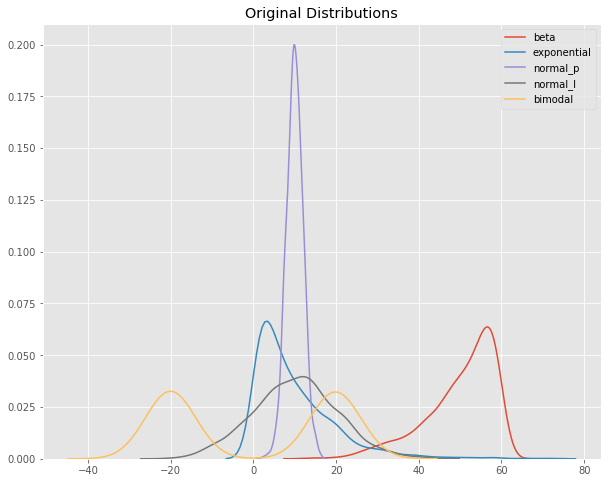

Contudo, é **crucial** destacar que a **normalização pode alterar a característica da distribuição original dos dados**. Por exemplo, ao considerarmos distribuições variadas como **Beta (na cor vermelha), exponencial (em azul)** e **duas distribuições normais (nas cores roxa e verde)**, ao normalizarmos, todas convergirão para uma **média de 0** e um **desvio padrão de 1**.



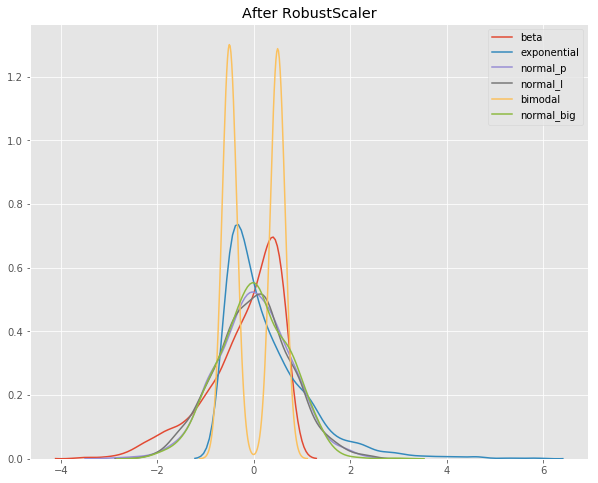

Antes de iniciar a normalização, é essencial determinar quais variáveis necessitam desse processo. Esta decisão é baseada na distribuição dessas variáveis, observadas previamente durante a **análise exploratória de dados**.

Desse modo, retornamos à seção de **Análise Univarida**, onde já estudamos a distribuição de todas as variáveis anteriormente.

Nossa atenção deve se concentrar nas **Variáveis Numéricas**. Assim, revisaremos a subseção "`Análise Univarida - Variáveis Numéricas".

O passo crucial agora é **reconhecer as variáveis com distribuição normal**. Vale reforçar que **a normalização é mais impactante quando direcionada a variáveis que já apresentam essa distribuição**. Logo, o desafio é identificar quais variáveis possuem esse perfil.

In [ ]:
# Configurações iniciais para melhorar a estética dos gráficos
sns.set_style("white")
sns.set_palette("Set2")

# Plotando os histogramas
fig = plt.figure(figsize=(25, 20))

for i, column in enumerate(num_attributes.columns, start=1):
    ax = fig.add_subplot(4, 4, i)  # Supondo que temos até 16 colunas no DataFrame
    sns.histplot(num_attributes[column], bins=25, kde=True, ax=ax)

    # Ajustando os títulos e eixos
    ax.set_title(f'Distribuição de {column}', fontsize=15)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

# Ajustando o layout para garantir que os gráficos não se sobreponham e maximizar a clareza
plt.tight_layout()
plt.show()

Embora se possa observar que certas variáveis, como `sales`, tendem a uma distribuição mais próxima da normal, ainda assim não se configuram como uma distribuição genuinamente normal. Por conta das peculiaridades e qualidade de nossos dados, seria mais prudente **não aplicar a normalização**, evitando assim impor um formato que poderia não ser o mais apropriado.

Assim sendo, nossa próxima etapa será a **aplicação da técnica de Rescaling** em todas as variáveis. Esta estratégia tem o propósito de padronizar as variáveis para um mesmo intervalo, otimizando a performance dos algoritmos de aprendizado de máquina na sequência do projeto.

---
## **5.3 `Rescaling`**
Antes de avançarmos, é vital entender a **motivação por trás da preparação de dados** em contextos de ciência de dados.

1. **Variáveis categóricas:** Nosso conjunto apresenta três dessas variáveis que necessitam ser transformadas em formatos numéricos. Isso se deve ao fato de que os algoritmos de aprendizado de máquina operam primordialmente com entradas numéricas, tornando essa conversão essencial.

2. **Variáveis numéricas:** Observamos em nosso dataset uma ampla variedade de intervalos. Os algoritmos tendem a dar maior relevância a variáveis com valores absolutos mais elevados, o que pode ser enganoso. Para ilustrar, a variável `competition_distance` possui valores mais expressivos que `day_of_week`, mas isso não necessariamente sinaliza que ela seja intrinsecamente mais relevante. Dessa maneira, é necessário nivelar esses intervalos, assegurando que o algoritmo reconheça a verdadeira significância de cada variável.

Desta forma, a **técnica de Rescaling** surge como uma ferramenta para **padronizar todas as variáveis em um range comum**, otimizando a performance dos algoritmos de aprendizado de máquina.

---
### **5.3.1 `Min-Max Scaler`**
A técnica de **escalonamento** denominada **Min-Max Scaler** é fundamental ao trabalhar com conjuntos de dados que não seguem uma distribuição normal. Esta técnica ajusta os valores de uma variável de modo que eles fiquem dentro de uma escala estabelecida, **geralmente entre 0 e 1**. Ao fazer isso, ainda **mantemos a estrutura original dos dados, mas eles são transformados para uma escala padronizada**. Esta padronização facilita a análise subsequente, especialmente quando utilizamos algoritmos que são sensíveis à magnitude dos valores.

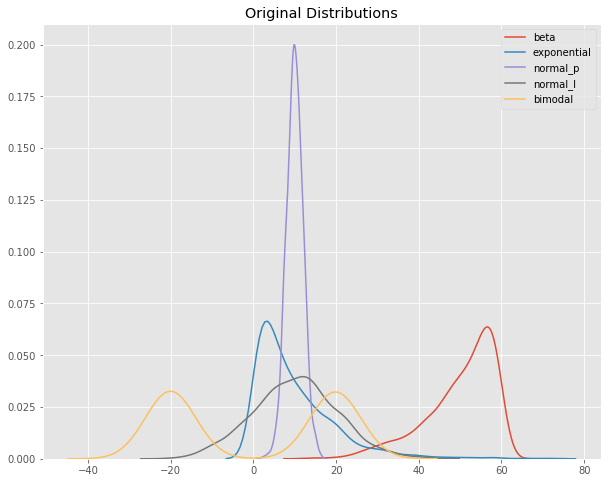

### **After implementing the MinMaxScaler:**

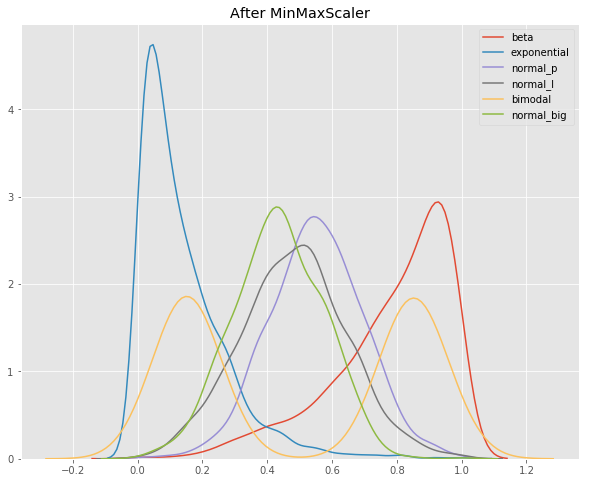

---
### **5.3.2 `Robust Scaler`**
O `Robust Scaler` é uma técnica utilizada para ajustar a escala de variáveis, **especialmente quando há a presença de valores atípicos**, ou **outliers**. Enquanto o método Min-Max Scaler pode ser influenciado por esses `outliers` (pois considera os valores mínimos e máximos), o **Robust Scaler é mais estável** nesse aspecto.

Ao invés de usar os valores extremos, o Robust Scaler **baseia-se nos quartis da distribuição** dos dados. Basicamente, ele ajusta os dados usando o primeiro `25º percentil` e terceiro quartis `75º percentil`, que são pontos da distribuição menos afetados por outliers.

Essa abordagem é particularmente útil quando queremos **manter a estrutura original dos dados**, evitando distorções provocadas por valores muito discrepantes. Contudo, é importante notar que, apesar de ser menos sensível a outliers, o Robust Scaler **pode alterar a característica da distribuição de alguns conjuntos** de dados.

---
### **Aplicação**
O primeiro passo para a aplicação de técnicas de escalonamento é **identificar as variáveis que serão escalonadas**. Fazemos isso selecionando as variáveis numéricas em nossos dados.

Podemos utilizar a função `select_dtypes`, que permite selecionar colunas de um DataFrame com base em seus tipos de dados.

In [ ]:
# Selecionando apenas as colunas numéricas (int64 e float64) do DataFrame df5
colunas_numericas = df5.select_dtypes(include=['int64', 'float64'])

# Exibindo as 5 primeiras linhas das colunas numéricas selecionadas
colunas_numericas.head()

No código em questão, pedimos ao pandas para nos mostrar colunas que são, predominantemente, numéricas, ou seja, aquelas do tipo `int64` ou `float64`. Ao visualizarmos as primeiras linhas, confirmamos se a seleção foi feita corretamente.

**Decisão de Escalonamento:** A natureza dos seus dados guia se deve aplicar o MinMaxScaler ou o RobustScaler. No nosso caso, optamos por usar estas técnicas nas variáveis como `day_of_week`, `competition_distance` e outras, totalizando oito variáveis específicas.

**Variáveis Cíclicas:** Algumas variáveis têm um padrão que se repete ao longo do tempo, como **month** ou `day_of_week`. Chamamos essas variáveis de cíclicas. Em preparação para modelagem, essas variáveis beneficiam-se de uma transformação especial, levando em conta sua **natureza repetitiva**.

**Variáveis Não Cíclicas:** Por outro lado, temos variáveis que não seguem esse ciclo repetitivo, por exemplo, `competition_distance` e `year`. A grande questão é decidir qual técnica de escalonamento é a mais apropriada. E aqui, **a decisão frequentemente se baseia na presença ou ausência de outliers**, que são valores extremos que podem distorcer análises.

**Identificação de Outliers:** Uma ferramenta visual, como o `boxplot`, nos ajuda nesse processo. Ao visualizar, por exemplo, a variável `competition_distance` por meio de um boxplot, podemos rapidamente identificar a presença de outliers e, assim, tomar decisões mais informadas sobre a técnica de escalonamento a ser aplicada.

---
### 1. **Robust Scaler em `competition_distance`**

In [ ]:
# Configuração do tamanho da figura
plt.figure(figsize=(24, 6))

# Primeiro Gráfico - Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(df5['competition_distance'], color='skyblue')
plt.title('Boxplot da Distância de Concorrência', fontsize=15)
plt.xlabel('Distância de Concorrência', fontsize=12)
plt.ylabel('Distribuição', fontsize=12)

# Segundo Gráfico - Distribuição
plt.subplot(1, 2, 2)
sns.distplot(df4['competition_distance'], color='salmon', bins=20, kde=True)
plt.title('Distribuição da Distância de Concorrência', fontsize=15)
plt.xlabel('Distância de Concorrência', fontsize=12)
plt.ylabel('Densidade', fontsize=12)

# Ajuste do layout para evitar sobreposição e melhor apresentação
plt.tight_layout()

# Exibir a figura
plt.show()

No contexto dos nossos dados, detectamos **outliers** marcantes na variável `competition_distance`. Diante disso, a escolha mais acertada é o `RobustScaler`, que se destaca justamente por sua menor sensibilidade a outliers. Essa característica o torna especialmente indicado para o nosso cenário.

Para começarmos a usar o `RobustScaler`, o primeiro passo é trazê-lo para o nosso código. Isso é feito importando-o da renomada biblioteca `Scikit-learn` em Python.

In [ ]:
# Importando a ferramenta necessária
from sklearn.preprocessing import RobustScaler

# Instanciando o RobustScaler
robust_scaler = RobustScaler()

# Aplicando a transformação na coluna desejada
df5['competition_distance'] = robust_scaler.fit_transform(df5[['competition_distance']])


Quando falamos sobre o `RobustScaler`, estamos basicamente discutindo uma ferramenta que ajuda a ajustar nossos dados, especialmente quando temos alguns valores outliers que se desviam muito da média. Imagine que você esteja tentando nivelar um terreno, mas há algumas pedras grandes no caminho. O RobustScaler ajuda a "achatar" essas pedras para que elas não interfiram muito na paisagem geral.

A mágica acontece com o método `fit_transform()`. A primeira parte, `fit`, é como se estivéssemos medindo as pedras, entendendo seu tamanho e localização. A segunda parte, `transform`, é onde nivelamos tudo.

Então, depois de usar o `RobustScaler`, a coluna `competition_distance` ainda tem seus valores originais, mas são apresentados de uma maneira que faz mais sentido para nossas análises, pois as "grandes pedras" já não são mais um problema tão grande.

In [ ]:
# Configurando o tamanho geral da figura
plt.figure(figsize=(24, 6))

# Gráfico de Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(df5['competition_distance'], color='skyblue')
plt.title('Boxplot da Distância de Competição com Robust Scaler', fontsize=16)
plt.xlabel('Distância de Competição', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Gráfico de Distribuição
plt.subplot(1, 2, 2)
sns.distplot(df5['competition_distance'], color='salmon', bins=30, kde=True)
plt.title('Distribuição da Distância de Competição com Robust Scaler', fontsize=16)
plt.xlabel('Distância de Competição', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustando os gráficos para não se sobrepor
plt.tight_layout()
plt.show()

Quando observamos o gráfico de `competition_distance`, notamos uma mudança. **Antes, os valores iam de 0 até 200 mil**. Mas, depois que aplicamos uma técnica chamada `Robust Scaler`, a história mudou um pouco: os valores agora variam entre 0 e 1.

Mas eis o detalhe: **a forma da distribuição não muda**, apenas o intervalo de valores. Se você imaginar que os dados são como uma borracha, esticamos ou comprimimos essa borracha para que ela caiba entre 0 e 1. Ela ainda **tem o mesmo formato**, mas **em um tamanho diferente**.

Por que fazer isso? Bem, ao trazer todas as variáveis para a mesma escala, entre 0 e 1, **garantimos que nenhuma delas seja mais "importante" do que outra apenas por ter números maiores**. É como se estivéssemos nivelando o campo de jogo para todos os dados. Assim, quando vamos construir um modelo, cada variável contribui de maneira justa.

Isso é o que torna o `Robust Scaler` tão valioso. Ele permite que as variáveis conversem entre si em igualdade de condições, mas sem mudar a essência de como cada uma é distribuída.

---
### 2. **Robust Scaler em `competition_time_month`**
Adotaremos o mesmo procedimento para a variável `competition_time_month`.







In [ ]:
# Configurando o tamanho geral da figura
plt.figure(figsize=(24, 6))

# Gráfico de Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(df5['competition_time_month'], color='skyblue')
plt.title('Boxplot dos Meses de Competição com Robust Scaler', fontsize=16)
plt.xlabel('Meses de Competição', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Gráfico de Distribuição
plt.subplot(1, 2, 2)
sns.distplot(df4['competition_time_month'], color='salmon', bins=30, kde=True)
plt.title('Distribuição dos Meses de Competição com Robust Scaler', fontsize=16)
plt.xlabel('Meses de Competição', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustando os gráficos para não se sobrepor
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import RobustScaler

# Aplicando o RobustScaler à coluna
rs = RobustScaler()
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']])

# Configurando o tamanho geral da figura
plt.figure(figsize=(24, 6))

# Gráfico de Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(df5['competition_time_month'], color='skyblue')
plt.title('Boxplot dos Meses de Competição com Robust Scaler', fontsize=16)
plt.xlabel('Meses de Competição (Escalado)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Gráfico de Distribuição
plt.subplot(1, 2, 2)
sns.distplot(df5['competition_time_month'], color='salmon', bins=30, kde=True)
plt.title('Distribuição dos Meses de Competição', fontsize=16)
plt.xlabel('Meses de Competição', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustando os gráficos para não se sobrepor
plt.tight_layout()
plt.show()

---
### 3. **MinMaxScaler em `promo_time_week`**


In [ ]:
# Configurando o tamanho geral da figura
plt.figure(figsize=(24, 6))

# Gráfico de Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(df5['promo_time_week'], color='skyblue')
plt.title('Boxplot das Semanas de Promoção', fontsize=16)
plt.xlabel('Semanas de Promoção', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Gráfico de Distribuição
plt.subplot(1, 2, 2)
sns.distplot(df4['promo_time_week'], color='salmon', bins=30, kde=True)
plt.title('Distribuição das Semanas de Promoção', fontsize=16)
plt.xlabel('Semanas de Promoção', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustando os gráficos para não se sobrepor
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Aplicando a transformação MinMaxScaler
mms = MinMaxScaler()
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']])

# Configurando o tamanho geral da figura
plt.figure(figsize=(24, 6))

# Gráfico de Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(df5['promo_time_week'], color='skyblue')
plt.title('Boxplot das Semanas de Promoção com MinMax Scaler', fontsize=16)
plt.xlabel('Semanas de Promoção', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Gráfico de Distribuição
plt.subplot(1, 2, 2)
sns.distplot(df4['promo_time_week'], color='salmon', bins=30, kde=True)
plt.title('Distribuição das Semanas de Promoção', fontsize=16)
plt.xlabel('Semanas de Promoção', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustando os gráficos para não se sobrepor
plt.tight_layout()
plt.show()


---
### **4. MinMaxScaler em `year`**


In [ ]:
# Configurando o tamanho geral da figura
plt.figure(figsize=(24, 6))

# Gráfico de Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(df5['year'], color='skyblue')
plt.title('Boxplot do Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Gráfico de Distribuição
plt.subplot(1, 2, 2)
sns.distplot(df4['year'], color='salmon', bins=30, kde=True)
plt.title('Distribuição do Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustando os gráficos para não se sobrepor
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalizando a coluna 'year' com MinMaxScaler
mms = MinMaxScaler()
df5['year'] = mms.fit_transform(df5[['year']])

# Configurando o tamanho geral da figura
plt.figure(figsize=(24, 6))

# Gráfico de Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(df5['year'], color='skyblue')
plt.title('Boxplot do Ano com MinMaxScaler', fontsize=16)
plt.xlabel('Ano Normalizado', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Gráfico de Distribuição
plt.subplot(1, 2, 2)
sns.distplot(df4['year'], color='salmon', bins=30, kde=True)
plt.title('Distribuição do Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustando os gráficos para não se sobrepor
plt.tight_layout()
plt.show()


---
## **5.4 `Encoding`**
Ao preparar os dados para modelos de aprendizado de máquina, precisamos converter as variáveis categóricas em numéricas. Isso é conhecido como **codificação (encoding)**. Por exemplo, transformar uma variável "cor" que tem valores como "vermelho", "azul" e "verde" em números 1, 2 e 3.

Por que fazer isso? A maioria dos modelos só entende números. Não sabe como lidar com palavras ou categorias diretamente.

Existem muitos métodos para fazer essa codificação. Cada um tem sua utilidade, e a escolha do melhor método depende da natureza dos seus dados. Aqui vão duas recomendações:

1. **Estude seus dados:** Veja os diferentes valores que sua variável categórica pode ter e como eles se relacionam com o que você quer prever.
2. **Teste diferentes abordagens:** A melhor maneira de saber o que funciona para seus dados é experimentar. Aplique diferentes métodos de codificação e veja qual oferece os melhores resultados.

Lembre-se: o que funciona bem para um conjunto de dados pode não ser ideal para outro. Portanto, conhecer e experimentar é a chave.

---
### **Tipos de Encoding**
Existem diferentes formas de transformar palavras ou categorias em números para que nossos modelos de máquina possam entendê-las. Aqui estão seis métodos comuns para isso:

- **`One-Hot Encoding`:** Cria uma coluna para cada categoria. Se a categoria estiver presente, o valor é 1, se não, é 0.

- **`Label Encoding`:** Atribui um número diferente a cada categoria. Útil quando há muitas categorias.

- **`Ordinal Encoding`:** Como o Label, mas respeita a ordem das categorias. Por exemplo, "baixo", "médio" e "alto" podem virar 1, 2 e 3.

- **`Target Encoding`:** Usa a média do valor alvo de cada categoria como seu número.

- **`Frequency Encoding`:** Em vez de média, este método usa a frequência de aparição da categoria.

- **`Binary Encoding`:** Converte as categorias em códigos binários. Bom para muitas categorias.

Quer se aprofundar? Há um [artigo](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02) excelente sobre o tema. E se estiver programando em Python, o pacote [category_encoders](https://contrib.scikit-learn.org/category_encoders/) pode ser útil.

---
### **5.4.1 `One-Hot Encoding`**
O One-Hot Encoding é como criar uma "caixinha de seleção" para cada categoria de uma variável.

Imagine que temos uma variável chamada 'Temperatura', que pode ser 'Frio', 'Morno', 'Quente' ou 'Muito Quente'. Ao usar One-Hot Encoding, faremos uma coluna para cada uma destas opções.

Agora, pense que você tem uma linha onde a 'Temperatura' é 'Quente'. Nesse caso, você vai "marcar" a caixinha (ou coluna) 'Quente' com '1' e deixar todas as outras (Frio, Morno, Muito Quente) como '0'.

É como se cada opção tivesse sua própria caixinha e nós marcássemos a que se aplica em cada caso.



In [ ]:
data = {'Temperatura': ['Quente'], 'Frio': [0], 'Morno': [0], 'Quente': [1], 'Muito Quente': [0]}
df = pd.DataFrame(data)
print(df)

Imagine que você tem um conjunto de lápis coloridos. Usar a técnica do One-Hot Encoding é como separar cada lápis por sua cor em caixinhas diferentes.

**Vantagens:**
- É como se você tivesse uma caixinha para cada cor, tornando fácil identificar qual lápis você possui (ou seja, é simples de aplicar).
- Seu conjunto inicial de lápis (variáveis categóricas) agora pode ser representado de forma numérica.

**Desvantagens:**
- Se você tiver muitas cores de lápis, acabará com muitas caixinhas! Isso pode ocupar muito espaço (aumenta a dimensionalidade dos dados).
- Ter muitas caixinhas pode complicar quando você for desenhar algo (ou seja, tornar o aprendizado do modelo mais complexo).

**Exemplo Prático:**
Pense em dias comuns e feriados. Os feriados são como cores especiais em seu conjunto. Ao usar One-Hot Encoding, você pode separar os feriados em sua própria caixinha, destacando sua importância. Isso ajuda a perceber as diferenças de comportamento entre um dia comum e um feriado, o que pode ser valioso para modelos que preveem eventos nessas datas.



---
### **5.4.2 `Label Encoding`**
Imagine que você tem um conjunto de figurinhas de animais. Usar o Label Encoding é como dar um número de identificação para cada animal, como se estivesse catalogando sua coleção.

**O que acontece?**
- Cada animal (categoria) recebe um número único, como um código.
- Esse número não diz nada sobre o animal. Por exemplo, dar o número 1 para um gato e 2 para um cachorro não significa que um é "melhor" ou "maior" que o outro. É apenas um código!

**Exemplo Prático:**
Se pensarmos em uma coleção com figurinhas de temperaturas como 'Cold' (Frio), 'Warm' (Morno), 'Hot' (Quente) e 'Very Hot' (Muito Quente), a técnica de Label Encoding poderia catalogá-las assim:

- Frio: 1
- Morno: 2
- Quente: 3
- Muito Quente: 4

Lembre-se: Os números são apenas códigos. No nosso exemplo, não significa que "Muito Quente" é 4 vezes mais quente que "Frio". Eles são apenas identificadores.

In [ ]:
data = {'Temperatura': ['Quente', 'Frio', 'Muito Quente', 'Morno'], 'Codificação (Label Encoding)': [1, 2, 3, 4]}
df = pd.DataFrame(data)
df

Ao usar o Label Encoding, atribuímos um número único para cada categoria da variável 'Temperatura'. Esses números não refletem uma ordem ou hierarquia; são apenas representações numéricas das categorias.

Esta técnica é especialmente valiosa quando estamos trabalhando com categorias que não têm uma sequência ou relação clara entre elas, como nomes de cidades ou marcas de produtos. Porém, precisamos ter cautela: se a variável categórica tiver uma sequência lógica (como 'baixo', 'médio', 'alto'), o uso do Label Encoding pode confundir o modelo. Isso porque, nesse método, os números são apenas etiquetas e não refletem a ordem real das categorias.

---
### **5.4.3 `Ordinal Encoding`**
O Ordinal Encoding é uma técnica especial de codificação que leva em conta a ordem ou hierarquia das categorias. Isso é essencial quando as categorias têm uma sequência lógica, como em graduações ou intensidades.

Por exemplo, a variável 'Temperatura', que possui as categorias 'Cold' (Frio), 'Warm' (Morno), 'Hot' (Quente) e 'Very Hot' (Muito Quente). Diferentemente do Label Encoding, que apenas etiqueta as categorias, o Ordinal Encoding respeita a ordem natural. Portanto, ao codificar, 'Cold' teria um valor menor que 'Warm', que seria menor que 'Hot', que, por fim, seria menor que 'Very Hot'.

Em resumo, o Ordinal Encoding é como se estivéssemos dando notas em uma escala para cada categoria, respeitando sua posição ou intensidade na sequência.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Dados iniciais
data = {'Temperatura': ['Cold', 'Warm', 'Hot', 'Very Hot']}
df = pd.DataFrame(data)

# Codificando a coluna 'Temperatura' respeitando a ordem das categorias
encoder = OrdinalEncoder(categories=[['Cold', 'Warm', 'Hot', 'Very Hot']])
df['Temperatura_codificada'] = encoder.fit_transform(df[['Temperatura']])
print(df)

O Ordinal Encoding reflete a sequência das categorias categóricas na sua representação numérica, tornando os dados mais relevantes para alguns algoritmos de aprendizado de máquina.

Porém, é crucial usá-lo somente quando há uma ordem clara entre as categorias. Caso contrário, poderíamos induzir uma hierarquia inexistente, comprometendo a precisão do modelo de aprendizado.

---
### **5.4.4 Target Encoding**
A codificação *target* transforma categorias categóricas baseando-se na média do valor alvo associado a cada categoria.

Imagine que temos uma variável categórica "Temperatura" com categorias como 'Quente', 'Frio', 'Muito Quente' e 'Morno'. E também, temos uma variável alvo, como "Vendas".

Ao usarmos a codificação *target* na "Temperatura", substituímos cada categoria pela média de "Vendas" correspondente a ela.

In [ ]:
import pandas as pd

data = {
    'Temperatura': ['Quente', 'Frio', 'Muito Quente', 'Morno', 'Quente', 'Morno', 'Morno', 'Quente', 'Quente', 'Frio'],
    'Valor_Alvo': [0.7, 0.5, 0.2, 0.3, 0.7, 0.3, 0.3, 0.7, 0.7, 0.5]
}

df = pd.DataFrame(data)
df


Quando temos uma variável categórica com muitas categorias diferentes, usar a codificação target é uma mão na roda! Por quê? Imagine que cada categoria virasse uma coluna nova, como acontece no método one-hot. Teríamos um monte de colunas!

Mas com a codificação target, a gente evita essa "explosão" de colunas, tornando a análise mais simples e eficaz.

---
### **5.4.5 `Frequency Encoding`**
Vamos falar da codificação por frequência, um jeito bem prático de lidar com variáveis cheias de categorias diferentes. A ideia é simples: ao invés de se preocupar com o nome da categoria, vamos ver a frequência que ela aprece.

Imagine que estamos falando sobre temperaturas: 'Quente', 'Frio', 'Muito Quente' e 'Morno'. No lugar de cada "Quente", por exemplo, colocaríamos o número de vezes que "Quente" aparece ou a proporção dele no nosso conjunto todo.

In [ ]:
import pandas as pd

# Dados sobre temperaturas
dados = {
    'Temperatura': ['Quente', 'Frio', 'Muito Quente', 'Morno', 'Quente', 'Morno', 'Morno', 'Quente', 'Quente', 'Frio'],
    'Valor_Correspondente': [0.4, 0.2, 0.1, 0.3, 0.4, 0.3, 0.3, 0.4, 0.4, 0.2]
}

# Transformando os dados em uma tabela (DataFrame)
df_temperaturas = pd.DataFrame(dados)

# Vamos ver como ficou!
print(df_temperaturas)


A técnica de codificação por frequência é bem prática quando lidamos com variáveis categóricas que representam, por exemplo, "nomes" ou "etiquetas" sem uma ordem ou relação clara entre eles. Imagine que você está trabalhando em um projeto relacionado a marcas de carros. Aqui, nomes como 'Chevrolet', 'Ford' e outros não têm uma hierarquia ou ordem específica entre si.

Neste cenário, a codificação por frequência pode funcionar. Com ela, em vez de trabalhar diretamente com os nomes das marcas, você representaria cada marca pela quantidade de vezes que ela aparece no seu conjunto de dados. Dessa forma, 'Chevrolet' poderia ser substituído pelo número de vezes que essa marca aparece, o mesmo valendo para 'Ford' e assim por diante.

Assim, conseguimos dar um tratamento numérico à nossa informação, mantendo a relevância dos dados e facilitando o trabalho dos algoritmos.

---
### **5.4.6 `Embeding Encodin`**
A técnica de "Embedding Encoding" (ou Codificação de Incorporação) é como uma varinha mágica no mundo do Deep Learning, especialmente quando estamos falando de Processamento de Linguagem Natural (NLP). Seu objetivo principal é transformar palavras ou categorias em pequenos vetores cheios de números. As palavras ou categorias com significados ou usos parecidos acabam por se aproximar nesse espaço formado pelos vetores.

Imagine que temos um "dicionário" de palavras: "hot", "cold", "very hot" e "warm". Se optarmos por representar cada palavra usando dois números (ou seja, em duas dimensões), poderíamos ter algo assim:

- "hot": [0.1, 0.3]
- "cold": [-0.2, -0.1]
- "very hot": [0.2, 0.4]
- "warm": [0, 0.2]

O que precisamos saber é que os números nestes vetores não são escolhidos ao acaso! Durante o treinamento de um modelo, o algoritmo ajusta esses números com base em como as palavras são usadas juntas no conjunto de dados. Portanto, ao final, palavras com usos ou significados semelhantes terão vetores mais próximos entre si.

Essa técnica é super poderosa que consegue pegar o "sentido" das palavras e transformar em números de forma inteligente.

---
## **5.5 `Encoding`**
Imagine que temos uma tabela de dados, chamada **`df5`**. Esta tabela possui uma coluna denominada **`state_holiday`**, que indica o tipo de feriado em um determinado dia. Em alguns registros, o valor é **dias regulares**, indicando um dia sem feriado. Em outros, pode ser 'Páscoa', 'Natal' ou outros tipos de feriados.

A técnica de codificação One-hot tem a função de criar novas colunas para cada categoria única na coluna original. Assim, para cada registro, atribuímos o valor '1' na coluna correspondente ao seu tipo de feriado e '0' nas outras colunas.

Para facilitar este processo, podemos utilizar a biblioteca Pandas. Esta biblioteca oferece uma função chamada **`get_dummies()`**, que permite realizar essa transformação de maneira eficiente. Utilizando esta função, podemos rapidamente converter nossa coluna **`state_holiday`** em várias colunas binárias.

In [ ]:
df6 = df5.copy()

---
### **5.5.1 `state_holiday`**

In [ ]:
df6.columns

In [ ]:
# state_holiday - One-Hot Encoding
df6 = pd.get_dummies(df6, columns=['state_holiday'], prefix='state_holiday')

Neste exemplo, o argumento columns especifica a coluna a ser codificada, enquanto o argumento prefix indica o prefixo a ser adicionado ao nome de cada nova coluna.

---
### **5.5.2 `store_type`**
Usando o **LabelEncoder** do sklearn, podemos converter categorias em números. Por exemplo, a variável "store_type" tem categorias 'A', 'B' e 'C'. O **LabelEncoder** dá a cada categoria um número. Isso é útil para categorias com uma sequência clara, mas também funciona para outras.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Inicializando o LabelEncoder
le = LabelEncoder()

# Transformando a coluna 'store_type' em valores numéricos
df6['store_type'] = le.fit_transform(df6['store_type'])

No código, o `fit_transform` aplica o **LabelEncoder** à coluna `store_type`, atualizando-a com os valores codificados. Se usarmos isso nos dados de treino, o mapeamento é aprendido corretamente. Contudo, se repetirmos no conjunto de teste, ele pode aprender um mapeamento diferente, tornando a representação numérica inconsistente entre treino e teste. Isso prejudica o desempenho do modelo.

---
### **5.5.3 `assortment`**
Temos a variável categórica `assortment`, que contém três categorias: `Basic`, `Extra` e `Extended`. Estas categorias têm uma ordem inerente, ou seja, `Basic` é menor que `Extra`, que por sua vez é menor que `Extended`.

Nesses casos, é útil mapear essas categorias para números que refletem essa ordem. Para isso, utilizamos o método de **codificação ordinal**.

Para aplicar a codificação ordinal, primeiro definimos um dicionário que mapeia cada categoria para um número que reflete a sua posição na escala.

In [ ]:
# Criando um dicionário para mapear os tipos de 'assortment' para valores numéricos
assortment_dict = {'basic':1, 'extra':2, 'extended':3}

# Aplicando o mapeamento à coluna 'assortment' do DataFrame df6
df6['assortment'] = df6['assortment'].map(assortment_dict)

# Exibindo uma amostra aleatória do DataFrame atualizado
df6.sample()

---
## **5.6 Data Transformation**
A transformação de dados é essencial na ciência de dados para otimizar a performance dos modelos. Há duas principais transformações:

- **`Transformação de Grandeza`:** Visa tornar a distribuição da variável mais próxima da normal. Isso beneficia algoritmos que pressupõem distribuição normal nos dados, elevando sua precisão.

- **`Transformação de Natureza`:** Foca em manter características inerentes dos dados. Como no exemplo dos meses: Dezembro (12) e Janeiro (1) são sequenciais, e essa transformação preserva tal relação, apesar da diferença numérica.

---
### **5.6.1 Tipos de Transformação**
Transformações de dados são técnicas usadas para **mudar a escala ou a distribuição dos dados**, e existem várias abordagens para realizá-las. As transformações mais comuns incluem a transformação logarítmica, a transformação Box-Cox, a extração de raiz cúbica, e a extração de raiz quadrada. Essas transformações são particularmente úteis para lidar com dados assimétricos.

- **Logarítmica:** Aplica-se o logaritmo em cada valor da variável. Útil para tornar distribuições enviesadas mais "normais".

- **Box-Cox:** Ajusta a variável para se aproximar de uma distribuição normal. Esta transformação engloba outras, como a logarítmica e raiz quadrada.

- **Raiz Cúbica:** Aplica-se a raiz cúbica em cada valor. Recomendada para dados com assimetria positiva.

- **Raiz Quadrada:** Similar à raiz cúbica, mas utiliza a raiz quadrada.

Essas técnicas melhoram o tratamento de dados com distribuições atípicas ou assimétricas.



---
### **Transformação Logarítmica da Variável Resposta `sales`**
O processo para aplicar a transformação logarítmica na variável de resposta é simples. Em nosso exemplo, utilizaremos a função **log1p** do pacote **NumPy**, uma função que aplica o logaritmo natural mais 1, para transformar a variável resposta, denominada neste caso como sales.

In [ ]:
# Configura o tamanho da figura
plt.figure(figsize=(24, 6))

# Primeiro subplot: Distribuição original das vendas
plt.subplot(1, 2, 1)
sns.distplot(df6['sales'])
plt.title('Distribuição Original das Vendas')  # Título do gráfico
plt.xlabel('Vendas')  # Label do eixo x
plt.ylabel('Densidade')  # Label do eixo y

# Transforma a coluna de vendas com log1p
df6['sales'] = np.log1p(df6['sales'])

# Segundo subplot: Distribuição das vendas após transformação logarítmica
plt.subplot(1, 2, 2)
sns.distplot(df6['sales'])
plt.title('Distribuição das Vendas após Transformação Logarítmica')
plt.xlabel('Vendas (log)')
plt.ylabel('Densidade')

plt.tight_layout()  # Ajusta o layout para evitar sobreposições
plt.show()          # Exibe o gráfico

No histograma à direita, observamos uma distribuição com formato mais próximo ao de uma curva em sino, típico de uma distribuição normal. Isso sugere que a aplicação da transformação logarítmica foi eficaz em aproximar os dados de uma distribuição normalizada.






---
### **Transformação Cíclica Temporal**
A transformação cíclica visa representar a natureza recorrente de dados temporais. Por exemplo, em uma sequência mensal que vai de Janeiro a Dezembro, observamos uma repetição a cada ano.

Pense nos meses como pontos em um círculo. A proximidade de Dezembro e Janeiro é semelhante à de Janeiro e Fevereiro, uma vez que após Dezembro, o ciclo recomeça em Janeiro. Uma representação linear (números de 1 a 12) não capta essa relação cíclica, pois coloca Dezembro e Janeiro em extremos opostos.

A solução é a **codificação cíclica** usando o **círculo trigonométrico**. Aqui, cada mês recebe duas coordenadas: o seno e o cosseno do seu ângulo correspondente no círculo. Por exemplo, com o círculo dividido em 12 partes, Janeiro (1) terá seno 0 e cosseno 1, enquanto Fevereiro (2) terá valores diferentes, e assim por diante.

Essa técnica representa cada mês com duas coordenadas, capturando a natureza cíclica e preservando a proximidade entre meses consecutivos, como Dezembro e Janeiro.

In [ ]:
import numpy as np

# Define uma constante para o cálculo cíclico baseado em um ano com 12 meses
CYCLIC_FACTOR_MONTH = 2. * np.pi / 12

# Utiliza o seno para transformar a coluna 'month' em uma coordenada cíclica
df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x * CYCLIC_FACTOR_MONTH))

# Utiliza o cosseno para transformar a coluna 'month' em outra coordenada cíclica
df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x * CYCLIC_FACTOR_MONTH))

Vamos explicar essa etapa de maneira técnica e direta:

1. **Seleção da coluna de meses**: Primeiramente, escolhemos a coluna 'month' no DataFrame df6. Essa coluna será sujeita à transformação.

2. **Definição da função de transformação**: Em seguida, criamos uma função de transformação que será aplicada a cada valor na coluna de meses. A função utiliza a função seno para transformar cada valor. O valor é multiplicado por **2 * π / ciclo**, onde ciclo representa a duração do ciclo (neste caso, 12 meses).

3. **Aplicação da função de transformação**: A função de transformação é aplicada a cada valor na coluna de meses usando o método apply, que executa uma função para cada elemento em uma série ou dataframe. O resultado é guardado em uma nova coluna denominada 'month_sin'.

4. **Repetição com a função cosseno**: O processo é repetido, mas agora empregando a função cosseno. O resultado é armazenado em outra nova coluna chamada 'month_cos'.

Agora, seguiremos o mesmo procedimento para as outras variáveis cíclicas e seus respectivos períodos.

In [ ]:
# Define uma constante para o cálculo cíclico baseado em uma semana com 7 dias
CYCLIC_FACTOR_WEEK = 2. * np.pi / 7

# Utiliza o seno para transformar o 'day_of_week' em uma coordenada cíclica
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x * CYCLIC_FACTOR_WEEK))

# Utiliza o cosseno para transformar o 'day_of_week' em outra coordenada cíclica
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x * CYCLIC_FACTOR_WEEK))

In [ ]:
# Define uma constante para o cálculo cíclico baseado em um mês com aproximadamente 30 dias
CYCLIC_FACTOR_DAY = 2. * np.pi / 30

# Utiliza o seno para transformar a coluna 'day' em uma coordenada cíclica
df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x * CYCLIC_FACTOR_DAY))

# Utiliza o cosseno para transformar a coluna 'day' em outra coordenada cíclica
df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x * CYCLIC_FACTOR_DAY))

In [ ]:
# Define uma constante para o cálculo cíclico baseado em 52 semanas no ano
CYCLIC_FACTOR_YEAR_WEEK = 2. * np.pi / 52

# Utiliza o seno para transformar a coluna 'week_of_year' em uma coordenada cíclica
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x * CYCLIC_FACTOR_YEAR_WEEK))

# Utiliza o cosseno para transformar a coluna 'week_of_year' em outra coordenada cíclica
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x * CYCLIC_FACTOR_YEAR_WEEK))

- **Transformação Cíclica para Dias da Semana**: Vamos reconhecer que o ciclo de uma semana é composto por sete dias, pois uma semana contém exatamente sete dias. Dessa forma, ao aplicar as funções seno e cosseno, usaremos o número sete como o período do ciclo.

- **Transformação Cíclica para Mês**: Em seguida, consideraremos que um mês, em média, tem a duração de 30 dias. Portanto, ao realizar a transformação cíclica para a variável mês, empregaremos o número 30 como o período do ciclo.

- **Transformação Cíclica para Semana do Ano**: Por fim, um ano é composto por cerca de 52 semanas. Portanto, ao realizar a transformação cíclica para a variável semana do ano, usaremos o número 52 como o período do ciclo.

No entanto, é importante observar que essa transformação cíclica não deve ser aplicada à variável ano, uma vez que esta é considerada linear e não cíclica, a menos que haja um mecanismo de retrocesso no tempo.

---
## **Rossmann Project Status**
Neste relato sobre o projeto de projeção de vendas que seguimos com a metodologia **`CRISP-DM`**, apresentamos os principais passos:

1. **Definição do Problema de Negócio**: A prioridade foi compreender a necessidade dos gerentes de lojas, que buscavam uma previsão de vendas para os próximos seis meses. Essa definição é essencial para determinar os objetivos e parâmetros do projeto.

2. **Entendimento do Negócio**: Investigamos a motivação por trás do pedido e identificamos que a meta era definir um orçamento para reformas nas lojas. O montante a ser destinado depende diretamente do faturamento previsto, tornando a projeção de vendas um pilar no planejamento das reformas.

3. **Coleta de Dados**: Com a clareza do desafio, coletamos dados a partir da plataforma `Kaggle`. Contudo, a obtenção de dados pode se originar de múltiplas fontes, como bancos de dados ou `API's`.

4. **Limpeza de Dados**: Após a coleta, fizemos uma revisão detalhada nos dados. Isso envolveu um panorama geral, a criação de novas `features` a partir de dados brutos e uma filtragem de variáveis considerando regras de negócio.

5. **Exploração de Dados**: Com os dados prontos, focamos em analisar correlações e formular hipóteses, visando entender como as informações coletadas poderiam auxiliar na previsão de vendas.

6. **Modelagem de Dados**: Preparamos os dados para um modelo de aprendizado de máquina, escolhendo as `variáveis` mais impactantes para a previsão de vendas.

---
# **6.0 Feature Selection**

## **6.1 Why Select Features?**
A seleção de atributos é uma fase primordial na ciência de dados. Esta prática remonta ao **princípio da Navalha de Occam**, que defende que a versão mais simples de um fenômeno é geralmente a mais adequada.

Para exemplificar: se descrevermos um carro, podemos citar elementos como quatro rodas, dois faróis e uma placa. Esse conjunto de características nos dá uma representação básica do carro.

Há quem possa adicionar atributos como Bluetooth, wi-fi, câmbio automático e outros. Embora mais detalhado, esse modelo não abrange todos os carros, tornando-o menos universal.

Pela Navalha de Occam, **o modelo mais simples é frequentemente o mais eficaz**, visto que generaliza melhor o fenômeno estudado. Essa filosofia orienta a seleção de variáveis em ciência de dados.

No contexto de aprendizado de máquina, **a meta é aprimorar a aprendizagem adotando modelos mais enxutos**. A simplicidade do dataset se reflete na quantidade de `variáveis` ou `features` presentes. Algumas dessas podem ser repetitivas ou 'colineares', ou seja, retratam o mesmo aspecto do fenômeno.

**Eliminar variáveis colineares torna o modelo mais ágil**. Usando nosso exemplo do carro, "quatro rodas" e "quatro pneus" retratam o mesmo. Assim como "lanternas" e "faróis" são equivalentes em essência.

Desse modo, selecionar atributos se concentra em detectar e descartar variáveis colineares, gerando um modelo mais conciso e, assim, facilitando a sua assimilação por algoritmos. Técnicas variadas de seleção de variáveis serão exploradas em fases subsequentes deste projeto.

---
### **6.1.2 Feature Selection Methods**

### **Why Select Features?**
O ato de escolher os atributos certos é central em modelagem de dados. A seleção correta pode acentuar a precisão e eficiência de um modelo. Aqui estão três principais métodos de seleção:

- **`Univariate Selection (Filter Methods)`:** Avalia a relação entre cada `variável` individual e a `variável alvo`. Aqueles com **forte correlação são mantidos**, enquanto os de baixa correlação são descartados.

- **`Feature Importance (Embedded Methods)`:** Classifica `variáveis` pela sua importância estatística no dataset. Essencialmente, quanto mais uma `variável` influencia o resultado, mais importante ela é.

- **`Subset Selection (Wrapper Methods)`:** Examina **combinações de variáveis para determinar conjuntos que otimizam o desempenho**. Útil quando as `variáveis` estão inter-relacionadas.

### **Understanding Correlation**
A **correlação quantifica o relacionamento** entre duas variáveis. Com valores entre -1 e 1, indica a força e direção da relação. Proximidade de 1 sugere correlação positiva; -1 implica correlação negativa e valores próximos de zero denotam fraca relação.

Se tratando de variáveis numéricas, usamos o **coeficiente de correlação**. Já para categóricas, empregamos outros métodos:

- **Variáveis contínuas:** correlação de `Pearson`.
- **Variáveis categóricas:** `Cramér's V` ou `Chi-Square`.
- **Preditora categórica e alvo contínuo:** Análise de Variância `(ANOVA)`.
- **Preditora contínua e alvo categórica:** Linear Discriminant Analysis `(LDA)`.

### **Univariate Selection Method**
Neste método, cada `variável` é avaliada individualmente em relação à `variável resposta`. Ele é direto e rápido. No entanto, sua desvantagem é não considerar interações entre `variáveis`. Por isso, há risco de descartar `variáveis` que poderiam ser relevantes quando combinadas com outras.

Ao escolher métodos de seleção, é essencial ponderar sobre as características do dataset e objetivos do projeto. O equilíbrio entre simplicidade e precisão é chave para um modelo robusto.

---
### **6.1.3 Variable Selection by Importance Method**  

A **seleção de variáveis** é fundamental na ciência de dados. O método de importância, também conhecido como *método embutido*, é diferenciado pois não foca apenas na correlação entre variáveis. Por exemplo, o algoritmo `Random Forest` seleciona variáveis durante seu aprendizado, tornando esta seleção parte integral do processo. Da mesma forma, algoritmos de regressão regularizados, como `Lasso` e `Ridge`, atribuem pesos às variáveis, indicando sua relevância.

Quando falamos em seleção de variáveis pelo método de importância, estamos nos referindo a um processo em que identificamos quais variáveis são mais relevantes para um modelo. Esta abordagem difere da seleção univariada, que analisa a correlação entre as variáveis de forma isolada.

Imagine que você está construindo um modelo como o Random Forest. Durante a construção, o modelo já está, por natureza, selecionando as variáveis mais importantes para chegar a um resultado. Assim, ao final, conseguimos saber quais variáveis o modelo considerou mais relevantes. Portanto, esta técnica é como se o modelo "nos contasse" quais são as variáveis mais importantes para ele.

---
### **6.1.4 Variable Selection with Gini Impurity**  

O algoritmo `Random Forest` utiliza a impureza de Gini, uma métrica de homogeneidade, para avaliar a importância das variáveis. Variáveis que resultam em subconjuntos homogêneos de dados são consideradas importantes.

O `Random Forest` tem uma maneira particular de escolher variáveis, baseada na impureza de Gini. Este critério avalia quão homogêneo é um conjunto de dados quando dividido por uma variável.

Vamos a um exemplo: imagine que estamos analisando vendas e dividimos os dados com base no `preço`. Se, após a divisão, os grupos de vendas de preços altos e baixos forem muito similares internamente, o `preço` é uma variável importante. A chave aqui é que o Random Forest busca variáveis que resultem em subconjuntos o mais homogêneo possível.

---
### **6.1.5 Variable Selection with Lasso Regression**  

A `Regressão Lasso` penaliza coeficientes do modelo, fazendo com que alguns sejam zero. Isso simplifica o modelo, destacando variáveis com coeficientes significativamente distintos de zero como mais relevantes.

A `Regressão` Lasso é como um "filtro" para variáveis. Ao criar um modelo, este método aplica uma penalidade aos coeficientes das variáveis. Se a penalidade for forte o suficiente, alguns coeficientes podem se tornar zero, indicando que essas variáveis não são importantes.

Na prática, ao aplicar a `regressão Lasso`, acabamos por obter uma lista de variáveis com seus respectivos pesos. As variáveis com pesos mais distantes de zero são as mais relevantes.

---
### **6.1.6 Subset Selection (Wrapper Method)**  

Diferente de métodos que dependem de correlação ou importância atribuída pelo modelo, a **seleção por subconjuntos** avalia combinações de variáveis em relação ao desempenho do modelo. O processo envolve adicionar variáveis, avaliar desempenho e remover as não-informativas, até se obter o subconjunto ideal.

Imagine ter que testar todas as combinações possíveis de variáveis para encontrar o melhor conjunto para seu modelo. Isso é o que faz a seleção por subconjuntos. Ela avalia cada combinação, treina o modelo e verifica o desempenho.

O diferencial deste método é que ele não se baseia apenas na correlação entre as variáveis ou na importância dada por um modelo. Ele se concentra diretamente no desempenho.

---
### **6.2 Variable Selection with Boruta Algorithm**  

O `Boruta` destaca-se pelo uso de `variáveis shadow`, cópias de variáveis originais com dados embaralhados. A ideia é comparar a importância das variáveis originais com as shadow, identificando as mais relevantes por meio de análise estatística.

O `Boruta` é como um detetive em busca de variáveis importantes. Ele utiliza o Random Forest e cria cópias (ou sombras) das variáveis originais, mas com os dados embaralhados. Em seguida, compara a importância das variáveis originais com essas cópias embaralhadas.

Se uma variável original for consistentemente mais importante do que suas cópias embaralhadas, ela é considerada relevante. Assim, o `Boruta` nos fornece uma lista das variáveis mais significativas, baseando-se na comparação com suas sombras.

---
### **6.2.1  Splitting the DataFrame into Training and Test Sets**

Antes de implementar o `Boruta`, é crucial dividir o DataFrame. Algumas variáveis originárias, que geraram novas características, devem ser removidas para evitar redundâncias. Para isso, uma lista, `cols_drop`, é criada, e as variáveis correspondentes são excluídas do DataFrame utilizando o método 'drop' do `pandas`.

In [ ]:
# Definindo uma lista de colunas para serem removidas
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

# Removendo as colunas especificadas do DataFrame df6
df6.drop(columns=cols_drop, inplace=True)

Ao usar o método `drop` com o argumento `axis=1`, estamos especificando a exclusão de **colunas** inteiras. Isto significa que a coluna completa, com todos os seus registros, será removida.

O principal foco na preparação do DataFrame é eliminar **variáveis originais** que geraram novas características. Isso garante a **otimização e integridade** dos dados ao aplicar o algoritmo **Boruta**.

### **Dataset Splitting**
Esta etapa é fundamental. Aqui, partimos o nosso conjunto de dados em **conjuntos de treinamento e teste**. O propósito? Treinar o modelo com uma porção dos dados e, depois, usar o conjunto de teste para avaliar sua precisão.

Por lidarmos com um problema de séries temporais, temos que ter especial atenção à **ordem temporal**. Não é adequado selecionar linhas aleatoriamente para treinamento e teste. Misturar dados do futuro com os do passado pode causar **overfitting** - quando o modelo "decora" os dados em vez de efetivamente aprender.

Dado nosso contexto de prever seis semanas de vendas diárias por `store`, o ideal é que as **últimas seis semanas** de vendas sejam o conjunto de teste e o restante compreenda o treinamento.

Uma prática útil? **Agrupar os dados** por `store` e identificar as datas de vendas mais antigas e mais recentes. Isso clarifica o período de tempo com que estamos trabalhando.

In [ ]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

In [ ]:
# Agrupa o DataFrame por loja e pega a data máxima para cada uma
max_dates_by_store = df6.groupby('store')['date'].max()

# Pega a data máxima da primeira loja
max_date_first_store = max_dates_by_store.iloc[0]

# Subtrai 42 dias (6 semanas) da data máxima da primeira loja
result_date = max_date_first_store - datetime.timedelta(days=6*7)

### **Data Splitting Strategy**

Para segmentar os dados em **treinamento e teste**, identificamos a **data limite** para o treinamento. Isso é feito subtraindo seis semanas da data máxima de venda com o método `timedelta` da classe `datetime`.

Tomando como exemplo a data máxima 31/07/2015: ao retirarmos 42 dias (seis semanas), chegamos à data de 19/06/2015. Assim, os dados desde o início até 18/06/2015 são designados para **treinamento** e, de 19/06/2015 até a data máxima, para **teste**.

In [ ]:
# Definindo a data de corte para separar os conjuntos de treinamento e teste
cutoff_date = '2015-06-19'

# Criando o conjunto de treinamento a partir das entradas anteriores à data de corte
X_train = df6[df6['date'] < cutoff_date]
y_train = X_train['sales']

# Criando o conjunto de teste a partir das entradas a partir da data de corte (inclusive)
X_test = df6[df6['date'] >=  cutoff_date]
y_test = X_test['sales']

### **Data Validation**

Após segmentar os dados, é vital **validar** a divisão. Imprimimos as datas mínimas e máximas dos conjuntos `treinamento` e `teste`. A data máxima do `treinamento` deve ser exatamente um dia anterior à data mínima do `teste`. Além disso, a última data de venda corresponde à data máxima do conjunto `teste`. Essas verificações asseguram uma **sequência contínua de datas**, respeitando a natureza temporal dos dados.

In [ ]:
# Exibindo a data mínima do conjunto de treinamento
print('Data mínima do treinamento: {}'.format(X_train['date'].min()))

# Exibindo a data máxima do conjunto de treinamento
print('Data máxima do treinamento: {}'.format(X_train['date'].max()))

# Exibindo a data mínima do conjunto de teste
print('\nData mínima do teste: {}'.format(X_test['date'].min()))

# Exibindo a data máxima do conjunto de teste
print('Data máxima do teste: {}'.format(X_test['date'].max()))

---

## **6.3 Boruta as a Feature Selector**

Após a divisão dos dados para treinamento e teste, o foco agora é otimizar nosso modelo selecionando as características mais pertinentes usando o **Boruta**.

A classe `BorutaPy` no Python é projetada para essa função. Aqui estão seus aspectos centrais:

1. **Model Choice**: Um de seus argumentos primordiais é o modelo a ser usado. Aqui, optamos pelo `RandomForestRegressor`.
   
2. **Number of Estimators**: Para obter a melhor performance, permitimos que o Boruta escolha o número ideal de árvores ao definir isso como `'auto'`.

3. **Verbosity Log**: Estabelecemos esse log em 2. Isso nos oferece a oportunidade de monitorar o progresso do algoritmo, que pode ser um processo demorado.

4. **Random State**: A consistência é crucial. Por isso, configuramos o estado aleatório ('random state') para **42**. Isso assegura que o processo de seleção seja reproduzível em diferentes execuções.

Antes de usar o método `'fit'`, é essencial formatar os dados corretamente. O Boruta **não trabalha com dataframes**; ele exige um vetor numérico.

Segue uma breve visão do processo:

- Começamos com as importações necessárias.
- Instanciamos `RandomForestRegressor` e `BorutaPy`.
- Preparamos os dados: retirando colunas `'date'` e `'sales'` de `X_train` e transformando o restante em um vetor numérico. O vetor alvo, `y_train`, passa por um processo similar.
- Com os dados prontos, prosseguimos com o treinamento do Boruta.

In [ ]:
# Importando as bibliotecas necessárias para a seleção de características e modelagem
from boruta           import BorutaPy
from sklearn.ensemble import RandomForestRegressor

# Inicializando o RandomForestRegressor. A paralelização (n_jobs=-1) permite que o algoritmo use todos os núcleos da CPU disponíveis.
rf = RandomForestRegressor(n_jobs=-1)

# Inicializando o Boruta. Este é um algoritmo de seleção de características que funciona com RandomForest.
# O parâmetro 'auto' para n_estimators permite que o Boruta decida automaticamente o número de árvores a serem usadas.
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# Preparando os dados para serem usados com o Boruta. Estamos removendo colunas que não são necessárias para a seleção de características.
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Aplicando o Boruta nos dados para realizar a seleção de características.
boruta.fit(X_train_n, y_train_n)

### **Understanding Boruta's Results**
Analisando os resultados do algoritmo Boruta para seleção de recursos, observamos que a ferramenta gera várias informações durante sua execução. Estes são organizados em diferentes categorias, nomeadamente `Iteration`, `Confirmed`, `Tentative` e `Rejected`.

- `Iteration` é uma representação da iteração atual do algoritmo de um total de 100. Em nosso projeto, o Boruta passou por nove iterações. Este é um valor padrão, já que `Boruta executa um máximo de 100 iterações para decidir sobre cada variável`. Se atingir a centésima iteração e não puder tomar uma decisão, o algoritmo para.

- `Confirmed` indica o número de variáveis que Boruta confirmou como sendo relevantes para o modelo. Neste caso, o algoritmo confirmou `18 variáveis como importantes` ou relevantes.

- `Tentative` se refere às variáveis sobre as quais Boruta tem dúvidas. Neste estágio, o algoritmo não conseguiu classificar estas variáveis como irrelevantes ou não.

- `Rejected` são as variáveis que Boruta rejeitou e considerou não serem relevantes para o modelo. O algoritmo rejeitou nove variáveis em nosso projeto.

Portanto, através da utilização do algoritmo Boruta, fomos capazes de identificar e selecionar as variáveis mais relevantes para o nosso modelo. Também pudemos descartar as variáveis que não contribuem significativamente para a modelagem dos dados, melhorando assim a eficiência e precisão do nosso modelo.


In [ ]:
from numpy import setdiff1d

# Identifica as colunas aprovadas pelo Boruta
cols_selected = boruta.support_.tolist()

# Remove as colunas 'date' e 'sales' e armazena em X_train_fs
X_train_fs = X_train.drop(['date', 'sales'], axis=1)

# Determina o nome das colunas aprovadas pelo Boruta
cols_selected_boruta = X_train_fs.columns[cols_selected].to_list()

# Identifica as colunas que não foram aprovadas pelo Boruta
cols_not_selected_boruta = list(setdiff1d(X_train_fs.columns, cols_selected_boruta))

### **Variable Selection with Boruta** (Seleção de Variáveis com Boruta)

O algoritmo Boruta avalia e ordena variáveis com base em sua **relevância**. Utilizamos o atributo `support_` do Boruta para determinar quais variáveis foram consideradas importantes, pois ele retorna um vetor booleano com essa finalidade.

Para uma análise mais direta, criamos a lista `cols_selected`. Esta lista armazena os índices das colunas validadas pelo Boruta, e, para uma visualização prática, convertemos tais índices nos respectivos nomes de colunas. Uma observação é que, inicialmente, nosso conjunto de dados contém as colunas `date` e `sales`, que devem ser excluídas. Por isso, geramos um subconjunto nomeado `X_train_fs`, derivado do `X_train` original, porém sem estas duas colunas.

Com isso, estabelecemos um novo conjunto denominado `cols_selected_boruta` contendo apenas as variáveis autenticadas pelo Boruta de `X_train_fs`. Paralelamente, é instrutivo identificar as colunas que não obtiveram aprovação do Boruta. Para alcançar esse objetivo, comparamos `X_train_fs` com `cols_selected_boruta` usando a função `np.setdiff1d` do numpy. A diferença entre eles é então alocada na variável `cols_not_selected_boruta`.

Em resumo, através do Boruta, determinamos **quais variáveis** são vistas como cruciais pelo algoritmo.

In [ ]:
cols_selected_boruta

### **Columns Discarded by Boruta**  
O algoritmo Boruta avalia a relevância de cada variável e pode descartar aquelas que não contribuem significativamente para a modelagem. Neste contexto, **algumas variáveis foram classificadas como irrelevantes** para o modelo e, consequentemente, descartadas. Ao tomar ciência das colunas descartadas, podemos direcionar nossa atenção para as variáveis que de fato possuem maior potencial preditivo.

In [ ]:
cols_not_selected_boruta

### **Concluding Feature Selection with Boruta**  
Após a etapa de seleção de características com o algoritmo Boruta, é essencial refletir sobre os insights obtidos. Neste ponto, é benéfico revisitar nossa **análise exploratória de dados** anterior, onde abordamos várias hipóteses e construímos uma estrutura para diferenciar quais foram validadas, quais foram descartadas e a importância de cada uma no modelo.

O objetivo agora é alinhar essas observações com o que Boruta identificou como relevante. Esse alinhamento nos ajuda a consolidar os resultados e a corroborá-los com nossas investigações iniciais.

Por exemplo, ao revisar hipóteses de alta relevância, podemos observar que cada uma delas está atrelada a um determinado atributo. A hipótese 9, que sugere que as vendas nas lojas aumentariam ao longo dos anos. Curiosamente, Boruta não viu `Year` como um elemento chave. Este é um momento para ponderar e decidir se deve ou não aceitar a indicação do algoritmo. Uma abordagem comum é, inicialmente, seguir as recomendações de Boruta e, em fases futuras, reintroduzir características que possam otimizar o modelo.

Da mesma forma, a hipótese 10 relacionada ao `Month` levanta que as vendas seriam mais expressivas no segundo semestre. Enquanto Boruta avaliou `month_cos` como importante e `month_sin` como secundário, cabe a nós determinar se ambos os atributos devem ser considerados na análise.

A hipótese 11, relacionada ao `Day`, sugere vendas mais robustas após o décimo dia de cada mês. Aqui, Boruta validou tanto `day_sin` quanto `day_cos`, reforçando nossa suposição inicial.

Finalizando, a integração e a revisão entre as diretrizes de Boruta e as hipóteses da nossa análise exploratória são cruciais para garantir uma modelagem robusta e fundamentada.

---
## **6.4 Manual Feature Selection**

In [ ]:
# Lista de colunas selecionadas pelo método Boruta
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

# Colunas adicionais a serem incluídas
feat_to_add = ['date', 'sales']

# Cria uma cópia da lista original de colunas e adiciona as novas colunas a ela
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# Definição das colunas para os conjuntos de treino e teste usando as colunas selecionadas pelo Boruta
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Preparação de dados de séries temporais usando todas as colunas (incluindo as adicionais)
x_training = X_train[cols_selected_boruta_full]

---
# **7. Machine Learning**
A ciência de dados é muito impulsionada pelos **algoritmos de aprendizado de máquina**. Esses algoritmos equipam as máquinas com a capacidade de aprender com dados pré-existentes, uma analogia ao modo como os seres humanos fazem associações.

Porém, a sofisticação do aprendizado de máquina não ofusca a relevância de métodos básicos, como o cálculo da média, um instrumento essencial em várias situações comerciais que oferece um panorama da distribuição dos dados.

Dentro desse aprendizado, existem tarefas específicas. **Classificação** é uma delas, ensinando o algoritmo a distinguir, por exemplo, entre imagens de um carro, uma van e um ônibus com base em características específicas. Para um desempenho otimizado, uma gama diversificada de exemplos no treinamento é essencial.

Entretanto, não se restringe apenas à classificação. Há tarefas como **regressão**, voltada para previsões numéricas, e **análise de séries temporais**, que prevê tendências futuras com base em registros passados.

No espectro oposto, encontramos o **aprendizado não supervisionado**, no qual o algoritmo opera sem etiquetas pré-estabelecidas, identificando padrões e relações por conta própria. E entre esses extremos está o **aprendizado semi-supervisionado**, que combina características dos dois. Um exemplo cotidiano é como a Netflix seleciona capas: elas são inicialmente testadas com usuários e, conforme o feedback, as mais eficazes são priorizadas.

Resumindo, o aprendizado de máquina é um instrumento versátil e adaptável, trazendo imenso valor ao domínio da ciência de dados, independentemente do método empregado.

---
## **Machine Learning Algorithms**
**Average Model** (`Modelo de Média`): No contexto do aprendizado de máquina, muitas vezes subestimamos a simplicidade, mas ela pode ser extremamente poderosa. Tomemos, por exemplo, o `modelo de média`. Ele prevê, como o nome sugere, a média dos dados de entrada. Imagine que você deseje prever vendas futuras em sua loja. Este modelo projetaria a média das vendas passadas como sua previsão. Pode parecer básico, mas seu verdadeiro valor reside em sua capacidade de atuar como um padrão para outros modelos. Se outro modelo supera o desempenho do modelo de média, indica aprendizado genuíno. Caso contrário, a simples média se mostra eficiente.

**Linear Regression and Regularized Linear Regression** (`Regressão Linear e Regressão Linear Regularizada`): Avançando, temos os modelos de `regressão linear` e sua contraparte regularizada. Ambos adotam uma abordagem mais sofisticada do que o modelo de média, tentando traçar uma relação direta entre os dados de entrada e saída. Frequentemente, a versão regularizada apresenta desempenho superior devido à sua capacidade de penalizar recursos menos significativos, promovendo generalização. Opto por esses modelos no início devido ao princípio de **Occam's Razor**, que defende modelos mais simples sempre que são adequados.

**Random Forest and Gradient Boosting** (`Random Forest e Gradient Boosting`): Em seguida, temos duas abordagens baseadas em árvores: `Random Forest` e `Gradient Boosting`. Ambos ganharam popularidade devido ao seu robusto desempenho, especialmente em competições como as do Kaggle. Sendo adaptáveis e frequentemente superiores em termos de desempenho, são uma escolha essencial em nossa caixa de ferramentas.

Agora, você pode estar curioso sobre abordagens mais modernas, como `redes neurais`, `Deep Learning`, `CNN` e `LSTM`. Embora extremamente poderosos, esses modelos são mais complexos e demorados para implementar. Estamos em um ciclo de desenvolvimento ágil, priorizando resultados rápidos e eficientes. Em um cenário real, já estaríamos várias semanas neste projeto, e a pressão por resultados tangíveis estaria aumentando.

Certamente, à medida que o projeto evolui, esses modelos avançados serão considerados e possivelmente incorporados para otimizar ainda mais nossas previsões.

---
## **Selecting Relevant Variables**

No processo de construção de um modelo de aprendizado de máquina, **selecionar as variáveis corretas** é uma etapa crucial. Usando o **Boruta** como nossa ferramenta de seleção, identificamos um conjunto de variáveis relevantes que têm potencial para melhorar a precisão do nosso modelo.

Iniciaremos nossa implementação focando no conjunto de treinamento. Se você se lembra, tínhamos `X_train` e `X_test` já separados. A estratégia agora é extrair as colunas que o Boruta destacou como mais importantes, identificadas como `cols_selected_boruta`. Esta seleção será armazenada em uma variável chamada `x_train`, onde o "x" é intencionalmente em minúsculo, diferenciando-a de `X_train`.

Da mesma forma, para o conjunto de teste, vamos filtrar `X_test` usando as colunas selecionadas pelo Boruta. O resultado será armazenado em `x_test`.

Um ponto a notar: inicialmente, decidimos excluir as colunas "date" e "sales" no estágio de treinamento. Contudo, há um plano de reintroduzir essas variáveis mais tarde, garantindo uma análise mais ampla e, potencialmente, melhores insights.

Nossa base de dados agora é um reflexo da combinação da capacidade de seleção do Boruta com nossa experiência e intuição. Com essa etapa concluída, estamos prontos para prosseguir.

Vamos melhorar o código com instruções mais detalhadas:

In [ ]:
cols_to_remove = ['month_sinmonth_cos', 'week_of_year_sinweek_of_year_cos']
cols_selected_boruta = [col for col in cols_selected_boruta if col not in cols_to_remove]

# Seleciona as colunas identificadas como relevantes pelo Boruta para treinamento
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Em um contexto adicional, para fins de validação ou outro treinamento,
# pode-se usar uma versão mais completa das colunas selecionadas pelo Boruta
x_training = X_train[cols_selected_boruta_full]

---
## **7.1 Average Model**

O **Modelo de Média** é uma técnica fundamental ao tratar de previsões, pois serve como ponto de partida para avaliar o desempenho de modelos mais complexos.

Para desenvolver nosso Modelo de Média, nosso foco é prever a média de vendas de diversas lojas. Inicialmente, criamos uma cópia do conjunto de teste `X_test`, armazenando-a em `aux1`. Nesse conjunto, introduzimos uma coluna denominada `sales` que reflete as vendas reais, ou seja, nossa `variável-target`.

O passo subsequente consiste em calcular a média de vendas de cada estabelecimento. Para essa tarefa, agrupamos os dados por `store` e aplicamos uma média à coluna `sales`. Tal operação gera um resultado, armazenado em `aux2`.

A integração das médias calculadas ao dataset original `aux1` é realizada por meio da função de mesclagem do pandas, utilizando 'store' como a chave primária. Este procedimento é vital, pois permite que comparemos, de forma direta, a média de vendas projetada às vendas reais de cada loja.

Com as vendas reais e suas respectivas médias em mãos, estamos aptos a avaliar a performance do modelo. Para isso, empregamos uma função denominada `ml_error`. Essa função, ao receber o nome do modelo, as vendas reais e as previsões (médias de vendas calculadas), fornece três métricas de erro:
- **Erro Absoluto Médio (MAE)**: Representa a média das diferenças absolutas entre as projeções e os valores reais.
- **Erro Percentual Absoluto Médio (MAPE)**: Traduz a média das diferenças percentuais absolutas entre as previsões e os valores efetivos.
- **Raiz do Erro Quadrático Médio (RMSE)**: Corresponde à raiz quadrada da média dos erros ao quadrado.

Uma etapa adicional e fundamental é reverter a transformação logarítmica previamente aplicada à variável de resposta. A função exponencial é empregada nesse processo.

Ao final, `ml_error` gera um DataFrame do pandas, que consolida o nome do modelo e as métricas de erro obtidas.


In [ ]:
# Importando as bibliotecas necessárias
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Definindo a função de erro médio absoluto percentual (MAPE)
def mean_absolute_percentage_error(y, yhat):
    """Calcula o erro médio absoluto percentual entre valores reais e preditos."""
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    """Calcula e retorna métricas de erro para avaliação do modelo."""
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])

# Preparação dos dados para a avaliação

# Criando uma cópia dos dados de teste
aux1 = x_test.copy()
# Inserindo vendas reais ao conjunto auxiliar
aux1['sales'] = y_test.copy()

# Calculando a média de vendas por loja e armazenando em aux2
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})

# Integrando as previsões de vendas (médias) ao conjunto auxiliar
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Avaliando a performance do modelo
# Revertendo a transformação logarítmica para obter valores originais
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

### **Análise dos Resultados**

Após avaliação do modelo, identificamos algumas métricas-chave para sua performance. A métrica `MAE` indicou um erro médio absoluto de **R$ 1.354** em nossas previsões. Adicionalmente, o **Erro Médio Absoluto Percentual `MAPE` foi de **45%**, sugerindo que, em média, as previsões desviam-se em 45% dos valores reais. Por último, o `RMSE`, que nos dá uma noção da magnitude dos erros, ficou em **1.835**. Esta métrica é particularmente útil para entender a dispersão dos erros em nossas previsões.

---
## **7.2 Linear Regression Model**
No escopo de nosso projeto, visamos experimentar variados modelos de aprendizado de máquina para discernir qual melhor se harmoniza com nossa base de dados. Dentre eles, introduzimos o Modelo de Regressão Linear. Este algoritmo, de natureza supervisionada, tem como intuito projetar uma saída com base em variáveis independentes. Ele se destaca em situações que demandam previsões quantitativas, como antecipação de vendas ou estimação de tendências de progresso.

A implementação desse modelo se desdobra em três fases críticas:

**1. Treinamento**: Aqui, empregamos o método `fit` para instruir o modelo com nossos dados de treinamento (`x_train`, `y_train`). O trecho de código associado a este passo é:

In [ ]:
# Importando o modelo de Regressão Linear do scikit-learn
from sklearn.linear_model import LinearRegression

# Criando uma instância do modelo de Regressão Linear e treinando-o com o conjunto de treino (x_train e y_train)
lr = LinearRegression().fit(x_train, y_train)

Após esta etapa, o modelo treinado é armazenado na variável `lr`.

**2. Predição**: Com o modelo devidamente treinado, avançamos para as previsões utilizando os dados de teste (`X_test`), através do método predict. As projeções são posteriormente alocadas na variável `yhat_lr`:

In [ ]:
# Utilizando o modelo de Regressão Linear (lr) para fazer previsões no conjunto de teste (x_test)
yhat_lr = lr.predict(x_test)

**3. Avaliação de Desempenho**: Em seguida, analisamos a eficiência do nosso modelo utilizando a função `ml_error`, a qual contrasta os valores reais `y_test` e as predições `yhat_lr`. Caso os dados tenham sido submetidos a uma transformação, é vital restaurá-los à sua magnitude original, empregando a função np.expml:

In [ ]:
# Calcula o erro do modelo de Regressão Linear revertendo a transformação logarítmica.
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

Os resultados apresentados mostraram que a métrica `MAE` foi de 1867, o Erro Médio Absoluto Percentual `MAPE` alcançou 29%, e o `RMSE` se estabeleceu em 2671.

### **Comparativo entre Modelos**

Quando colocamos lado a lado o `Average Model` e o `Linear Regression Model`, percebemos que o `RMSE` do primeiro foi de 1835, enquanto o segundo obteve `2671`. Esta discrepância revela que o Modelo de Regressão Linear errou mais em suas projeções.

**Essas observações levam-nos a duas deduções vitais:**

- **1. Eficiência do Modelo de Média**: Seu `RMSE` inferior evidencia uma performance mais acurada na predição dos dados comparativamente ao Modelo de Regressão Linear.
- **2. Intrincado Comportamento dos Dados**: O Modelo de Regressão Linear, em sua essência, busca padrões lineares. Se nossos dados exibem um padrão distinto, isso pode justificar a menor precisão deste modelo. Portanto, os dados parecem ser mais multifacetados do que simples relações lineares poderiam captar.

Concluindo, é imprescindível que exploremos modelos não lineares em futuras análises, dado que estes podem ser mais aptos a entender e reproduzir a complexidade intrínseca de nossa base de dados.

### **7.3.1 Linear Regression Model - Cross Validation**

In [ ]:
# Realizando a validação cruzada para Regressão Linear com 5 folds
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

---
## **7.3 Linear Regression Regularized Modelo - Lasso**
A busca por desempenhos superiores em modelos de regressão frequentemente nos leva a adotar técnicas avançadas, sendo a **regularização** um dos métodos primordiais nesse contexto. Esta técnica visa **prevenir o overfitting**, um fenômeno que ocorre quando o modelo se adapta excessivamente aos dados de treinamento, comprometendo sua capacidade de generalização. Isso é realizado ao limitar os pesos vinculados a cada característica.

Dentro da regularização, encontramos o método **Lasso** (Least Absolute Shrinkage and Selection Operator). Este método possui a peculiaridade de não apenas ajustar, mas também zerar certos pesos, atuando de forma seletiva ao excluir algumas características que não são fundamentais para o modelo.

Para empregar o Lasso, instanciamos um objeto correspondente e definimos um parâmetro `alpha` de valor 0.01. Esse parâmetro tem relevância destacada, pois estabelece o nível de regularização que desejamos impor ao nosso conjunto de dados.

In [ ]:
# Importando classes do módulo 'linear_model' da 'sklearn'
from sklearn.linear_model import LinearRegression, Lasso

# Inicializando e treinando um modelo Lasso com 'alpha' de 0.01 usando os dados de treino
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

Depois de treinado, utilizamos este modelo para realizar previsões no conjunto de testes:

In [ ]:
# Realizando previsões com o modelo Lasso treinado usando os dados de teste
yhat_lrr = lrr.predict(x_test)

A seguir, calculamos o erro do modelo regularizado em comparação com os valores reais usando a função 'ml_error'. Neste caso, 'ml_error' é uma função personalizada que calcula as métricas de erro relevantes para avaliar o desempenho do modelo.

O próximo passo envolve a avaliação do desempenho deste modelo. Para tal, recorremos à função `ml_error`, uma função personalizada que gera as métricas de erro essenciais para uma análise objetiva do desempenho.

O diferencial do Lasso reside em sua capacidade de ajustar a complexidade do modelo através do `alpha`. Um detalhe importante a se observar é que, ao reduzir o valor de `alpha`, o tempo de treinamento pode aumentar, mas em contrapartida, os resultados tendem a ser mais precisos e eficientes.

In [ ]:
# Calculando o erro do modelo Lasso usando a função ml_error e revertendo a transformação dos dados
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

### **Avaliação de Desempenho do Modelo**

Após a análise, chegamos a determinados indicadores chave que refletem o desempenho do nosso modelo. O **Erro Médio Absoluto (MAE)** apresentou um valor de `1891`. Em termos percentuais, o **Erro Médio Absoluto Percentual (MAPE)** indicou uma discrepância de 29%. Adicionalmente, o modelo exibiu um **Erro Quadrático Médio da Raiz (RMSE)** de `2744`. Estes resultados são cruciais para compreendermos a precisão e a eficácia da nossa modelagem frente aos dados analisados.


### **Avaliação dos Modelos Iniciais**

Analisamos três modelos neste estudo: o modelo baseado em `média`, `regressão linear` e `regressão linear regularizada (Lasso)`. Ao avaliar os modelos pelo erro quadrático médio (`RMSE`), notamos que o modelo de média, apesar de sua simplicidade, teve o menor `RMSE`, com valor de 1.835. Por sua vez, a regressão linear marcou 2.670, enquanto o Lasso, que atua evitando o sobreajuste por penalizar coeficientes, teve um `RMSE` de 2.744. Apesar do destaque do modelo de média, é inegável a importância de considerarmos modelos não-lineares, dada a complexidade intrínseca dos dados em análise. A conclusão aqui é clara: **abordagens mais simples nem sempre são as mais apropriadas para contextos intrincados**. Portanto, nosso próximo passo será investigar modelos não-lineares.

### **Exploração de Algoritmos Não-Lineares**

Anteriormente, focamos em modelos lineares. Agora, nossa atenção volta-se para modelos não lineares, mais especificamente, o `Random Forest`. A razão para esta escolha reside no fato de que, embora modelos lineares sejam diretos, muitas vezes eles não capturam a totalidade dos padrões nos dados. O `Random Forest`, por ser um modelo mais flexível, é apto a reconhecer e modelar essas nuances. Estamos seguindo a metodologia `CRISP-DM`, começando com modelos mais simples e aumentando a complexidade conforme o projeto avança.

---
## **7.4 Regressor Random Forest**

O algoritmo `Random Forest` opera através de múltiplas árvores de decisão. Durante o treinamento, é formado um "bosque" de árvores que operam de forma independente. Quando são feitas previsões, especialmente em contextos de regressão, a saída é determinada pela média das previsões de todas essas árvores. Implementamos o `Random Forest` usando a biblioteca `Scikit-learn`, uma ferramenta robusta em Python para modelagem de dados, e uma instância desse modelo foi estabelecida como `rf`.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Instanciando e treinando um modelo de Random Forest com 100 árvores, usando um núcleo e definindo uma semente para reprodutibilidade.
rf = RandomForestRegressor(n_estimators=100,
                           n_jobs=1,
                           random_state=42).fit(x_train, y_train)

**Random Forest Model Configuration do Modelo Random Forest**

Ao instanciar o modelo de Random Forest, definimos parâmetros chave. O `n_estimators=100` determina que serão criadas **100 árvores de decisão** no "bosque". Com `n_jobs=-1`, garantimos a utilização de **todos os processadores disponíveis** para otimizar o treinamento. E, para assegurar a **consistência dos resultados**, utilizamos `random_state=42`.

Após definir a configuração, treinamos o modelo com os dados `x_train` e `y_train` usando o método `fit`. Quando necessitamos fazer previsões em novos dados, o modelo é aplicado ao conjunto `x_test`, resultando nas estimativas armazenadas em `yhat_rf`.

In [ ]:
# Realizando a previsão com o modelo de Random Forest no conjunto de teste
yhat_rf = rf.predict(x_test)

**Avaliação da Performance do Modelo**

Para entender o desempenho do nosso modelo, comparamos as **vendas reais** representadas por `y_test` com as **previsões geradas** pelo modelo, `yhat_rf`. Utilizamos a função `ml_error` para essa avaliação, e os insights obtidos são armazenados na variável `rf_result`.

In [ ]:
# Avaliando o desempenho do modelo de Random Forest, revertendo a transformação logarítmica dos dados.
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))


### **Conclusão da Aplicação do Random Forest Regressor**

Finalizamos a etapa de implementação do `Random Forest Regressor`, um marco crucial na nossa jornada de modelagem. Durante essa fase, conduzimos o **treinamento do modelo**, geramos **previsões** e avaliamos meticulosamente **o desempenho** do algoritmo.

---
## **7.5 XGBoost Regressor**

Avançamos agora com a implementação do `XGBoost Regressor`, nosso quinto algoritmo de aprendizado de máquina. A escolha pelo **XGBoost** - abreviação para "Extreme Gradient Boosting" - é motivada por sua **agilidade e eficiência**, qualidades que o consagram no universo da Ciência de Dados.


In [ ]:
# Importa a biblioteca xgboost
import xgboost as xgb

# Cria e treina um modelo XGBRegressor
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',  # Objetivo de otimização: erro quadrático
    n_estimators=100,              # Número de etapas de boosting
    eta=0.001,                     # Taxa de aprendizado
    max_depth=10,                  # Profundidade máxima de uma árvore
    subsample=0.7,                 # Fração de amostras para treinar cada árvore
    colsample_bytree=0.9           # Fração de colunas selecionadas para cada árvore
).fit(x_train, y_train)            # Treina o modelo usando os dados x_train e y_train


### **Configuração do Modelo XGBoost**

Ao criar o modelo XGBoost, definimos vários parâmetros que orientam o seu comportamento:
- `objective='reg:squarederror'`: Define a métrica de erro a ser minimizada, no caso o erro quadrático, que é comum em tarefas de regressão.
- `n_estimators=100`: Especifica que 100 árvores de decisão serão criadas no processo de boosting.
- `eta=0.001`: Estabelece uma taxa de aprendizado, controlando a contribuição de cada árvore.
- `max_depth=10`: Limita a profundidade de cada árvore, evitando overfitting.
- `subsample=0.7`: Usa 70% dos dados para treinar cada árvore, uma forma de randomização para aprimorar o modelo.
- `colsample_bytree=0.9`: Garante que 90% das características sejam consideradas ao dividir os nós de uma árvore.

Com o modelo definido, procedemos ao treinamento usando `x_train` e `y_train`. Para previsões futuras, este modelo será aplicado aos dados de teste `x_test`, e os resultados armazenados na variável `yhat_xgb`.

In [ ]:
# prediction
yhat_xgb = model_xgb.predict(x_test)

### **Avaliação do Modelo XGBoost**

Para entender a eficácia do nosso modelo XGBoost, é crucial medir a discrepância entre o esperado e o previsto. Assim, comparamos as **vendas reais** representadas por `y_test` com as **previsões** geradas pelo modelo, `yhat_xgb`. Utilizamos a função `ml_error` para realizar essa comparação e os insights obtidos são armazenados na variável `xgb_result`.

In [ ]:
# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))

### **Implementação do XGBoost Regressor**

Nesta fase, abordamos o **XGBoost Regressor**, um modelo renomado em aprendizado de máquina. Realizamos três etapas cruciais: a **criação** do modelo, a geração de **previsões** e, por fim, a **avaliação** de seu desempenho. Cada passo é vital para assegurar a eficiência e a precisão do modelo em tarefas preditivas.

---
## **7.6 Model Performance Comparison**

Nossa principal intenção nesta seção é analisar e contrastar os desempenhos dos diferentes modelos de aprendizado de máquina que implementamos. O objetivo final é **identificar o modelo que apresenta o menor erro de previsão**.

Para consolidar e comparar esses resultados, utilizamos a função `concat` do Pandas, que agrega múltiplos DataFrames em um único, facilitando a nossa análise comparativa.

In [ ]:
# Utilizando a função 'concat' do Pandas para agrupar os resultados dos diferentes modelos
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])

### **Comparação de Desempenho dos Modelos**

Na linha de código em questão, integramos os desempenhos de diversos algoritmos de aprendizado de máquina. Estes incluem o **modelo baseline**, a **regressão linear**, a **regressão com regularização Lasso**, o **Random Forest** e o **XGBoost**. Este agrupamento de resultados é armazenado na variável `modelling_result`.

Posteriormente, nosso objetivo é ranquear os modelos com base em sua precisão. Utilizamos o **Erro Quadrático Médio (RMSE)** como indicador. Um RMSE mais baixo indica um modelo mais acurado, já que as previsões são mais próximas dos valores reais. Para organizar os modelos pelo RMSE, empregamos a função `sort_values`.

In [ ]:
# Ordena os resultados dos modelos com base no Erro Quadrático Médio (RMSE).
# Um valor mais baixo de RMSE indica um melhor desempenho do modelo.
modelling_result.sort_values('RMSE')

### **Avaliação do Desempenho dos Modelos**

Em nossa análise, categorizamos os modelos com base no **Erro Quadrático Médio (RMSE)**. O RMSE, sendo uma métrica de erro, sinaliza que valores menores indicam **melhor desempenho**. Em meio aos modelos testados - que abrangem tanto abordagens lineares quanto não-lineares - o `Random Forest` se sobressaiu com um `RMSE` de `1011`. Em sequência, temos o **XGBoost Regressor** com `1250` e o modelo de médias com `1835`. A análise revela que os modelos lineares, com RMSEs de `2600` e `2744`, talvez não sejam as melhores opções para tarefas complexas como previsão de vendas.

Isso nos sugere que a natureza do fenômeno em estudo - previsão de vendas - é intrinsecamente complexa e não-linear. Portanto, modelos como `Random Forest` e `XGBoost` podem ser mais adequados. No entanto, é importante ter em mente que a eficiência desses modelos pode vir ao custo de tempo de execução. Por exemplo, ampliando o número de árvores para `2500` ou `3000`, poderíamos enfrentar desafios temporais consideráveis em um ambiente de produção.

Por fim, um ponto essencial é que o `RMSE` obtido pode não ser a representação absoluta do desempenho real de um modelo. Devido à divisão dos dados e à volatilidade inerente às vendas, há uma possibilidade de o `RMSE` oferecer uma visão otimista ou pessimista da eficácia do modelo.

---
## **7.7 Cross-Validation Method (measuring actual model performance)**

Na fase anterior, **avaliamos cinco modelos** usando dados referentes às últimas seis semanas. Contudo, o desempenho observado nessa avaliação pode não refletir a capacidade real dos modelos. Isso ocorre porque a performance pode variar conforme o período de tempo selecionado para teste.

Para uma avaliação mais robusta, aplicamos o método de **validação cruzada**. Este procedimento divide o conjunto de dados em subconjuntos e avalia a performance do modelo repetidamente, usando diferentes combinações desses subconjuntos para treinamento e validação. Pode-se visualizar esse processo como se tivéssemos um baralho de 100 cartas, representando o conjunto de dados. Em cada etapa, usamos 90 cartas para treino e 10 para validação, assegurando que todas as cartas sejam usadas em ambos os contextos. Ao fim, a média dos resultados determina a performance geral do modelo. É crucial entender que, na validação cruzada, nos referimos aos dados de teste como "dados de validação".

---
### **7.7.1 Validação Cruzada para Séries Temporais**

Quando lidamos com **séries temporais**, a validação cruzada exige uma abordagem ligeiramente diferente. A sequência temporal dos dados não deve ser ignorada. Assim, em vez de selecionar aleatoriamente os dados para treino e validação, mantemos sua ordem cronológica. Em cada iteração, expandimos o conjunto de treinamento para incorporar os dados da etapa anterior e selecionamos um novo período para validação.

Por exemplificar, ao prever vendas semanais em um período de 6 semanas, a abordagem seria:

1. Treine com dados da 1ª semana e valide com a 2ª.
2. Treine com dados das 1ª e 2ª semanas e valide com a 3ª.

E assim por diante, sempre mantendo a sequência temporal e expandindo o conjunto de treinamento. Dessa forma, o modelo é continuamente treinado com mais informações e avaliado em condições próximas às reais.


---
### **Preparação de Dados para Análise Temporal**

Quando lidamos com análises temporais, a estruturação adequada dos dados é um ponto-chave. Suponha que temos um conjunto de dados, denominado `X_train`, que contém todas as variáveis relevantes, mas está desprovido das colunas `date` e `sales`, essenciais para nossa análise.

Neste contexto, a primeira etapa é expandir `X_train`, criando uma coluna denominada `full` que englobará todas as informações. Em seguida, integramos às colunas `date` e `sales`, garantindo que a estrutura do conjunto de dados esteja completa e pronta para as análises que se seguirão.

In [ ]:
# Definindo as colunas que serão adicionadas
feat_to_add = ['date', 'sales']

# Copiando a lista de colunas selecionadas pelo Boruta
cols_selected_boruta_full = cols_selected_boruta.copy()

# Estendendo a lista com as colunas 'date' e 'sales'
cols_selected_boruta_full.extend(feat_to_add)

# Filtrando o conjunto de treinamento com as colunas selecionadas
x_training = X_train[cols_selected_boruta_full]

# Mostrando as primeiras linhas do conjunto de treinamento atualizado
x_training.head()

---
### **K-Fold Cross Validation (Validação Cruzada K-Fold)**

Desenvolvemos uma função chamada `cross_validation` para realizar a validação cruzada. Esta função recebe três argumentos: os dados de treino, a quantidade de divisões (representado pelo parâmetro `kfold`) e o nome do modelo.

Dentro desta função, inicializamos listas para armazenar os valores de `MAE`, `MAPE` e `RMSE`. A escolha por essas métricas é motivada pela necessidade de avaliar de maneira robusta o desempenho do nosso modelo.

O mecanismo de funcionamento é simples: percorremos em uma iteração reversa de 1 até `kfold + 1`. Para cada iteração, os conjuntos de treino e validação são segmentados com base nas datas, permitindo que o modelo aprenda a partir de diferentes amostras do dataset. Após treinar o modelo com os dados de treino de cada divisão, fazemos previsões usando os dados de validação.

Estes resultados, ou seja, os desempenhos em cada ciclo, são armazenados nas respectivas listas de `MAE`, `MAPE`e `RMSE`. No término da função, consolidamos esses resultados e retornamos um DataFrame que apresenta o nome do modelo junto às médias e desvios padrão das métricas mencionadas.

Essa abordagem nos oferece uma visão mais ampla do desempenho do modelo, ao invés de confiarmos em uma única divisão de treino e teste, garantindo uma avaliação mais confiável.

In [ ]:
# Definindo a função de validação cruzada
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    # Listas para armazenar os erros de cada ciclo K-Fold
    mae_list  = []
    mape_list = []
    rmse_list = []

    # Iniciando o loop em ordem reversa do valor de kfold até 1
    for k in reversed(range(1, kfold+1)):
        # Determinando o intervalo de datas para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(k*7*6)
        validation_end_date   = x_training['date'].max() - datetime.timedelta((k-1)*7*6)

        # Segmentando os dados em conjuntos de treino e validação com base nas datas
        training   = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Definindo os conjuntos de treino e validação para as features e os targets
        # Training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Treinando o modelo com os dados de treino
        m = model().fit(xtraining, ytraining)

        # Fazendo previsões com os dados de validação
        yhat = m.predict(xvalidation)

        # Calculando o erro entre previsões e valores reais
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Armazenando o erro de cada métrica para essa iteração
        mae_list.append( m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    # Calculando e retornando as médias e desvios padrão das métricas de erro após todos os ciclos K-Fold
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV'    : np.round(np.mean(mae_list),  2).astype(str) + '+/-' + np.round(np.std(mae_list),  2).astype(str),
                         'MAPE CV'   : np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV'   : np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)})


---
### **Detailing the Cross Validation Function**

Ao trabalhar com modelos preditivos, é crucial segmentar nossos dados de maneira eficaz. O processo de validação cruzada auxilia nessa segmentação, garantindo uma avaliação precisa do desempenho do modelo.

Nesta função, adotamos a estratégia de **validação temporal**, onde definimos duas datas essenciais: `validation_start_date` e `validation_end_date`. Estas determinam o intervalo de tempo que será usado para testar o modelo. A escolha dessas datas é influenciada pelo período mais recente do conjunto de dados. Se, por exemplo, o nosso conjunto de dados termina na data 'D' e decidimos utilizar as últimas 6 semanas como teste, a `validation_end_date` seria 'D', enquanto a `validation_start_date` seria 'D' menos essas 6 semanas.

Através desta abordagem, simulamos um cenário onde o modelo é treinado com dados históricos e é avaliado em sua capacidade de prever eventos em um futuro próximo. Isso garante que avaliemos a real capacidade preditiva do modelo, preparando-o para situações reais de aplicação.

In [ ]:
'''
# start date for validation
validation_start_date = x_training['date'].max() - datetime.timedelta(k*7*6)

#end date for validation
validation_end_date = x_training['date'].max() - datetime.timedelta((k-1)*7*6)

### **Data Segmentation into Training and Validation**

Após estabelecer as datas essenciais, `validation_start_date` e `validation_end_date`, procedemos à divisão de nosso conjunto de dados. O conjunto de treinamento englobará todas as entradas anteriores à `validation_start_date`. Já o conjunto de validação incorporará as informações no intervalo entre `validation_start_date` e `validation_end_date`.

Esta organização é fundamental para treinar nosso modelo com uma base sólida de dados passados e, posteriormente, avaliar sua capacidade preditiva em um período específico e mais recente.

In [ ]:
'''
# filtering dataset
training = x_training[x_training['date'] < validation_start_date]
validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

### **Confirming Data Segregation by Date Ranges**

Após a subdivisão dos nossos dados em conjuntos de treinamento e validação, é fundamental assegurar que essa segmentação foi feita corretamente. Para isso, uma prática recomendada é avaliar as datas extremas - mínima e máxima - presentes em cada subconjunto. Isso nos permite confirmar se os intervalos de `validation_start_date` e `validation_end_date` foram respeitados e se os dados estão estruturados conforme esperado.



In [ ]:
'''
training['date'].min()
training['date'].max()
validation['date'].min()
validation['date'].max()

### **Flexibility in Temporal Analysis**

Ao determinarmos as datas de início e término para a validação, utilizamos um valor específico, representado pela variável `k`, que define o número de semanas incluídas na validação. Essa escolha permite não apenas assegurar que os subconjuntos estejam corretamente segmentados, mas também oferece flexibilidade. Alterando o valor de `k`, podemos ajustar o período de tempo considerado na validação, garantindo uma análise temporal robusta e adaptável às nossas necessidades específicas.

---
### **Cross-Validation Details**

Ao nos prepararmos para a validação cruzada, o **manuseio adequado dos dados** é fundamental. Em nosso conjunto de dados, as colunas `data` e `vendas` são essenciais para a análise, mas não devem influenciar diretamente o treinamento do modelo. Por isso, antes de iniciar o processo de treinamento, removemos ambas as colunas dos conjuntos de treinamento e validação. Essa ação garante que o modelo se concentre apenas nas características mais relevantes para a previsão.


In [ ]:
'''
xtraining = training.drop(['date', 'sales'], axis =1 )
validation = validation.drop(['date', 'sales'], axis=1)
xvalidation = validation.drop(['date', 'sales'], axis =1)
yvalidation = validation['sales']

### **Model Creation and Training**

Após a meticulosa preparação dos dados, avançamos para a etapa crucial: a **construção e o treinamento** do nosso modelo. Optamos pelo modelo de `Regressão Linear`, devido à sua eficácia e simplicidade em situações de relação linear entre variáveis. Utilizando o conjunto de treinamento, ensinamos esse modelo a reconhecer padrões e a estabelecer uma relação entre as características e a variável alvo. Esta fase é fundamental, pois a qualidade do treinamento determinará o desempenho do modelo em previsões futuras.

In [ ]:
'''
lr = LinearRegression().fit(xtraining, ytraining)

### **Prediction and Assessment**

Uma vez que nosso modelo está treinado, entramos em uma etapa essencial: **a predição**. Utilizando o conjunto de validação, o modelo aplica o conhecimento adquirido para realizar previsões sobre dados que nunca viu antes. Mas, como sabemos se as previsões são precisas? Aqui entra a importância da **avaliação**. Medimos a eficácia do modelo utilizando a função `ml_error`, uma métrica personalizada que quantifica a diferença entre as previsões e os valores reais. Esta avaliação nos oferece um panorama claro sobre a capacidade do modelo em generalizar seu aprendizado para novos dados.

In [ ]:
'''
yhat_lr = lr.predict(xvalidation)
lr_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat_lr))

### **Invocation and Finalization**

Ao aproximar-se do término, nos deparamos com a invocação da função `cross_validation`. Nesta etapa, fornecemos à função três informações cruciais: os **dados de treinamento**, o **número de dobras (k-folds)** e, claro, o **modelo** escolhido - neste caso, a `Regressão Linear`. Adicionalmente, há um toque de personalização no processo: o parâmetro `verbose`. Esta opção determina se queremos, ou não, visualizar detalhes de cada iteração realizada. Se estivermos interessados em um acompanhamento mais detalhado, ativamos este parâmetro; caso contrário, o processo ocorre de forma mais discreta.

---
### **7.2.1 Linear Regression Model with Cross Validation**

O **Modelo de Regressão Linear** é uma das ferramentas fundamentais na caixa de ferramentas de um cientista de dados. Em nosso contexto, a validação cruzada, frequentemente referida como **Validação Cruzada**, amplifica a robustez deste modelo. Ao invocar este método, nos asseguramos que o modelo seja treinado e testado em diferentes subconjuntos do conjunto de dados, maximizando assim sua capacidade de generalização. Dessa maneira, evitamos que o modelo se ajuste excessivamente a uma única porção dos dados (`overfitting`) e asseguramos uma avaliação mais abrangente de seu desempenho. Validation

In [ ]:
lr_result

In [ ]:
# Inicializa o modelo de Regressão Linear
model = LinearRegression()

# Executa a validação cruzada no conjunto de treinamento usando o modelo de Regressão Linear
lr_result_cv = cross_validation(x_training,           # Conjunto de dados de treinamento
                                5,                    # Número de divisões/folds para validação cruzada
                                'Linear Regression',  # Descrição/nome do modelo
                                model)                # Modelo de Regressão Linear a ser validado

# Exibe os resultados da validação cruzada
lr_result_cv

A função `cross_validation` desempenha um papel essencial ao avaliar a performance de um modelo de Regressão Linear. No exemplo apresentado, essa função é invocada com cinco parâmetros distintos:

1. `x_training` que representa o conjunto de dados destinado ao treinamento.
2. O valor `5`, indicando o número de divisões ou "dobras" a serem usadas na validação cruzada.
3. A string `'Linear Regression'` que designa o nome do modelo em questão.
4. `model`, que é a instância do modelo treinado.
5. Por último, temos o nível de detalhamento das informações exibidas, que foi definido como "falso" neste contexto.

**Entendendo o Processo:** A validação cruzada divide o conjunto de dados em um número especificado de partes (neste caso, cinco). O modelo é treinado em quatro dessas partes e testado na quinta. Este processo é repetido cinco vezes, garantindo que cada segmento seja usado como teste uma vez.

Após as iterações, temos cinco métricas de desempenho. Estas são essenciais para calcular a média e o desvio padrão, fornecendo uma visão abrangente do desempenho do modelo. Em uma das iterações, o valor do **Root Mean Square (RMS)** foi de `2.671`. Contudo, o RMS médio calculado foi de `2.900`, o que sugere variações no desempenho durante as diferentes iterações.

Para uma avaliação robusta, considera-se a média ± o desvio padrão. Neste exemplo, a performance real do modelo varia entre `2.400` e `3.400`. Esta abordagem nos oferece uma visão holística do desempenho, sendo mais informativa do que uma avaliação isolada.

---
### **7.3.1 Lasso - Cross Validation**
A validação cruzada é uma técnica vital na avaliação da eficácia de modelos de regressão. No contexto do nosso projeto de previsão de vendas, voltamos nossa atenção para o modelo **Lasso**, uma modalidade da regressão linear que incorpora regularização.

A invocação da função `cross_validation` para o modelo Lasso é similar àquela usada em modelos de regressão linear simples. Ela é chamada com cinco parâmetros específicos:

- O conjunto de dados `x_training` designado para treinamento.
- O número `5`, que define o total de divisões ou "dobras" na validação cruzada.
- A denominação `'Lasso'` que especifica o tipo de modelo.
- `LRR`, que é a instância do modelo Lasso após ser treinado.
- E um marcador de controle de exibição de detalhes, aqui definido como "falso".

Este processo fornece insights sobre a performance do modelo Lasso, permitindo avaliar sua precisão e confiabilidade nas previsões de vendas.

In [ ]:
lrr_result

In [ ]:
# Inicializa o modelo Lasso com um valor alfa específico
model = Lasso(alpha=0.01)

# Executa a validação cruzada no conjunto de treinamento usando o modelo Lasso
lrr_result_cv = cross_validation(x_training,      # Conjunto de dados de treinamento
                                 5,               # Número de divisões/folds para validação cruzada
                                 'Lasso',         # Descrição/nome do modelo
                                 lrr)             # Modelo Lasso a ser validado

# Exibe os resultados da validação cruzada
lrr_result_cv


Ao abordar o modelo **Lasso**, recorremos à validação cruzada para avaliar seu desempenho. Esta técnica se destaca por dividir o conjunto de dados `x_training` em cinco segmentos, treinando o modelo em quatro destes e testando-o no restante. Essa estratégia repetitiva nos fornece diversas métricas de performance.

Os resultados obtidos são esclarecedores. Enquanto o `RMSE` da última semana foi registrado em `2.952`, a média dos RMSEs obtidos através da validação cruzada foi de `3.057`. Este valor, associado ao desvio padrão de `504`, revela que o desempenho do modelo flutua em uma faixa entre `2.500` a `3.500`.

Importante ressaltar que a métrica mais fidedigna para avaliar o desempenho do modelo Lasso é `3.057 ± 504`. Esta análise ampliada, proporcionada pela validação cruzada, permite identificar períodos atípicos, como uma semana de alto desempenho, e oferece uma visão mais ampla do comportamento do modelo em diferentes cenários. Tal abordagem assegura que nossas previsões não sejam baseadas em outliers ou semanas não representativas.

---
### **7.4.1 Random Forest Regressor - Cross Validation**
Prosseguindo com nossa investigação sobre modelos preditivos, voltamos nossa atenção para a **Regressão de Floresta Aleatória** (Random Forest Regressor). Este método se destaca por agregar o poder de diversas árvores de decisão. Em vez de se apoiar em uma única árvore, ele treina múltiplas e, posteriormente, integra suas previsões. Esse processo de integração visa aprimorar a precisão e robustez da previsão.

Assim como nos modelos anteriores, a estratégia de validação cruzada é empregada para avaliar a eficácia do Random Forest Regressor. A função `cross_validation` é novamente convocada, porém, agora, a variável que designa o modelo treinado é `rf`. Adicionalmente, optamos por ativar o parâmetro `verbose`, proporcionando um monitoramento detalhado do andamento das operações.

In [ ]:
rf_result

In [ ]:
# Executa a validação cruzada no conjunto de treinamento usando o modelo Random Forest
rf_result_cv = cross_validation(x_training,                 # Conjunto de dados de treinamento
                                5,                          # Número de divisões/folds para validação cruzada
                                'Random Forest Regressor',  # Descrição/nome do modelo
                                rf)                         # Modelo Random Forest a ser validado

# Exibe os resultados da validação cruzada
rf_result_cv

Ao prosseguir na nossa análise de modelos preditivos, exploramos agora o **Random Forest Regressor**. Este modelo, ao utilizar diversas árvores de decisão, potencializa a precisão das previsões.

Executando o comando `rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)`, iniciamos o processo de validação cruzada para o Random Forest Regressor. Os resultados obtidos, consistentes com as avaliações anteriores, nos oferecem insights valiosos sobre o desempenho e a acurácia deste modelo em prever vendas.

---
### **7.5.1 XGBoost Regressor - Cross Validation**
Em nossa contínua exploração de modelos preditivos, chegamos ao **XGBoost Regressor**. Este algoritmo avançado utiliza a técnica de boosting, uma estratégia onde modelos subsequentes são treinados com base nos erros do modelo anterior. O resultado é uma série de previsões progressivamente mais refinadas.

O que distingue o XGBoost é sua notável eficiência. Ele tem uma reputação consolidada em competições de aprendizado de máquina, sendo frequentemente reconhecido por sua precisão inigualável.

Para avaliar a performance do XGBoost, aplicaremos a validação cruzada, assim como fizemos com os modelos anteriores. Utilizando a função `cross_validation`, fornecemos os parâmetros essenciais: o conjunto de treinamento, o número de divisões, o nome do modelo e o modelo treinado, neste caso, `model_xgb`. Definimos `verbose` como `True`, garantindo assim a visualização do progresso do processo em tempo real.

In [ ]:
xgb_result

In [ ]:
# Executa a validação cruzada no conjunto de treinamento usando o modelo XGBoost
xgb_result_cv = cross_validation(x_training,            # Conjunto de dados de treinamento
                                 5,                     # Número de divisões/folds para validação cruzada
                                 'XGBoost Regressor',   # Descrição/nome do modelo
                                 model_xgb)             # Modelo XGBoost a ser validado

# Exibe os resultados da validação cruzada
xgb_result_cv

### **Performance Analysis: XGBoost Regressor**

Com as métricas de desempenho específicas do modelo em análise, estamos equipados para avaliar a eficiência do **XGBoost Regressor** comparativamente aos outros modelos já estudados. O objetivo central é discernir qual algoritmo proporciona a previsão de vendas mais precisa. Esta análise é crucial, pois direciona uma decisão bem fundamentada sobre a abordagem ideal a ser seguida em nossas projeções futuras.

---
## **Sales Forecasting Algorithm: Comparative Analysis**

Concluímos nossa jornada exploratória com a aplicação de algoritmos de previsão de vendas, onde exploramos modelos como **Regressão Linear**, **Lasso Regressor**, **Random Forest Regressor** e **XGBoost Regressor**. O próximo passo crucial é analisar e contrastar o desempenho de cada modelo, visando identificar o mais preciso entre eles.

Para uma análise clara e direta, estabelecemos duas categorias de avaliação:

- A primeira, apresentada na subseção **7.6.1 - Single Performance**, consolida o desempenho de cada modelo com base em um único fold.
  
- Já a segunda, detalhada na subseção **7.6.2 - Real Performance - Cross Validation**, nos oferece uma visão mais aprofundada, revelando o desempenho dos modelos quando submetidos ao processo de validação cruzada.

### **7.6.1 - Single Performance**

Nesta fase, nosso objetivo é unificar os resultados de todos os modelos em um único `DataFrame`, nomeado `modeling_result`. Essa consolidação permitirá a comparação direta de desempenho com base no valor do **Erro Quadrático Médio** (RMSE - Root Mean Squared Error). O código para essa operação é:

Através desta estrutura organizada, estamos preparados para discernir qual modelo melhor atende às nossas necessidades de previsão.

In [ ]:
# Importa a função 'concat' da biblioteca Pandas
import pandas as pd

# Concatenando os resultados dos diferentes modelos em um único DataFrame
modeling_result = pd.concat(['baseline_result', 'lr_result', 'lrr_result', 'rf_result', 'xgb_result'])

# Ordenando o DataFrame resultante com base no valor do RMSE (Erro Quadrático Médio Raiz)
# Um RMSE menor indica um modelo com melhor desempenho
modeling_result.sort_values('RMSE')

### **7.6.2 Real Performance: Cross Validation**
Foocamos no **desempenho real** dos modelos utilizando a técnica de **validação cruzada**. Essa abordagem é essencial porque proporciona uma avaliação mais acurada e realista do comportamento de um modelo ao testá-lo em variados segmentos do conjunto de dados.

Ao executar um código dedicado, consolidamos os resultados dessa validação, facilitando uma análise comparativa entre diferentes modelos. Isso é vital para determinar qual deles é o mais apropriado para nossas projeções.

Vale ressaltar que a validação cruzada segmenta o conjunto de dados em diversas partes. O modelo é treinado em algumas dessas divisões e testado nas outras. Este ciclo ocorre repetidamente, alternando os dados de treinamento e teste, garantindo que o modelo seja avaliado de maneira **completa e imparcial**.

In [ ]:
# Concatenando os resultados da validação cruzada dos diferentes modelos em um único DataFrame
modeling_result_cv = pd.concat(['lr_result_cv', 'lrr_result_cv', 'rf_result_cv', 'xgb_result_cv'])

# Ordenando o DataFrame resultante com base no valor do RMSE (Erro Quadrático Médio Raiz)
# Novamente, um RMSE menor indica um modelo com melhor desempenho
modeling_result_cv.sort_values('RMSE')

### **Performance Analysis of the Models**

Ao executar o código proposto, obteremos duas tabelas essenciais para nossa análise. A primeira evidencia o **desempenho** de cada modelo com base em uma única divisão dos dados, enquanto a segunda destaca a performance efetiva dos modelos, considerando a abrangente **validação cruzada**.

Estas tabelas são cruciais, pois não apenas ilustram a capacidade individual de cada modelo, mas também nos permitem uma comparação objetiva entre eles. Com base nessa análise comparativa, poderemos identificar e selecionar o modelo que mais eficientemente prevê as vendas em nosso contexto específico.

---
### **Conclusion on Forecasting Models**
Finalizamos a etapa de treinamento e avaliação dos modelos de previsão. Durante esse processo, analisamos quatro modelos: `Linear Regression`, `Lasso Regression`, `Random Forest` e `XGBoost`. O **Random Forest** destacou-se, apresentando um `RMSE` médio de 1256, valor que se mostrou superior ao dos outros modelos, evidenciando sua eficiência tanto em classificação quanto em regressão.

Entretanto, decidimos avançar com o **XGBoost**. Tal escolha é fundamentada em duas razões principais: sua crescente popularidade em cenários variados e nossa experiência anterior onde, apesar da eficácia do Random Forest, seu tamanho e consequente custo de manutenção em produção eram elevados. Contudo, é vital entender que a seleção do modelo se adapta ao contexto e metas específicas de cada projeto. Os procedimentos aqui discutidos podem ser adaptados a qualquer modelo de Machine Learning.

O próximo passo é aprimorar os hiperparâmetros do `XGBoost`, processo crucial para refinar o desempenho do algoritmo, focando na otimização dos parâmetros que norteiam o aprendizado do modelo.

---

### **Project Update: Rossmann Sales Forecast**

Neste ponto, proporcionamos um panorama do atual estágio de nosso projeto de previsão de vendas para a Rossmann, elucidando cada fase para todos os envolvidos.

Baseamos nosso projeto em um ciclo de 10 etapas, inspirado no CRISP-DM, renomada metodologia em ciência de dados. Iniciamos definindo a necessidade da Rossmann: prever vendas para estabelecer orçamentos de reforma. Em seguida, aprofundamos na compreensão dessa demanda, dialogando com stakeholders e definindo que prever vendas para as seis semanas subsequentes seria o ideal.

Na fase de coleta, embora em contextos distintos os métodos possam variar, obtivemos dados da plataforma Kaggle. Depois, os dados foram tratados, considerando descrição, engenharia de características e filtros conforme necessidades empresariais. Posteriormente, mergulhamos na análise exploratória, validando hipóteses e realizando testes.

Após a preparação dos dados, selecionamos as variáveis mais impactantes com o algoritmo Boruta. Na modelagem, cinco algoritmos de aprendizado de máquina foram implementados.

No momento, focamos no ajuste do `XGBoost`, mesmo este apresentando desempenho ligeiramente abaixo do Random Forest. As etapas vindouras abordarão a avaliação dessemodelo e a decisão de sua aplicação em produção, culminando na primeira solução para a demanda de previsão de vendas da Rossmann.

---
# **8.0 Fine Tuning**
No projeto de previsão de vendas, o **ajuste de hiperparâmetros** é crucial para otimizar a performance de nossos modelos de Machine Learning. Estes hiperparâmetros são configurações modificáveis que determinam como os modelos aprendem com os dados. Para exemplificar, são comparáveis aos botões de um rádio, ajustados para a melhor sintonia.

Os hiperparâmetros variam conforme o modelo. Em redes neurais, englobam o número de neurônios, camadas ocultas e função de ativação. Em modelos de "Random Forest", abrangem o número de estimadores e a profundidade das árvores. Selecionar seus valores corretamente é vital, pois se bem ajustados, elevam a precisão das previsões e reduzem o overfitting. Para isso, adotamos técnicas avançadas, ao invés de simples seleção aleatória, a fim de otimizar o desempenho do modelo.

Três abordagens principais para ajuste são: `Random Search`, `Grid Search` e `Bayesian Optimization`.

### **Random Search**

A estratégia `Random Search` escolhe valores de hiperparâmetros de maneira aleatória dentro de um conjunto predefinido. Por exemplo, em um modelo XGBoost, consideramos hiperparâmetros como número de estimadores, subamostra, profundidade máxima, taxa de aprendizado e peso mínimo da criança. Em cada iteração, valores são selecionados aleatoriamente, o modelo é treinado/testado e o desempenho registrado. Ao final, opta-se pelo conjunto de hiperparâmetros de melhor performance. Seu trunfo está na velocidade de implementação. No entanto, devido à sua abordagem aleatória, pode não encontrar o conjunto ideal.

###**Grid Search**

A técnica `Grid Search` examina todas as combinações possíveis de hiperparâmetros. O modelo é treinado/testado para cada combinação, usando validação cruzada, e a performance é registrada. A combinação de melhor desempenho é selecionada. Entretanto, seu ponto fraco é o tempo consumido, podendo ser inviável em certos cenários. Embora o ajuste de hiperparâmetros seja crucial, outros fatores, como qualidade dos dados e escolha do algoritmo, também influenciam o desempenho.

### **Bayesian Search**

Diferentemente das técnicas anteriores, a `Bayesian Search` fundamenta-se na teoria bayesiana para escolher os valores dos hiperparâmetros. Seu foco é calcular a probabilidade dos hiperparâmetros com base no erro observado, tornando a busca mais direcionada e eficiente. Supera o Grid Search em velocidade e o Random Search em precisão, mas pode ser mais complexo. No nosso projeto, a preferência é pelo Random Search pela relação custo-benefício e facilidade de aplicação. Contudo, é essencial conhecer todas as estratégias para enriquecer a expertise em Machine Learning.

---
## **8.1 Hyperparameter Tuning with Random Search**
Ao desenvolver nosso projeto de previsão de vendas, optamos pelo algoritmo `XGBoost` para estruturar nosso modelo preditivo. Uma etapa crucial na modelagem de aprendizado de máquina é o ajuste de hiperparâmetros. Os hiperparâmetros são configurações específicas que orientam o processo de treinamento. No contexto do `XGBoost`, alguns dos hiperparâmetros centrais são:

- **`n_estimators`**: Refere-se ao número de árvores que o modelo irá construir.
- **`eta`**: É a taxa de aprendizado, que determina o passo de cada iteração.
- **`max_depth`**: Indica a profundidade máxima que cada árvore pode alcançar.
- **`subsample`**: Define a fração de amostras utilizadas para ajustar cada árvore individual.
- **`colsample_bytree`**: Estipula a fração de colunas consideradas na construção de cada árvore.
- **`min_child_weight`**: Representa o peso mínimo exigido em um nó folha.

Para otimizar a performance do modelo, precisamos escolher valores apropriados para esses hiperparâmetros. A estratégia de **Random Search** é uma técnica que seleciona aleatoriamente combinações desses valores e testa o desempenho do modelo. Dessa forma, conseguimos identificar a combinação que oferece os melhores resultados para o nosso conjunto de dados específico.

In [ ]:
# Importando o módulo necessário
import warnings

# Desativando avisos para deixar a saída do código mais limpa
warnings.filterwarnings('ignore')

# Definindo os hiperparâmetros para o Random Search
param = {
    # O número de árvores de decisão na floresta
    'n_estimators': [15, 17, 25, 30, 35],

    # A taxa de aprendizado
    'eta': [0.01, 0.03],

    # A profundidade máxima das árvores
    'max_depth': [3, 5, 9],

    # Fração dos exemplos de treinamento a serem usados em cada árvore
    'subsample': [0.1, 0.5, 0.7],

    # Fração de colunas a serem usadas em cada árvore
    'colsample_bytree': [0.3, 0.7, 0.9],

    # Soma mínima dos pesos de instância necessários em um filho
    'min_child_weight': [3, 8, 15]
}


### **Random Search: Hyperparameter Optimization Technique**

A **busca aleatória** é uma abordagem eficaz para otimizar os `hiperparâmetros` em modelos de aprendizado de máquina. Diferentemente de métodos exaustivos que testam todas as combinações, esta técnica se concentra em selecionar conjuntos aleatórios de hiperparâmetros por um número definido de iterações, controlado pela variável `MAX_EVAL`.

Em cada iteração, utiliza-se um conjunto específico de hiperparâmetros para treinar um modelo, neste contexto, um modelo `XGBoost`. O desempenho do modelo é então avaliado através da validação cruzada, garantindo uma análise abrangente e confiável. O código que executa essa técnica de busca foi construído seguindo precisamente esta lógica.

In [ ]:
import pandas as pd
import xgboost as xgb

# Número máximo de avaliações
MAX_EVAL = 2

# Dataframe para armazenar os resultados de todas as iterações
final_results = pd.DataFrame()

for _ in range(MAX_EVAL):
    # Seleção aleatória de hiperparâmetros
    hp = {k: random.choice(v) for k, v in param.items()}
    print(f"Hiperparâmetros selecionados: {hp}")

    # Inicialização do modelo XGBoost com os hiperparâmetros selecionados
    model_xgb = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=hp['n_estimators'],
        eta=hp['eta'],
        max_depth=hp['max_depth'],
        subsample=hp['subsample'],
        colsample_bytree=hp['colsample_bytree'],
        min_child_weight=hp['min_child_weight']
    )

    # Avaliação da performance do modelo utilizando validação cruzada
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
    final_results = pd.concat([final_results, result])

# Exibe os resultados finais
final_results

### **Hyperparameter Optimization Analysis**
Após completar as iterações de otimização, torna-se imperativo avaliar cuidadosamente os resultados para determinar a combinação ótima de hiperparâmetros. Cada iteração reflete uma combinação distinta, selecionada aleatoriamente, levando a performances variadas.

No nosso estudo, observamos diferentes combinações a cada iteração. A performance do modelo, medida pela métrica `Root Mean Square Error (RMSE)`, serve como um indicador da qualidade da predição. Este valor quantifica o erro do modelo, isto é, a discrepância entre as predições e os dados reais.

No contexto avaliado, a segunda iteração registrou um valor de `RMSE` inferior à primeira, sinalizando que os hiperparâmetros da segunda foram mais eficazes. Assim, um cientista de dados prático se concentraria nos valores dessa segunda iteração, visto que otimizaram a performance conforme a métrica RMSE.

Este procedimento é vital em projetos de previsão, pois direciona para hiperparâmetros que aprimoram a acurácia do modelo, elevando a confiabilidade das projeções de vendas.



---
## **8.2 Final Model**
Ao concluir a otimização dos hiperparâmetros para nosso modelo de previsão de vendas, determinamos que o **conjunto de parâmetros da segunda iteração** proporcionou a melhor performance, com base na métrica `RMSE``.

Assim, para a construção do modelo final, utilizamos os valores otimizados desses hiperparâmetros. Estes valores servirão como referência ao implementar o modelo em situações práticas, garantindo uma previsão mais precisa e confiável.

In [ ]:
# Definindo um dicionário para armazenar os hiperparâmetros otimizados do modelo.
param_tuned = {
    'n_estimators'    : 30,        # Número de árvores a serem usadas no boosting
    'eta'             : 0.03,      # Taxa de aprendizado
    'max_depth'       : 9,         # Profundidade máxima de cada árvore
    'subsample'       : 0.1,       # Proporção de amostras usadas para treinar cada árvore
    'colsample_bytree': 0.7,       # Proporção de colunas usadas por cada árvore
    'min_child_weight': 15.        # Soma mínima dos pesos das instâncias h necessária em um filho
}



### **Optimized Model Training**
Posteriormente, o **modelo XGBoost** foi ajustado utilizando os `hiperparâmetros otimizados` e os dados designados para treinamento. Utilizando este modelo ajustado, previsões foram realizadas com base no `conjunto de dados de teste`.



In [ ]:
# Inicialização e treinamento do modelo XGBoost com hiperparâmetros otimizados
model_xgb_tuned = xgb.XGBRegressor(
    objective        = 'reg:squarederror',
    n_estimators     = param_tuned['n_estimators'],
    eta              = param_tuned['eta'],
    max_depth        = param_tuned['max_depth'],
    subsample        = param_tuned['subsample'],
    colsample_bytree = param_tuned['colsample_bytree'],
    min_child_weight = param_tuned['min_child_weight']
).fit(x_train, y_train)

# Realização da predição com o modelo ajustado
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


### **Model Performance Evaluation**

Ao concluir o treinamento do modelo otimizado, sua eficácia foi meticulosamente avaliada usando o método `ml_error`. Essencialmente, este método mensura a diferença entre os valores reais das vendas, representados por `y_test`, e as estimativas geradas pelo modelo, denotadas como `yhat_xgb_tuned`. É vital observar que foi empregada uma **função exponencial** nesses conjuntos, com o intuito de desfazer a transformação logarítmica feita anteriormente no decorrer do projeto.


In [ ]:
# Avaliação da Performance do Modelo Otimizado
xgb_result_tuned = ml_error('XGBoost Regressor', np.exp(y_test), np.exp(yhat_xgb_tuned))
xgb_result_tuned


### **Optimizing Sales Forecasting**

Com a otimização, nosso modelo agora conta com **valores de hiperparâmetros** ajustados para aprimorar a previsão de vendas. A relevância de cada `hiperparâmetro` não pode ser subestimada, pois cada ajuste incide diretamente sobre a eficácia do modelo. Esse refinamento é essencial para garantir a robustez de um projeto voltado à previsão de vendas.

Após essa calibração, avançamos para o **treinamento e validação** do modelo. Esta fase é centrada em incrementar a precisão das previsões e solidificar a confiabilidade das estimativas geradas.

---
## **Rossmann Project Status**

Atualmente, estamos na **etapa 9** do nosso projeto de previsão de vendas. Nesta fase, nossa atenção está voltada para a **interpretação e contextualização do erro** do modelo. O objetivo é entender como a performance do modelo se traduz em resultados concretos para o negócio. Desejamos decifrar, por exemplo, o que uma acurácia de 70% implica em termos de lucratividade e potencial atração de clientes.

Vale a pena revisitar nosso trajeto até aqui:
Começamos por entender a questão empresarial em foco. Seguido da coleta criteriosa de dados, auxiliados por `SQL`. O passo seguinte foi assegurar a integridade dos dados, através de processos de limpeza e tratamento. Após ter os dados em ordem, mergulhamos em uma análise exploratória, buscando insights sobre o panorama atual do negócio.

Na fase de modelagem, transformamos os dados para se adequarem às especificidades dos algoritmos de machine learning. Diversos modelos foram treinados, desde os lineares até os não lineares, sempre sendo comparados a um modelo base (`baseline`).

O cerne deste projeto sempre foi abordar um desafio empresarial real. Embora técnicas de ciência de dados e machine learning sejam fundamentais, o norte sempre foi a aplicação prática visando otimizar os resultados da Rossmann. Assim, nossa etapa atual é avaliar o desempenho do modelo em relação ao impacto real no negócio.

---

## **9.0 Error Translation and Interpretation**

No projeto de previsão de vendas, é imperativo avaliar e interpretar o erro de maneira apropriada, bem como ajustar a escala dos dados. Nesta seção, faremos ambas as atividades de forma transparente e didática.

Para avaliar o erro, começamos selecionando as colunas relevantes de `X_test`, identificadas durante a etapa de seleção de características, usando a técnica **Boruta**. Estas são mantidas na variável `cols_selected_boruta_full`. Ainda, colunas como `date` e `sales` são essenciais, visto seu papel fundamental na validação cruzada.


In [ ]:
df9 = X_test[cols_selected_boruta_full]

### **Scale Transformation and Model Accuracy**

Para garantir a precisão de nosso modelo, é vital considerar a escala dos dados com a qual estamos trabalhando. **Os dados originalmente foram transformados para a escala logarítmica**, otimizando assim o modelo de previsão. No entanto, ao calcular o erro, precisamos que esses dados estejam na escala original.

Aqui entra a importância da transformação exponencial, que age como a contrapartida da transformação logarítmica. Utilizando a função `np.expm1()` da biblioteca NumPy, conseguimos reverter os valores, tanto das vendas quanto das previsões, à sua escala original. Esse processo é fundamental para que a avaliação do erro seja feita de forma correta e alinhada ao contexto dos dados originais.

In [ ]:
# Revertendo a transformação logarítmica dos dados usando a função expm1 do NumPy
df9[['sales', 'predictions']] = np.expm1(df9[['sales', yhat_xgb_tuned]])

Ao nos depararmos com o processo de previsão, é fundamental entender de onde surgem as estimativas. As vendas previstas, rotuladas como `predictions`, têm origem em `yhat_xgb_tuned`. Estas, por sua vez, são geradas a partir de um modelo de aprendizado de máquina otimizado, identificado como "tuned".

**A precisão dessas previsões é vital**. Portanto, é essencial avaliar com rigor o erro associado ao modelo de previsão. Garantindo que os dados sejam interpretados na escala correta, estabelece-se uma base sólida para tomadas de decisões informadas no ambiente empresarial.

---
## **9.1 Business Performance**
Ao se aprofundar em análises de dados, o foco principal deve ser **comunicar os insights de maneira eficiente** ao time de negócios. Os resultados analíticos precisam ter uma aplicação tangível que destaque o impacto financeiro nas operações da empresa.

Em vez de se concentrar unicamente nas métricas de precisão dos modelos, é crucial apresentar os dados de uma forma que destaque o valor real que eles representam para o negócio. Um passo essencial nesse processo é consolidar as previsões de vendas para cada loja, pois o que realmente interessa é a receita total prevista. Para atingir esse objetivo, estabelecemos uma variável chamada `df91`, que agrega as previsões de vendas para cada estabelecimento.

In [ ]:
# Agrupando os dados por loja e somando as previsões de vendas para cada uma, depois redefinindo o índice.
df91 = df9.groupby('store')['predictions'].sum().reset_index()

Em seguida, calculamos o erro médio absoluto (MAE) e o erro percentual absoluto médio (MAPE) para cada loja. Essas métricas são importantes para entender o desempenho do modelo em termos de negócios. O MAE indica o erro absoluto de cada previsão, enquanto o MAPE representa esse erro em termos percentuais.

In [ ]:
def calculate_errors(x):
    mae = mean_absolute_error(x['sales'], x['predictions'])
    mape = mean_absolute_percentage_error(x['sales'], x['predictions'])
    return pd.Series((mae, mape), index=['MAE', 'MAPE'])

df9_aux = df9[['store', 'sales', 'predictions']].groupby('store').apply(calculate_errors).reset_index()

Em seguida, combinamos essas métricas em um único dataframe para facilitar a análise.

In [ ]:
# Realiza uma junção dos DataFrames df9_aux1 e df9_aux2.
# Esta junção é feita com base na coluna 'store', e utiliza o método 'inner',
# o que significa que somente as lojas que existem em ambos os DataFrames serão mantidas.
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')

# Agora, realiza uma nova junção, desta vez entre o DataFrame df91 e df9_aux3.
# Novamente, a junção é feita com base na coluna 'store' usando o método 'inner'.
# O resultado, df92, contém as informações combinadas dos três DataFrames originais.
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

### **Analyzing Sales Projections and Their Accuracy**

Ao fornecer previsões de vendas ao time de negócios, é imperativo também informar a margem de erro associada a estas previsões. **O `Erro Médio Absoluto (MAE)`** e o **`Erro Percentual Absoluto Médio (MAPE)`** são instrumentos essenciais nesse contexto, permitindo uma compreensão ampla da precisão das previsões.

Quando projetamos a receita para as próximas seis semanas de cada loja, estamos embasando nossas decisões em dados passados e tendências observadas. No entanto, é crucial entender que todo modelo preditivo carrega uma incerteza. Usando a Loja 1 como exemplo: identificamos um erro, através do `MAE`, de 306 unidades. Isso equivale a um desvio de 7% das vendas que essa loja normalmente realiza.

Tomando a Loja 4 como um outro caso: prevemos vendas de 345 mil reais no período de seis semanas. No entanto, esse número pode ter uma variação de 855 unidades (ou 8% do total). Esse desvio, representado pelo `MAE`, é fundamental, pois indica a média dos erros absolutos entre o previsto e o que foi observado.

Nosso intuito, ao compartilhar essas previsões, é mais do que apenas fornecer um número: queremos apresentar um **espectro de possíveis resultados**. Dessa forma, ao considerar uma previsão de vendas de 162 mil reais, por exemplo, é vital que o gestor compreenda a margem de erro associada. Uma margem de 7% oferece dois cenários: o otimista e o pessimista. Ambos são essenciais para uma gestão eficaz e decisões bem fundamentadas.

In [ ]:
# Calcula o cenário mais pessimista (worst_scenario) para cada loja, subtraindo o MAE (Erro Médio Absoluto) da previsão.
# Isso nos dá uma estimativa inferior das vendas previstas, considerando o erro possível do modelo.
df92['worst_scenario'] = df92['predictions'] - df92['MAE']

# Calcula o cenário mais otimista (best_scenario) para cada loja, adicionando o MAE à previsão.
# Isso nos dá uma estimativa superior das vendas previstas, considerando o erro possível do modelo.
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Reorganiza as colunas do DataFrame para uma melhor visualização e compreensão dos dados.
# Aqui, as colunas estão ordenadas por relevância e contexto, começando com a loja, a previsão e os cenários derivados.
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df92.sample()

---

### **Understanding Sales Predictions**

Ao avaliar nossas projeções, é essencial compreender os números para tomar decisões informadas. Tomemos a loja `638` como exemplo. Nossas previsões indicam uma receita esperada de 232.000 reais nas próximas seis semanas. Porém, cada previsão carrega consigo uma margem de erro, e neste caso, o erro é de **6%**. Em termos práticos, ao prevê uma venda de 100 reais, o valor real pode oscilar entre 94 e 106 reais. Essa variação de 6% se traduz numa diferença de 437 reais. Assim, o espectro de vendas varia entre 232.000 reais a 233.000 reais.

A partir deste entendimento, o gestor pode alinhar suas expectativas. Com um erro pequeno, como 7%, ele pode ser mais otimista. Porém, com um erro maior, como 18% observado na loja `642`, é prudente adotar uma perspectiva mais cautelosa.

O desafio entre os especialistas em dados e a gestão é **traduzir métricas técnicas em insights de negócio**. Em vez de focar no Erro Médio Absoluto (MAE), é mais eficaz discutir em termos de receita e possíveis cenários, ponderando a margem de erro. É crucial entender que, em contextos de regressão, a acurácia não é a métrica ideal. Ao contrário de classificações binárias (como identificar gatos ou cachorros em fotos), estamos estimando valores contínuos. O que nos interessa é o quanto nossas estimativas se aproximam do valor real.

Em resumo, o cerne da questão é a proximidade da previsão ao valor real e a confiabilidade dessa estimativa. **Um erro próximo de zero indica uma previsão confiável; um erro maior sinaliza o oposto**. A tradução das métricas de performance do modelo em linguagem de negócios é vital para a comunicação eficaz entre cientistas de dados e gestores.

Durante o projeto, percebemos variações nas previsões entre as lojas. Por exemplo, temos um MAPE de 7% para a loja `932` e 18% para a loja `642`, mostrando que algumas lojas têm previsões mais desafiantes que outras. Para visualizar essas variações claramente, os dados podem ser ordenados pelo MAPE usando um comando de classificação no dataframe `df92`, com foco nas lojas com maiores desvios.

In [ ]:
# Ordena o DataFrame df92 com base no Erro Percentual Absoluto Médio (MAPE) em ordem decrescente.
top_mape_stores = df92.sort_values('MAPE', ascending=False).head()

### **Analyzing Store Prediction Accuracy**

Ao analisar nossos dados, identificamos que a loja `292` tem um **Erro Percentual Absoluto Médio (MAPE)** de 56%. Isso sugere que as previsões para este estabelecimento podem desviar em torno da metade do valor real. Um erro dessa magnitude é alarmante. Por exemplo, se pensarmos em um desvio de 50%, isso pode refletir uma estimativa que superestima ou subestima o resultado real em até 50%.

É evidente que precisamos adotar abordagens diferenciadas para aprimorar a precisão das nossas previsões para lojas como esta. Algumas alternativas incluem desenvolver modelos específicos para lojas com performances atípicas ou enriquecer nossos modelos atuais com mais variáveis que captem as nuances dessas lojas.

Uma maneira eficaz de visualizar a discrepância nas previsões entre as lojas é através de um **gráfico de dispersão (scatterplot)**. Nele, o eixo x representa as lojas (`store`) enquanto o eixo y mostra o valor do `MAPE`. Assim, cada ponto no gráfico corresponde a uma loja, e sua posição vertical indica o `MAPE` associado.

In [ ]:
# Importando bibliotecas necessárias
import seaborn as sns
import matplotlib.pyplot as plt

class StoreAnalysis:

    def __init__(self, data):
        self.data = data

    def plot_mape_distribution(self):
        """ Visualiza a distribuição do Erro Percentual Absoluto Médio (MAPE) por loja. """
        plt.figure(figsize=(12, 6))
        sns.scatterplot(x='store', y='MAPE', data=self.data)
        plt.title('Distribuição de MAPE por Loja')
        plt.xlabel('ID da Loja')
        plt.ylabel('MAPE (%)')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

# Instanciando a classe e plotando o gráfico
analysis = StoreAnalysis(df92)
analysis.plot_mape_distribution()

### **Visualization of Store Performance**

Ao analisar o gráfico, observamos que a maior parte das lojas apresenta um `MAPE` próximo de 10%. No entanto, lojas específicas, como as identificadas pelos números `292` e `900`, destacam-se com um `MAPE` ultrapassando 50%.

Há também estabelecimentos com `MAPE` aproximado de 30%. Este gráfico nos sinaliza quais lojas necessitam de intervenções mais focadas para otimizar nossas previsões de vendas.

---
## **9.2 Total Forecast Performance**
Para oferecer uma perspectiva abrangente das **previsões de vendas**, é essencial destacar os cenários mais e menos otimistas para todas as lojas. Tal resumo é valioso, particularmente para apresentar um panorama ágil aos interessados no projeto.

Iniciamos a análise extraindo três colunas essenciais do `df92`: `predictions`, `worst_scenario` e `best_scenario`. Estas representam, respectivamente, as nossas previsões e as estimativas de cenários mais e menos favoráveis de vendas.

A etapa subsequente envolve a utilização da função `apply` em conjunto com uma função `lambda`, objetivando somar todos os valores presentes em cada uma destas colunas. Essencialmente, essa operação itera e totaliza os valores ao longo do eixo vertical (agregando, assim, os valores de cada linha para cada respectiva coluna).

O produto dessa operação é o `df93`, onde cada linha ilustra um cenário específico e a acumulação de valores associados a ele. Para otimizar a clareza dos dados, ajustamos o índice do `df93` e renomeamos as colunas para 'Scenario' e 'Values'. Adicionalmente, formatamos a coluna 'Values' para refletir os montantes no formato da moeda Real (R$), assegurando assim uma apresentação mais intuitiva e compreensível das projeções financeiras.

In [ ]:
# Calculando a soma das colunas 'predictions', 'worst_scenario' e 'best_scenario' e reformatando o dataframe resultante
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].sum().reset_index()
df93.columns = ['Scenario', 'Values']

# Convertendo os valores da coluna 'Values' para o formato (R$)
df93['Values'] = df93['Values'].apply(lambda x: f'R${x:,.2f}')

# Exibindo o dataframe df93
df93

### **Forecasting Sales Overview**

A análise do nosso `df93` agora proporciona um panorama das **previsões de vendas** para as próximas seis semanas em todas as lojas. Baseando-nos nos dados, antecipamos vendas totais de R$285 milhões. Em um cenário mais conservador, as vendas podem alcançar 285 milhões e 115 mil. Em contraste, em um cenário otimista, esperamos que as vendas cheguem a 286 milhões e 605 mil.

É crucial compreender que, embora possa parecer intuitivo subtrair um cenário do outro para avaliar a precisão, esse método não é adequado aqui. O termo "acurácia" é mais alinhado a problemas de `classificação`, e não de `regressão`.

Concluídas estas análises, a **visualização gráfica** se torna o próximo passo crucial. Em projetos de ciência de dados, gráficos desempenham um papel fundamental não apenas para interpretar as informações, mas também para transmiti-las de maneira clara, sobretudo para indivíduos sem familiaridade técnica na área.

---
## **9.3 Machine Learning Performance**
Durante esta fase, priorizamos a claridade na apresentação dos resultados, introduzindo duas colunas cruciais: `error` e `error_rate`. Estas são meticulosamente calculadas para proporcionar uma base sólida para a construção de gráficos analíticos. Estes, por sua vez, oferecem insights significativos sobre o desempenho do algoritmo adotado.

In [ ]:
# Calculando a diferença entre as vendas reais e as previsões para determinar o erro
df9['error'] = df9['sales'] - df9['predictions']

# Calculando a taxa de erro como a razão entre as previsões e as vendas reais
df9['error_rate'] = df9['predictions'] / df9['sales']


### **Error Analysis in Sales Predictions**

Na avaliação da precisão das previsões, dois parâmetros cruciais são **'error'** e **'error_rate'**. O primeiro, **'error'**, mensura a discrepância entre as vendas reais e as estimadas. Já o **'error_rate'** representa a proporção dessas previsões em relação aos valores verdadeiros, oferecendo uma perspectiva percentual da acurácia.

Para uma interpretação visual e abrangente desses dados, implementamos quatro gráficos. O trecho de código subsequente detalha a metodologia de criação destas visualizações.

In [ ]:
# Preparando uma matriz de subplots 2x2 para mostrar 4 gráficos
fig, axs = plt.subplots(2, 2, figsize=(14,10))

# Primeiro gráfico: Comparação entre vendas reais e previsões ao longo do tempo
axs[0,0].set_title("Comparação entre Vendas e Previsões")
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'SALES', ax=axs[0,0])
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS', ax=axs[0,0])

# Segundo gráfico: Visualização da taxa de erro ao longo do tempo
axs[0,1].set_title("Taxa de Erro ao Longo do Tempo")
sns.lineplot(x = 'date', y = 'error_rate', data = df9, ax=axs[0,1])

# Terceiro gráfico: Distribuição dos erros
axs[1,0].set_title("Distribuição do Erro")
sns.distplot(df9['error'], ax=axs[1,0])

# Quarto gráfico: Dispersão entre as previsões e os erros
axs[1,1].set_title("Relação entre Previsões e Erro")
sns.scatterplot(x = df9['predictions'], y = df9['error'], ax=axs[1,1])

plt.tight_layout()  # Melhora o espaçamento entre os gráficos
plt.show()  # Mostra os gráficos

### **Analysis of Sales Predictions**

No primeiro gráfico, ilustramos a relação entre **vendas reais e previsões** através de linhas ao longo do tempo. A convergência notável entre ambas, durante um período de seis semanas, indica a precisão das previsões em relação às vendas concretizadas.

No gráfico subsequente, o foco está no `error_rate` representado ao longo do tempo. A visualização serve para avaliar a eficiência do modelo: um `error_rate` de um denota precisão impecável. Valores superiores a um indicam superestimação das vendas, enquanto valores inferiores sinalizam subestimação.

O terceiro gráfico, denominado `distplot`, detalha a **distribuição do erro**. Quando esta distribuição assemelha-se à normal, sugere-se que os erros são bem distribuídos, um indicativo promissor sobre a confiabilidade do modelo.

Por fim, o quarto gráfico, um `scatterplot`, contrapõe **previsões e erros**. Tal visualização é vital para a análise de resíduos, uma técnica que destaca áreas onde o modelo pode ser suscetível a falhas, fornecendo insights para melhorias contínuas.

Essas representações visuais e métricas não só traduzem o desempenho técnico do modelo, mas também facilitam sua interpretação em termos de impacto nos negócios, tornando os resultados mais acessíveis aos profissionais da área.

---
## **Rossmann Project Status**
O projeto Rossmann, centrado na previsão de vendas, adotou dez etapas essenciais inspiradas na metodologia CRISP-DM. Essas etapas desenham uma trajetória coesa, começando com a compreensão profunda do negócio até culminar na implantação do modelo em questão. Vamos delinear brevemente cada uma:

**Definição da questão de negócio**: Central para o projeto foi identificar a necessidade dos gerentes das lojas em prever vendas para as próximas seis semanas, visando planejar reformas. Este alinhamento inicial com a estratégia de negócio é crucial.

**Entendimento do negócio**: Antes de qualquer abordagem técnica, era imprescindível entender o cerne do desafio. Isto implicou diálogos com os stakeholders para capturar a real magnitude do problema.

**Coleta de dados**: Utilizamos um conjunto de dados da plataforma Kaggle. Em contextos variados, a origem dos dados pode ser múltipla, mas aqui, optou-se por um conjunto que reflete um ambiente profissional autêntico.

**Limpeza dos dados**: Após uma análise descritiva inicial, engajamo-nos em 'feature engineering', criando variáveis mais informativas a partir das originais e filtrando o conjunto de dados para manter apenas o essencial.

**Exploração de dados**: Esta etapa focou na análise exploratória, para entender os dados à luz do negócio e identificar variáveis com potencial de impacto no modelo final.

**Preparação dos dados**: Posterior à exploração, os dados foram moldados para a modelagem, incluindo a codificação de variáveis categóricas e a seleção de variáveis usando o algoritmo `Boruta`.

**Modelagem**: Implementamos cinco algoritmos de aprendizado de máquina, avaliando a eficácia de cada um.

**Avaliação do modelo**: Utilizamos validação cruzada para uma avaliação robusta dos modelos desenvolvidos.

**Interpretação dos resultados**: Além de avaliar a eficácia técnica, buscamos entender o valor real que o modelo poderia trazer ao negócio, seja financeiramente, na aquisição de clientes ou em economia.

**Implantação (deploy)**: O modelo final foi hospedado em um ambiente de produção na nuvem, disponibilizando-o para os usuários finais.

Vale destacar que a meta no primeiro ciclo do CRISP-DM é entregar rapidamente uma versão piloto da solução. Este lançamento inicial permite que os stakeholders percebam o real valor do Machine Learning, e o feedback coletado orienta melhorias em iterações subsequentes.

---
## **10.0 Model Deployment in Production**
No âmbito de projetos de previsão de vendas, é imperativo o **deployment** do modelo em ambiente de produção, permitindo que suas predições sejam acessadas por diversos consumidores, seja via aplicativo móvel, website ou outros softwares online.

`API` (Interface de Programação de Aplicativos) pode ser entendida como um contrato que define como diferentes softwares se comunicam e interagem. Em suma, a API estabelece quais funções e métodos estão disponíveis para que uma aplicação converse com outra.

Quando falamos em `Request`, nos referimos a um pedido feito à API. Esse é o modo como uma aplicação "chama" a outra para interagir. O `EndPoint` é, em sua essência, o endereço para onde essa requisição é direcionada, geralmente um URL. O termo `Deploy` alude ao processo de migrar um software do ambiente de desenvolvimento para o ambiente de produção, normalmente na nuvem, tornando-o acessível a dispositivos conectados à internet.

Quanto ao **Ciclo de Desenvolvimento**:
- `Ambiente Local`: Representa o local inicial de desenvolvimento, geralmente o dispositivo do programador.
- `Ambiente de Produção`: Compreende servidores, muitas vezes baseados na nuvem, que ofertam serviços ou informações aos usuários finais.
- `Ambiente de Desenvolvimento`: Funciona como uma réplica do ambiente de produção, porém com mais controles e sem acesso ao público. Aqui, os desenvolvedores testam mudanças antes de migrá-las para produção.

Analisando a **Arquitetura de Produção** para nosso modelo:
1. `Handler`: Atua como intermediário, recebendo requisições dos usuários e encaminhando-as ao modelo.
2. `Preparação de Dados`: Prepara os dados para serem processados pelo modelo, realizando todas as etapas de limpeza, transformação e criação de variáveis. Essa etapa é crucial para alinhar os dados recebidos ao formato usado durante o treinamento do modelo.
3. `Modelo Treinado`: Representa o núcleo de todo o sistema. Uma vez que os dados estão preparados, o modelo realiza as previsões e as envia de volta ao Handler, que, por sua vez, repassa ao usuário requisitante.

O desenvolvimento deste projeto segue um fluxo definido: inicia-se no ambiente local, passa por testes no ambiente de desenvolvimento e, por fim, é implantado no ambiente de produção para acesso dos usuários.

---

---
## **10.1 Rossmann Class Overview**
Central ao nosso projeto está a **classe Rossmann**, um componente-chave que engloba todas as operações de limpeza, transformações e codificações realizadas durante o treinamento do modelo. Esta classe é vital para assegurar **consistência** e precisão ao aplicar o modelo a conjuntos de dados inéditos.

Ao concluir o treinamento, a próxima etapa crítica é a preservação desse modelo. Utilizamos a biblioteca `pickle` do Python para essa finalidade. Através dela, o modelo é serializado em um único arquivo, que pode ser armazenado e posteriormente deserializado quando for necessário colocá-lo em operação.

In [ ]:
import pickle
from google.colab import files

# Salvar o modelo treinado em um arquivo .pkl
filename = 'model_rossmann.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_xgb_tuned, file)

# Fazer download do modelo diretamente para a máquina local
files.download(filename)

### **Saving Transformation Parameters**

Além de salvaguardar o modelo em si, é essencial garantir a persistência dos **parâmetros de transformação** aplicados aos dados durante o treinamento. Essa etapa garante que, ao recebermos novos dados, possamos aplicar exatamente as mesmas transformações, mantendo a **consistência** e assegurando a integridade do processo de predição.

---
## **5.1 Normalization Techniques (Return)**

A **normalização** é um passo crucial na preparação dos dados para garantir que todos os atributos estejam em uma escala comum, otimizando o desempenho dos modelos de aprendizado de máquina. Em nossa implementação, particularmente na classe `Rossmann`, utilizamos duas abordagens notáveis: o `RobustScaler` e o `MinMaxScaler`.

A escolha pelo **RobustScaler** para a variável `competition_distance` é estratégica, pois essa técnica é robusta a outliers. Após aplicar essa transformação, salvamos os resultados com o auxílio do `pickle`, garantindo assim uma reutilização eficiente no futuro.

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from google.colab import files
import pickle

# Inicializando as instâncias de redimensionamento
rs = RobustScaler()
mms = MinMaxScaler()  # Este scaler não foi usado no snippet fornecido, certifique-se de que ele seja necessário.

# Redimensionando a coluna 'competition_distance' utilizando o RobustScaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# Salvando o scaler treinado em um arquivo usando pickle
filename = 'encoding_competition_distance.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rs, file)

# Fazer download do scaler diretamente para a máquina local a partir do Google Colab
files.download(filename)

### **Variable Transformation: Competition and Promotion Times (Return)**

Ao tratar das variáveis `competition_time_month` e `promo_time_week`, empregamos a **transformação RobustScaler**. Esse método é especialmente valioso quando os dados contêm muitos outliers, pois ele dimensiona os dados considerando a mediana e os quartis, reduzindo a influência desses valores extremos. Após a transformação, garantimos a persistência desses dados transformados utilizando o `pickle`, permitindo um fácil carregamento e reutilização futura.

In [ ]:
from google.colab import files

# Redimensionando a coluna 'competition_time_month' utilizando o RobustScaler
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# Salvando o scaler treinado da coluna 'competition_time_month' em um arquivo usando pickle
filename_competition = 'encoding_competition_time_month.pkl'
with open(filename_competition, 'wb') as file:
    pickle.dump(rs, file)

# Fazer download do scaler de 'competition_time_month' diretamente para a máquina local a partir do Google Colab
files.download(filename_competition)

# Redimensionando a coluna 'promo_time_week' utilizando o RobustScaler
df5['promo_time_week'] = rs.fit_transform(df5[['promo_time_week']].values)

# Salvando o scaler treinado da coluna 'promo_time_week' em um arquivo usando pickle
filename_promo = 'encoding_promo_time_week.pkl'
with open(filename_promo, 'wb') as file:
    pickle.dump(rs, file)

# Fazer download do scaler de 'promo_time_week' diretamente para a máquina local a partir do Google Colab
files.download(filename_promo)

### **Variable Transformation: Year (Return)**

Ao lidar com a variável `year`, utilizamos a **transformação MinMaxScaler**. Este método é fundamental para normalizar e redimensionar os valores da variável, garantindo que todos os dados estejam na mesma escala e, assim, otimizando o desempenho dos algoritmos de aprendizado de máquina.

In [ ]:
# Redimensionando a coluna 'year' utilizando o MinMaxScaler
df5['year'] = mms.fit_transform(df5[['year']].values)

# Salvando o scaler treinado da coluna 'year' em um arquivo usando pickle
filename_year = 'encoding_year.pkl'
with open(filename_year, 'wb') as file:
    pickle.dump(mms, file)

# Fazer download do scaler de 'year' diretamente para a máquina local a partir do Google Colab
from google.colab import files
files.download(filename_year)

---
### **5.3 Categorical Data Encoding (Return)**

A etapa de **codificação** desempenha um papel fundamental na transformação de dados categóricos para um formato adequado à interpretação dos modelos de aprendizado de máquina. A natureza da variável categórica determina a técnica de codificação mais adequada. Neste projeto, adotamos três abordagens principais: `one-hot encoding`, `label encoding` e `ordinal encoding`.

Em particular, para a variável `state_holiday`, empregamos o método **one-hot encoding**. Esta técnica gera colunas adicionais para cada categoria distinta da variável em análise. Os valores dessas novas colunas são binários (0 ou 1), representando se a entrada original contém ou não a respectiva categoria. Segue o trecho de código referente a este processo:

In [ ]:
import pandas as pd

# Aplicando One Hot Encoding na coluna 'state_holiday' para transformar categorias em colunas binárias
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

### **Label Encoding for the 'Store Type' Variable**
Para a variável `store_type`, empregamos a técnica de **label encoding**. Esta técnica atribui a cada categoria distinta um valor inteiro único, sendo especialmente útil quando as categorias não apresentam uma ordem definida. Para concretizar este processo, utilizamos a classe `LabelEncoder` do pacote `sklearn.preprocessing` e armazenamos o codificador para aplicações subsequentes.

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pickle

# Aplicando Label Encoding na coluna 'store_type' para converter categorias em números
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Salvando o encoder utilizado para futuras transformações no Google Colab
with open('/content/parameter/store_type_scaler.pkl', 'wb') as file:
    pickle.dump(le, file)


### **Ordinal Encoding of the 'Assortment' Variable**

Para a variável `assortment`, adotamos a técnica de **ordinal encoding**. Esta abordagem é particularmente relevante quando as categorias possuem uma sequência definida. Assim, cada categoria é associada a um valor inteiro específico, respeitando a ordem estabelecida.

In [ ]:
# Criando um dicionário para mapear os valores da coluna 'assortment' em números ordinais
assortment_dict = {'basic':1, 'extra':2, 'extended':3}

# Aplicando o mapeamento na coluna 'assortment' usando o dicionário criado
df5['assortment'] = df5['assortment'].map(assortment_dict)

Com isso, finalizamos a etapa de codificação das variáveis categóricas do nosso conjunto de dados. É essencial enfatizar a **importância deste processo** para a eficácia do nosso modelo de previsão de vendas. A codificação correta permite que o modelo interprete e utilize essas variáveis de maneira otimizada.

---
## **10.1 Rossmann Class**
A **classe Rossmann** é projetada especificamente para automatizar e estruturar o processo de previsão de vendas da rede de lojas Rossmann. Esta classe centraliza as funções e métodos necessários para esse fim. Como parte de sua inicialização e operação, várias bibliotecas são importadas, garantindo que todas as ferramentas necessárias estejam disponíveis para seu funcionamento correto.

In [ ]:
# Importando as bibliotecas necessárias para o projeto

# A biblioteca pickle é usada para serializar (ou seja, salvar em disco) e desserializar (ou seja, carregar do disco) objetos em Python.
import pickle

# A biblioteca inflection é usada para converter palavras do singular para o plural e vice-versa.
import inflection

# Pandas é uma biblioteca de manipulação e análise de dados.
import pandas as pd

# Numpy é uma biblioteca para operações matemáticas em arrays e matrizes multidimensionais.
import numpy as np

# Math fornece funções matemáticas definidas pelo padrão C.
import math

# Datetime é usado para manipular datas e horas.
import datetime

**Creating the Rossmann Class:**

In [ ]:
# Definindo a classe Rossmann
# Esta classe servirá como base para todas as funções e métodos relacionados ao projeto Rossmann.

class Rossmann(object):
    pass

---
### **Class Inicialization Method**
O processo de inicialização da classe é essencial para garantir a funcionalidade adequada dos modelos subsequentes. Durante esse método, diversos **modelos previamente treinados** são recuperados do disco. Estes modelos, específicos para atributos como `competition_distance`, `competition_time_month`, `promo_time_week`, `year` e `store_type`, desempenham um papel crucial para assegurar que os dados em análise sejam processados da mesma maneira que os dados utilizados durante o treinamento original.

In [ ]:
def __init__( self ):
    # Definindo o caminho base para os arquivos necessários
    self.home_path = 'repos/DataScience_Em_Producao/'

    # Função auxiliar para carregar os scalers
    def load_scaler( path ):
        return pickle.load( open( path, 'rb' ) )

    # Carregando os scalers a partir dos arquivos .pkl
    self.competition_distance_scaler = load_scaler( self.home_path + 'parameter/competition_distance_scaler.pkl' )
    self.competition_time_month_scaler = load_scaler( self.home_path + 'parameter/competition_time_month_scaler.pkl' )
    self.promo_time_week_scaler = load_scaler( self.home_path + 'parameter/promo_time_week_scaler.pkl' )
    self.year_scaler = load_scaler( self.home_path + 'parameter/year_scaler.pkl' )
    self.store_type_scaler = load_scaler( self.home_path + 'parameter/store_type_scaler.pkl' )

O método em destaque serve como **inicializador** da respectiva classe. Sua principal responsabilidade é garantir que a classe esteja pronta para operar de maneira eficiente. Para isso, ele carrega todas as `ferramentas de ajuste` previamente armazenadas em arquivos. Esta etapa é crucial, ao processar novos dados, é imprescindível que eles estejam alinhados ao formato dos dados originais para treinamento do modelo.

---
### Data Cleaning
O código designado como `data_cleaning` tem a missão essencial de **higienizar os dados**. Nele, as colunas são renomeadas seguindo o padrão `snakecase`, proporcionando uma padronização mais acessível e consistente. Valores ausentes não são negligenciados; ao contrário, são tratados e preenchidos de maneira adequada. Adicionalmente, verifica-se a natureza de cada dado, fazendo as devidas correções de tipo quando necessário, garantindo assim a integridade e precisão das informações.

In [ ]:
def data_cleaning( self, df1 ):
    # Renomeando colunas utilizando a convenção snake_case
    cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
    snakecase = lambda x: inflection.underscore( x )
    cols_new = list( map( snakecase, cols_old ) )
    df1.columns = cols_new

    # Conversão da coluna 'date' para o tipo de data
    df1['date'] = pd.to_datetime( df1['date'] )

    # Tratamento de valores ausentes
    default_distance = 200000.0
    df1['competition_distance'].fillna(default_distance, inplace=True)

    # Se os valores de mês e ano de competição estiverem ausentes, preencha-os com mês e ano da data da venda
    df1['competition_open_since_month'].fillna(df1['date'].dt.month, inplace=True)
    df1['competition_open_since_year'].fillna(df1['date'].dt.year, inplace=True)

    # Se os valores de semana e ano de promoção estiverem ausentes, preencha-os com a semana e o ano da data da venda
    df1['promo2_since_week'].fillna(df1['date'].dt.week, inplace=True)
    df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace=True)

    # Manipulação da coluna 'promo_interval'
    month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'}
    df1['promo_interval'].fillna(0, inplace=True)
    df1['month_map'] = df1['date'].dt.month.map(month_map)
    df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

    # Conversão para int (número inteiro) em colunas específicas
    to_int_cols = ['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']
    for col in to_int_cols:
        df1[col] = df1[col].astype(int)

    return df1

O código em questão foca no aprimoramento e **limpeza do conjunto de dados**. Primeiramente, realiza a renomeação das colunas para garantir consistência e clareza. Em casos de valores ausentes, estes são substituídos por informações pertinentes, otimizando a integridade do dataset. Além disso, ocorre uma conversão para assegurar que cada dado esteja em seu tipo correto. Adicionalmente, para aprimorar a análise, são criadas novas colunas a partir das já existentes, oferecendo novas perspectivas sobre a informação.

---
### **Feature Engineering**

O método `feature_engineering` é dedicado ao aprimoramento do conjunto de dados através da **engenharia de atributos**. Ele não apenas cria, mas também modifica variáveis para maximizar seu potencial informativo. Entre os atributos gerados, temos: `year`, `month`, `day` e `week_of_year`. Adicionalmente, calcula-se o tempo decorrido desde o início de eventos significativos, como competições e promoções, com o objetivo de enriquecer o modelo para uma previsão de vendas mais precisa.

In [ ]:
def feature_engineering( self, df2 ):
    # Engenharia de atributos relacionados à coluna 'date'
    df2['year'] = df2['date'].dt.year  # Extrai o ano da coluna 'date'
    df2['month'] = df2['date'].dt.month  # Extrai o mês da coluna 'date'
    df2['day'] = df2['date'].dt.day  # Extrai o dia da coluna 'date'
    df2['week_of_year'] = df2['date'].dt.isocalendar().week  # Extrai a semana do ano da coluna 'date'
    df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )  # Formata a coluna 'date' para mostrar ano e semana

    # Cálculo do tempo desde a competição começou
    df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
    df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/np.timedelta64(1, 'M')).astype(int)

    # Cálculo do tempo desde a promoção começou
    df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
    df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
    df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/np.timedelta64(1, 'W')).astype(int)

    # Mapeamento dos valores da coluna 'assortment'
    assortment_map = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
    df2['assortment'] = df2['assortment'].map(assortment_map)

    # Mapeamento dos valores da coluna 'state_holiday'
    state_holiday_map = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0': 'regular_day'}
    df2['state_holiday'] = df2['state_holiday'].map(state_holiday_map)

    # Removendo os registros onde a loja estava fechada
    df2 = df2[df2['open'] != 0]

    # Eliminando colunas que não serão mais necessárias
    df2.drop(['open', 'promo_interval', 'month_map'], axis=1, inplace=True)

    return df2

O código em questão é focado na **engenharia de recursos** do conjunto de dados. Ele não apenas gera **novas colunas** para enriquecer a análise, mas também converte valores codificados em representações mais claras e descritivas. Além disso, faz a limpeza do dataset, eliminando linhas e colunas que não contribuem significativamente para análises futuras.

---
### **Data Preparation**
O método `data_preparation` é encarregado de aprimorar os dados para a etapa subsequente de previsão. Dentro de suas responsabilidades, ele **ajusta a escala de determinados dados para harmonizá-los**. Além disso, efetua a codificação de variáveis categóricas, garantindo que sejam interpretadas corretamente pelos modelos.

In [ ]:
def data_preparation(self, df5):
    '''
    Esta função realiza diversas operações de pré-processamento nos dados.
    '''

    # Reescalando os valores
    columns_to_scale = ['competition_distance', 'competition_time_month', 'promo_time_week', 'year']
    scalers = [self.competition_distance_scaler, self.competition_time_month_scaler, self.promo_time_week_scaler, self.year_scaler]

    for column, scaler in zip(columns_to_scale, scalers):
        df5[column] = scaler.fit_transform(df5[[column]].values)

    # Codificação das variáveis categóricas

    # One Hot Encoding para 'state_holiday'
    df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

    # Label Encoding para 'store_type'
    df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

    # Ordinal Encoding para 'assortment'
    assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
    df5['assortment'] = df5['assortment'].map(assortment_dict)

    # Transformações cíclicas

    # Função para criar características cíclicas
    def cyclic_encode(df, col, max_val):
        df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
        df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
        return df

    # Aplicando a transformação cíclica para as colunas
    df5 = cyclic_encode(df5, 'day_of_week', 7)
    df5 = cyclic_encode(df5, 'month', 12)
    df5 = cyclic_encode(df5, 'day', 30)
    df5 = cyclic_encode(df5, 'week_of_year', 52)

    # Selecionando colunas para o modelo
    cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                     'competition_open_since_month', 'competition_open_since_year', 'promo2',
                     'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                     'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                     'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

    return df5[cols_selected]

---
### **Data Preparation for Modeling**
A função em destaque executa operações meticulosas para otimizar os dados para modelagem. **Inicialmente**, ajusta a escala de variáveis numéricas, visando uma distribuição mais homogênea. Esta etapa é vital pois uma distribuição equilibrada facilita o processamento por modelos de aprendizado de máquina.

A seguir, ocorre a codificação de variáveis categóricas. Duas abordagens são adotadas: o `one-hot encoding`, que converte categorias em colunas binárias, e o `label encoding`, onde números únicos são atribuídos a cada categoria. Ambas as técnicas garantem que o modelo interprete e use corretamente estas variáveis.

Ademais, a função identifica variáveis com comportamento cíclico, como dia da semana e mês. É essencial reconhecer a natureza repetitiva dessas variáveis; por exemplo, após o domingo, a semana recomeça na segunda-feira. Para preservar esta característica cíclica, são realizadas transformações adequadas, permitindo que o modelo compreenda e incorpore esse padrão.

Finalmente, a função delimita as colunas que serão efetivamente incorporadas ao modelo, consolidando a preparação dos dados.

---
###  **Prediction Functionality**
O método `get_prediction` é crucial, pois emprega o modelo já treinado para gerar previsões de vendas. Estas são subsequentemente anexadas ao conjunto de dados originais, assegurando uma visualização integrada entre dados históricos e projeções.

In [ ]:
def get_prediction(self, model, original_data, test_data):
    '''
    Esta função realiza a previsão usando um modelo fornecido e, em seguida,
    adiciona essas previsões aos dados originais.
    '''

    # Realiza a previsão
    pred = model.predict(test_data)

    # Junta a previsão aos dados originais
    original_data['prediction'] = np.expm1(pred)

    # Retorna os dados originais com previsões no formato JSON
    return original_data.to_json(orient='records', date_format='iso')

A função **`get_prediction`** é essencial ao projeto, pois efetua previsões com base em um modelo de aprendizado de máquina já estabelecido. O processo inicia-se com a execução dessas previsões em um conjunto de dados de teste, consolidando o resultado na variável `pred`. Após essa etapa, as previsões passam por um ajuste para se alinharem à escala original e são integradas ao conjunto de dados iniciais sob o rótulo `prediction`. Como etapa conclusiva, o DataFrame - enriquecido com os valores originais e as novas previsões - é transposto para o formato `JSON`. Esse formato, amplamente reconhecido por sua eficácia na transferência de dados, é organizado de forma que cada entrada do `JSON` representa uma linha dos dados iniciais, complementada pela respectiva previsão gerada pelo modelo.

---
### **10.2 API Handler**
No segmento da previsão de vendas, focamos na implementação de uma API para tornar nosso modelo de aprendizado de máquina pronto para uso em produção. Utilizamos `Flask`, uma biblioteca vital para desenvolver e gerenciar aplicações web. Juntamente com o `Flask`, empregamos `pickle` para acessar nosso modelo pré-treinado e `pandas` para manipular dados.

A criação da nossa aplicação no Flask é realizada com `app = Flask(__name__)`. Procedemos com a definição de um endpoint, especificamente `/rossmann/predict`, que adota o método `POST`. Este endpoint é crucial para aceitar os dados e retornar as previsões do nosso modelo.

Dentro da função `rossmann_predict()`, capturamos os dados na forma de JSON da solicitação. Baseado neste JSON, determinamos se contém um único exemplo ou vários, estruturando um DataFrame pandas conforme necessário. A jornada de previsão começa com a limpeza dos dados pelo método `data_cleaning()` da nossa classe Rossmann. Em seguida, recorremos à `feature_engineering()` para aprimorar as características e `data_preparation()` para organizar os dados. O desfecho é a previsão feita por `get_prediction()`, que consequentemente retorna o resultado.

Se a solicitação JSON for vazia, entregamos uma resposta com status 200 e corpo desprovido, sinalizando que, apesar do sucesso na recepção, a ausência de dados impediu qualquer ação subsequente.

Ao executar o script independentemente, ele ativa a aplicação Flask para monitorar solicitações na porta padrão. Em síntese, esta descrição sublinha a infraestrutura da API, otimizada para colocar nosso modelo de previsão de vendas em produção, recebendo e processando dados para retornar previsões acuradas.

In [ ]:
# Importação das bibliotecas
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Carregamento do modelo treinado
model_path = '/repos/DataScience_Em_Producao/model/model_rossmann.pkl'
model = pickle.load(open(model_path, 'rb'))

# Inicialização da aplicação Flask
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    '''
    Endpoint para previsão do modelo Rossmann.
    Espera-se receber um JSON com os dados de teste.
    Retorna as previsões no formato JSON.
    '''

    # Coleta os dados da requisição
    test_json = request.get_json()

    # Verifica se foram fornecidos dados para a previsão
    if not test_json:
        return Response('{}', status=200, mimetype='application/json')

    # Converte o JSON para DataFrame
    if isinstance(test_json, dict):
        test_raw = pd.DataFrame(test_json, index=[0])
    else:
        test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

    # Preparação e previsão usando o pipeline
    pipeline = Rossmann()
    df1 = pipeline.data_cleaning(test_raw)
    df2 = pipeline.feature_engineering(df1)
    df3 = pipeline.data_preparation(df2)
    df_response = pipeline.get_prediction(model, test_raw, df3)

    return df_response

# Ponto de entrada da aplicação
if __name__ == '__main__':
    app.run(host='0.0.0.0')

---
### **10.3 API Tester**
Para disponibilizar nosso modelo, desenvolvemos uma `API` usando o `Flask`, uma renomada biblioteca `Python` voltada para aplicações web. Esta API não só recebe entradas de dados, mas também processa-os pelo modelo e, consequentemente, retorna as previsões.

Para validar a eficácia da nossa API, empregamos um conjunto de dados que o modelo nunca analisou. Esse conjunto simula informações novas, replicando cenários reais que o modelo enfrentará. Para gerar uma previsão corretamente, é essencial estruturar um dataframe com as mesmas colunas utilizadas durante o treinamento do modelo.

In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import json
import requests
from google.colab import files

# Carregar o conjunto de dados de teste e o conjunto de dados da loja diretamente do Google Colab
uploaded = files.upload()
df10 = pd.read_csv('test.csv')
df_store_raw = pd.read_csv('store.csv')

# Realizar a combinação (merge) dos conjuntos de dados
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Selecione uma loja específica para previsão
df_test = df_test[df_test['Store'] == 22]

# Remova os registros onde a loja estava fechada
df_test = df_test[df_test['Open'] != 0]
df_test = df_test.dropna(subset=['Open'])
df_test = df_test.drop('Id', axis=1)

# Converta o dataframe para o formato json
data = json.dumps(df_test.to_dict(orient='records'))

# Faça uma requisição para a API
url = 'http://0.0.0.0:5000/rossmann/predict'
headers = {'Content-type': 'application/json'}
response = requests.post(url, data=data, headers=headers)

# Exiba as previsões
results = pd.DataFrame(response.json(), columns=response.json()[0].keys())
aggregated_results = results[['store', 'prediction']].groupby('store').sum().reset_index()
for idx, row in aggregated_results.iterrows():
    print(f"A loja número {row['store']} venderá R${row['prediction']:,.2f} nas próximas 6 semanas.")

### **API Testing for Sales Forecasting**

To ensure effective use of the API in our sales forecasting project, we start by loading the test data and the specific store information. Combining these datasets provides a consolidated dataframe. For efficiency, predictions are made specifically for **one store** and days when the store was closed are excluded. This dataframe is then converted into a `JSON` format, making it suitable for transmission via the API. A call is made to the API using the `POST` method, embedding the data within the request body. Subsequently, the API provides the predictions which are promptly displayed.






---
## **Implementing a Sales Forecast Model on Heroku**
A implementação de um modelo de previsão de vendas no Heroku exige passos específicos e detalhados:

1. **Preparação do Ambiente**: Após se registrar no Heroku, é crucial instalar o `cliente Heroku`. Este cliente viabiliza a comunicação com a plataforma via terminal. O comando de instalação varia conforme o sistema operacional. Após concluída a instalação, autentique-se no Heroku usando `heroku login`.

2. **Configuração para Deploy**: Três arquivos são fundamentais para a publicação do modelo:
  - `Procfile`: Define o comando que o Heroku invoca para iniciar a API.
  - `requirements.txt`: Enumera as bibliotecas empregadas no projeto. Pode ser gerado com `pip freeze > requirements.txt`.
  - O diretório do projeto deve ser inicializado como um repositório Git, utilizando `git init`.

3. **Publicação do Modelo**: A sequência de comandos Git prepara e envia seu modelo para o Heroku:
  - Verifique os arquivos com `git status`.
  - Adicione os arquivos via `git add .`.
  - Efetue o registro das alterações com `git commit -m "primeiro commit"`.
  - Finalmente, utilize `git push heroku master` para enviar o modelo ao Heroku.

4. **Criação da Aplicação no Heroku**: Antes do envio, crie a aplicação no Heroku usando `heroku apps:create nome_da_aplicacao`, onde 'nome_da_aplicacao' é substituído pelo nome que desejar.

5. **Verificação da Aplicação**: Uma vez criada, a aplicação estará acessível em sua conta Heroku. Os registros podem ser acessados selecionando 'more', seguido por 'view logs'.

6. **Envio dos Arquivos ao Heroku**: Com a aplicação já estabelecida, use `git push heroku master`. O Heroku processará os arquivos, instalará as dependências do `requirements.txt` e acionará o comando do `Procfile`.

7. **Teste da Aplicação**: Com a aplicação pronta, substitua a URL local pela URL do Heroku em seu arquivo Jupyter para testá-la.

8. **Realização de Requisições**: Uma vez hospedada, sua aplicação pode atender requisições de diversos lugares, seja via notebook ou ferramentas como Postman ou Telegram.

9. **Monitoramento de Recursos**: Na versão gratuita do Heroku, há um teto de 500MB. Monitorar o consumo é vital para evitar exceder este limite.

Com a finalização destes passos, sua aplicação estará plenamente operante no Heroku, permitindo previsões de vendas de qualquer lugar com conectividade à web. Note que essas diretrizes são genéricas e ajustes podem ser necessários conforme o projeto em questão.

---
## **12. Sales Forecasting with Telegram Bot**
Este projeto visou a criação de um modelo de previsão de vendas, tornando-o acessível através de um bot no Telegram. **O modelo, hospedado na plataforma Heroku**, serve como um meio eficaz para gerentes de lojas acessarem projeções de vendas para planejamentos futuros.

A construção técnica de um modelo é apenas uma etapa de um projeto de ciência de dados. A verdadeira relevância surge ao disponibilizar seus resultados de maneira intuitiva para os usuários. O bot do Telegram cumpre esse propósito, proporcionando **acesso instantâneo às previsões** em qualquer dispositivo.

O desenvolvimento deste projeto seguiu um fluxo lógico e estruturado:

- **Identificação da questão de negócio**: Os gerentes necessitavam de previsões claras para as próximas seis semanas.
- **Entendimento do negócio**: A ausência de uma visão clara sobre as receitas futuras comprometia decisões estratégicas, como planejamentos de reformas.
- **Coleta e preparação de dados**: Obtidos em formato CSV, os dados passaram por limpeza e tratamento, garantindo sua qualidade para análise.
- **Análise exploratória (EDA)**: Uma inspeção minuciosa permitiu a compreensão das variáveis e a validação de hipóteses.
- **Modelagem e avaliação**: Diversos algoritmos foram testados, culminando em um modelo com desempenho satisfatório.

Após essas etapas, o modelo foi implantado no **Heroku**, e o bot do Telegram foi desenvolvido para interface com os usuários. Este bot, ao receber a solicitação, consulta o modelo hospedado e retorna a previsão desejada.

Atualmente, focamos em refinar a interação com o bot, permitindo que os usuários solicitem previsões para lojas específicas. Com essa evolução, a previsão de vendas se tornará acessível a partir de qualquer dispositivo.

Em síntese, este projeto reforça como a ciência de dados, quando aplicada corretamente, pode gerar valor tangível ao negócio, indo além de meras teorias.

### **Creating the Rossmann API**

O processo se inicia com a configuração do ambiente de desenvolvimento. Após definir o diretório do projeto e ativar o ambiente virtual, um arquivo chamado `rossmann-bot.py` é criado para codificação.

A sequência de código prioriza a **carga e processamento dos dados de teste**. Utilizando `Pandas` e `JSON`, os conjuntos de dados são carregados, mesclados e filtrados, garantindo que apenas lojas abertas e informações relevantes sejam consideradas. Estes dados, então, são convertidos para o formato JSON, preparando-os para uma chamada de API.

A resposta da API é processada e as previsões são consolidadas, proporcionando uma visão clara das vendas futuras por loja. A modularidade do código e encapsulamento em funções assegura facilidade de manutenção e extensão.

É fundamental notar que o modelo, acessível via API no **Heroku**, pode ocasionalmente entrar em modo de espera, mas se reativa prontamente ao receber uma nova solicitação.

---